fatality rate?  total infections? total deaths?


model: fatalities?  (estimate from curves.. when do get peak, how much time has elapsed?)
infection rate?

data:
+ https://github.com/govex/COVID-19
+ https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
+ https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv (used by Johns Hopkins; county-level)


In [1]:
import pandas as pd
import numpy as np
import datetime
import rpy2.robjects as robjects

In [2]:
pd.set_option('display.precision', 1)
data = pd.read_csv("data/combined_data.csv")

In [3]:
data.head()

Unnamed: 0  household_size  empl_agriculture  empl_professional  \
0           0             2.6               1.1               11.2   
1           1             3.1              14.8                7.4   
2           2             3.3              16.0               10.1   
3           3             2.4               1.3               16.4   
4           4             2.6               1.1                9.4   

   empl_social  empl_services  empl_manufacturing  empl_retail  employed  \
0         19.4            8.3                22.2         10.2     53742   
1         21.6            8.9                 7.1          9.3     52644   
2         19.7           10.9                 6.5          9.0    190707   
3         20.7           11.5                 3.5         10.6     44505   
4         25.5           11.5                 4.4         12.9     69649   

   prc_fam_poverty  ...  4/8/20  4/9/20  4/10/20  4/11/20  4/12/20 4/13/20  \
0              9.9  ...       0       0        0        0        0       0   
1             15.6  ...       0       0        0        0        1       1   
2             10.5  ...       2       2        3        3        3       3   
3              5.1  ...       1       1        1        1        1       1   
4              9.5  ...       3       3        3        3        3       3   

  4/14/20  4/15/20  4/16/20  ten plus cases  
0     0.0        0        0         3/28/20  
1     1.0        1        1         4/12/20  
2     3.0        3        3         3/21/20  
3     1.0        1        1         3/28/20  
4     3.0        3        3          4/3/20  

[5 rows x 109 columns]

In [4]:
data[(data["county"] == "New York County") | (data["county"] == "Alameda County")].iloc[:,[1,2,3,4,5,6,7, 9,10, 11, 12, 13, 14, 15, 95, 105, 106, 107, 108]]

household_size  empl_agriculture  empl_professional  empl_social  \
336             2.8           5.0e-01               20.4         21.8   
822             2.6           8.6e-02               14.1         26.9   

     empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
336            8.2                 9.7          8.6              5.1   
822           10.7                 3.0          8.9             14.2   

     avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
336     48595.0               15.7     1666753         13.8        99.5   
822     39588.7               55.9     8398748         14.8        99.2   

              county  4/4/20  4/14/20  4/15/20  4/16/20 ten plus cases  
336   Alameda County      12     23.0       36       39        3/14/20  
822  New York County    2630   7905.0     8455    11477         3/6/20

In [5]:
data.columns.values

array(['Unnamed: 0', 'household_size', 'empl_agriculture',
       'empl_professional', 'empl_social', 'empl_services',
       'empl_manufacturing', 'empl_retail', 'employed', 'prc_fam_poverty',
       'avg_income', 'prc_public_transp', 'population', 'pop_65_plus',
       'health_ins', 'county', 'state', 'FIPS', 'area',
       'domestic_passengers', 'intl_passengers', 'order started',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20',
       '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20',
       '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
       '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20',
       '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
       '3/10/20', '3/11/20', '3/12/20', '3/13/2

### transform the data

+ convert "ten plus cases" into days since 10+ cases detected
+ convert "order started" into days since order started
+ add population density

In [6]:
last_date = data.columns.values[-2] # last column is 'ten plus cases', column before that is last date in the data
last_date

'4/16/20'

In [7]:
days_elapsed = list()

for x in range(data.shape[0]):
    # use days elapsed between the day ten+ cases confirmed and the last date of the deaths data
    dt = datetime.datetime.strptime(data.iloc[x]["ten plus cases"], "%m/%d/%y")
    last_day = datetime.datetime.strptime(last_date, "%m/%d/%y")
    days_elapsed.append((last_day.date()- dt.date()).days) #datetime.date.today() 

In [8]:
data["days since 10+"] = days_elapsed

In [9]:
data["days since 10+"].describe()

count    823.0
mean      20.7
std        7.9
min        0.0
25%       16.0
50%       21.0
75%       26.0
max       45.0
Name: days since 10+, dtype: float64

In [10]:
data = data.drop(["Unnamed: 0", "ten plus cases"], axis=1)

In [11]:
data.head()

household_size  empl_agriculture  empl_professional  empl_social  \
0             2.6               1.1               11.2         19.4   
1             3.1              14.8                7.4         21.6   
2             3.3              16.0               10.1         19.7   
3             2.4               1.3               16.4         20.7   
4             2.6               1.1                9.4         25.5   

   empl_services  empl_manufacturing  empl_retail  employed  prc_fam_poverty  \
0            8.3                22.2         10.2     53742              9.9   
1            8.9                 7.1          9.3     52644             15.6   
2           10.9                 6.5          9.0    190707             10.5   
3           11.5                 3.5         10.6     44505              5.1   
4           11.5                 4.4         12.9     69649              9.5   

   avg_income  ...  4/8/20  4/9/20  4/10/20  4/11/20 4/12/20 4/13/20  4/14/20  \
0     27742.0  ...       0       0        0        0       0       0      0.0   
1     22628.0  ...       0       0        0        0       1       1      1.0   
2     30674.0  ...       2       2        3        3       3       3      3.0   
3     37645.0  ...       1       1        1        1       1       1      1.0   
4     28144.0  ...       3       3        3        3       3       3      3.0   

   4/15/20  4/16/20  days since 10+  
0        0        0              19  
1        1        1               4  
2        3        3              26  
3        1        1              19  
4        3        3              13  

[5 rows x 108 columns]

In [12]:
days_elapsed = list()

for x in range(data.shape[0]):
    order = data.iloc[x]["order started"]
    if type(order) == str:
        dt = datetime.datetime.strptime(order, "%m/%d/%y")
        days_elapsed.append((datetime.date.today() - dt.date()).days)
    else:
        days_elapsed.append(0)

In [13]:
data["days since order"] = days_elapsed

In [14]:
data.describe()

household_size  empl_agriculture  empl_professional  empl_social  \
count           823.0             823.0              823.0        823.0   
mean              2.6               1.9               10.1         23.9   
std               0.2               2.7                3.6          4.8   
min               1.9               0.0                0.0          0.0   
25%               2.4               0.5                7.7         20.9   
50%               2.5               1.0                9.6         23.2   
75%               2.7               2.3               11.9         26.4   
max               4.1              25.7               30.1         46.2   

       empl_services  empl_manufacturing  empl_retail  employed  \
count          823.0               823.0        823.0   8.2e+02   
mean             9.7                11.1         11.5   1.6e+05   
std              2.8                 5.8          2.0   3.2e+05   
min              0.0                 0.0          0.0   1.8e+04   
25%              8.0                 6.8         10.3   4.4e+04   
50%              9.3                10.1         11.4   7.5e+04   
75%             10.9                14.3         12.6   1.6e+05   
max             32.0                43.9         21.3   5.0e+06   

       prc_fam_poverty  avg_income  ...  4/9/20  4/10/20  4/11/20  4/12/20  \
count            823.0       823.0  ...   823.0    823.0    823.0    823.0   
mean               9.0     31988.1  ...    18.7     21.0     23.4     25.3   
std                4.2      7742.2  ...   184.8    209.0    228.8    247.8   
min                1.3     14605.0  ...     0.0      0.0      0.0      0.0   
25%                5.9     26839.5  ...     0.0      0.0      0.0      0.0   
50%                8.4     30605.0  ...     2.0      2.0      2.0      2.0   
75%               11.4     35698.0  ...     7.0      7.0      8.0      9.0   
max               29.4     71606.0  ...  5150.0   5820.0   6367.0   6898.0   

       4/13/20  4/14/20  4/15/20  4/16/20  days since 10+  days since order  
count    823.0    823.0    823.0    823.0           823.0             823.0  
mean      27.0     29.6     32.6     38.1            20.7              21.0  
std      264.1    284.5    304.7    408.4             7.9               7.2  
min        0.0      0.0      0.0      0.0             0.0               0.0  
25%        0.0      1.0      1.0      1.0            16.0              17.0  
50%        2.0      3.0      3.0      3.0            21.0              20.0  
75%        9.0     10.0     11.0     13.0            26.0              27.0  
max     7349.0   7905.0   8455.0  11477.0            45.0              33.0  

[8 rows x 106 columns]

In [15]:
data = data.drop(["order started"], axis=1)

In [16]:
data["pop density"] = data["population"] / data["area"]

In [17]:
data.describe()

household_size  empl_agriculture  empl_professional  empl_social  \
count           823.0             823.0              823.0        823.0   
mean              2.6               1.9               10.1         23.9   
std               0.2               2.7                3.6          4.8   
min               1.9               0.0                0.0          0.0   
25%               2.4               0.5                7.7         20.9   
50%               2.5               1.0                9.6         23.2   
75%               2.7               2.3               11.9         26.4   
max               4.1              25.7               30.1         46.2   

       empl_services  empl_manufacturing  empl_retail  employed  \
count          823.0               823.0        823.0   8.2e+02   
mean             9.7                11.1         11.5   1.6e+05   
std              2.8                 5.8          2.0   3.2e+05   
min              0.0                 0.0          0.0   1.8e+04   
25%              8.0                 6.8         10.3   4.4e+04   
50%              9.3                10.1         11.4   7.5e+04   
75%             10.9                14.3         12.6   1.6e+05   
max             32.0                43.9         21.3   5.0e+06   

       prc_fam_poverty  avg_income  ...  4/10/20  4/11/20  4/12/20  4/13/20  \
count            823.0       823.0  ...    823.0    823.0    823.0    823.0   
mean               9.0     31988.1  ...     21.0     23.4     25.3     27.0   
std                4.2      7742.2  ...    209.0    228.8    247.8    264.1   
min                1.3     14605.0  ...      0.0      0.0      0.0      0.0   
25%                5.9     26839.5  ...      0.0      0.0      0.0      0.0   
50%                8.4     30605.0  ...      2.0      2.0      2.0      2.0   
75%               11.4     35698.0  ...      7.0      8.0      9.0      9.0   
max               29.4     71606.0  ...   5820.0   6367.0   6898.0   7349.0   

       4/14/20  4/15/20  4/16/20  days since 10+  days since order  \
count    823.0    823.0    823.0           823.0             823.0   
mean      29.6     32.6     38.1            20.7              21.0   
std      284.5    304.7    408.4             7.9               7.2   
min        0.0      0.0      0.0             0.0               0.0   
25%        1.0      1.0      1.0            16.0              17.0   
50%        3.0      3.0      3.0            21.0              20.0   
75%       10.0     11.0     13.0            26.0              27.0   
max     7905.0   8455.0  11477.0            45.0              33.0   

       pop density  
count        823.0  
mean         680.4  
std         1702.4  
min            4.4  
25%          140.2  
50%          271.5  
75%          557.8  
max        27750.7  

[8 rows x 107 columns]

### Examine Data

In [18]:
data.loc[data["days since 10+"] > 40, ["county", "4/16/20", 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "days since 10+", "days since order"]]

county  4/16/20  household_size  pop density  \
113  Santa Clara County       69             3.0       1501.9   
217         King County      312             2.5       1055.6   
235  Los Angeles County      457             3.0       2490.3   
686  Westchester County      668             2.7       2247.6   
817    Snohomish County       86             2.7        390.4   
822     New York County    11477             2.6      27750.7   

     prc_fam_poverty  avg_income  prc_public_transp  population  pop_65_plus  \
113              4.1     58588.0                4.1     1937570         13.5   
217              5.5     52804.0               14.6     2233163         13.2   
235             10.5     34115.0                5.7    10105518         13.6   
686              5.3     56893.0               22.8      967612         17.1   
817              5.2     39500.0                5.9      814901         13.5   
822             14.2     39588.7               55.9     8398748         14.8   

     health_ins    area  domestic_passengers  intl_passengers  days since 10+  \
113        99.5  1290.1             33736000          7714000              44   
217        99.4  2115.6             21381000          2595600              45   
235        99.3  4057.9             42057000         12570600              42   
686        98.7   430.5             28929000         17743200              43   
817        98.8  2087.3                    0                0              42   
822        99.2   302.6             44647000         24424000              41   

     days since order  
113                33  
217                27  
235                31  
686                28  
817                27  
822                28

In [19]:
data.loc[data["4/16/20"] > 700, ["county", "4/16/20", 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "days since 10+", "days since order"]]

county  4/16/20  household_size  pop density  prc_fam_poverty  \
286    Nassau County     1109             3.0       4770.8              4.1   
356      Cook County      722             2.6       5480.1             10.2   
572     Wayne County      884             2.5       2865.5             16.6   
822  New York County    11477             2.6      27750.7             14.2   

     avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
286     50397.0               17.3     1358343         17.8        99.3   
356     37538.0               19.1     5180493         14.6        99.1   
572     26988.0                2.5     1753893         15.4        99.3   
822     39588.7               55.9     8398748         14.8        99.2   

      area  domestic_passengers  intl_passengers  days since 10+  \
286  284.7             28745000         17574400              38   
356  945.3             43405000          7100700              37   
572  612.1             15550999          1861100              31   
822  302.6             44647000         24424000              41   

     days since order  
286                28  
356                29  
572                26  
822                28

In [20]:
data.loc[data["4/16/20"] < 200, ["county", "4/16/20", 'household_size', 
                                       'pop density', 'prc_fam_poverty', 'avg_income',
                                       'prc_public_transp', 'population', 'pop_65_plus', 
                                       'health_ins', 'area', 'domestic_passengers', 
                                       'intl_passengers', "days since 10+", "days since order"]]

county  4/16/20  household_size  pop density  prc_fam_poverty  \
0       Morgan County        0             2.6        205.6              9.9   
1        Kings County        1             3.1        108.9             15.6   
2     Monterey County        3             3.3        132.8             10.5   
3       Nevada County        1             2.4        104.1              5.1   
4       Shasta County        3             2.6         47.7              9.5   
..                ...      ...             ...          ...              ...   
817  Snohomish County       86             2.7        390.4              5.2   
818  Jefferson County        0             2.5        153.0              6.4   
819  Milwaukee County      114             2.4       3927.9             14.1   
820  Outagamie County        2             2.5        293.9              5.4   
821     Racine County        6             2.5        591.2              8.5   

     avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
0       27742.0                0.4      119089         17.2        98.8   
1       22628.0                0.5      151366         10.2        90.1   
2       30674.0                1.3      435594         13.7        96.3   
3       37645.0                0.1       99696         27.8        98.8   
4       28144.0                0.8      180040         20.6        99.2   
..          ...                ...         ...          ...         ...   
817     39500.0                5.9      814901         13.5        98.8   
818     33545.0                0.1       85129         17.2        99.3   
819     28641.0                4.2      948201         13.6        99.0   
820     32489.0                0.5      187365         14.7        99.3   
821     29897.0                1.6      196584         16.5        97.4   

       area  domestic_passengers  intl_passengers  days since 10+  \
0     579.3               580000                0              19   
1    1389.4                    0                0               4   
2    3280.6               186000                0              26   
3     957.8                    0                0              19   
4    3775.4                    0                0              13   
..      ...                  ...              ...             ...   
817  2087.3                    0                0              42   
818   556.5              1034000                0              17   
819   241.4              3421000                0              31   
820   637.5               654000                0              16   
821   332.5              3421000                0              19   

     days since order  
0                  15  
1                  31  
2                  31  
3                  31  
4                  31  
..                ...  
817                27  
818                25  
819                25  
820                25  
821                25  

[797 rows x 15 columns]

In [21]:
%load_ext rpy2.ipython

/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
R[write to console]: corrplot 0.84 loaded



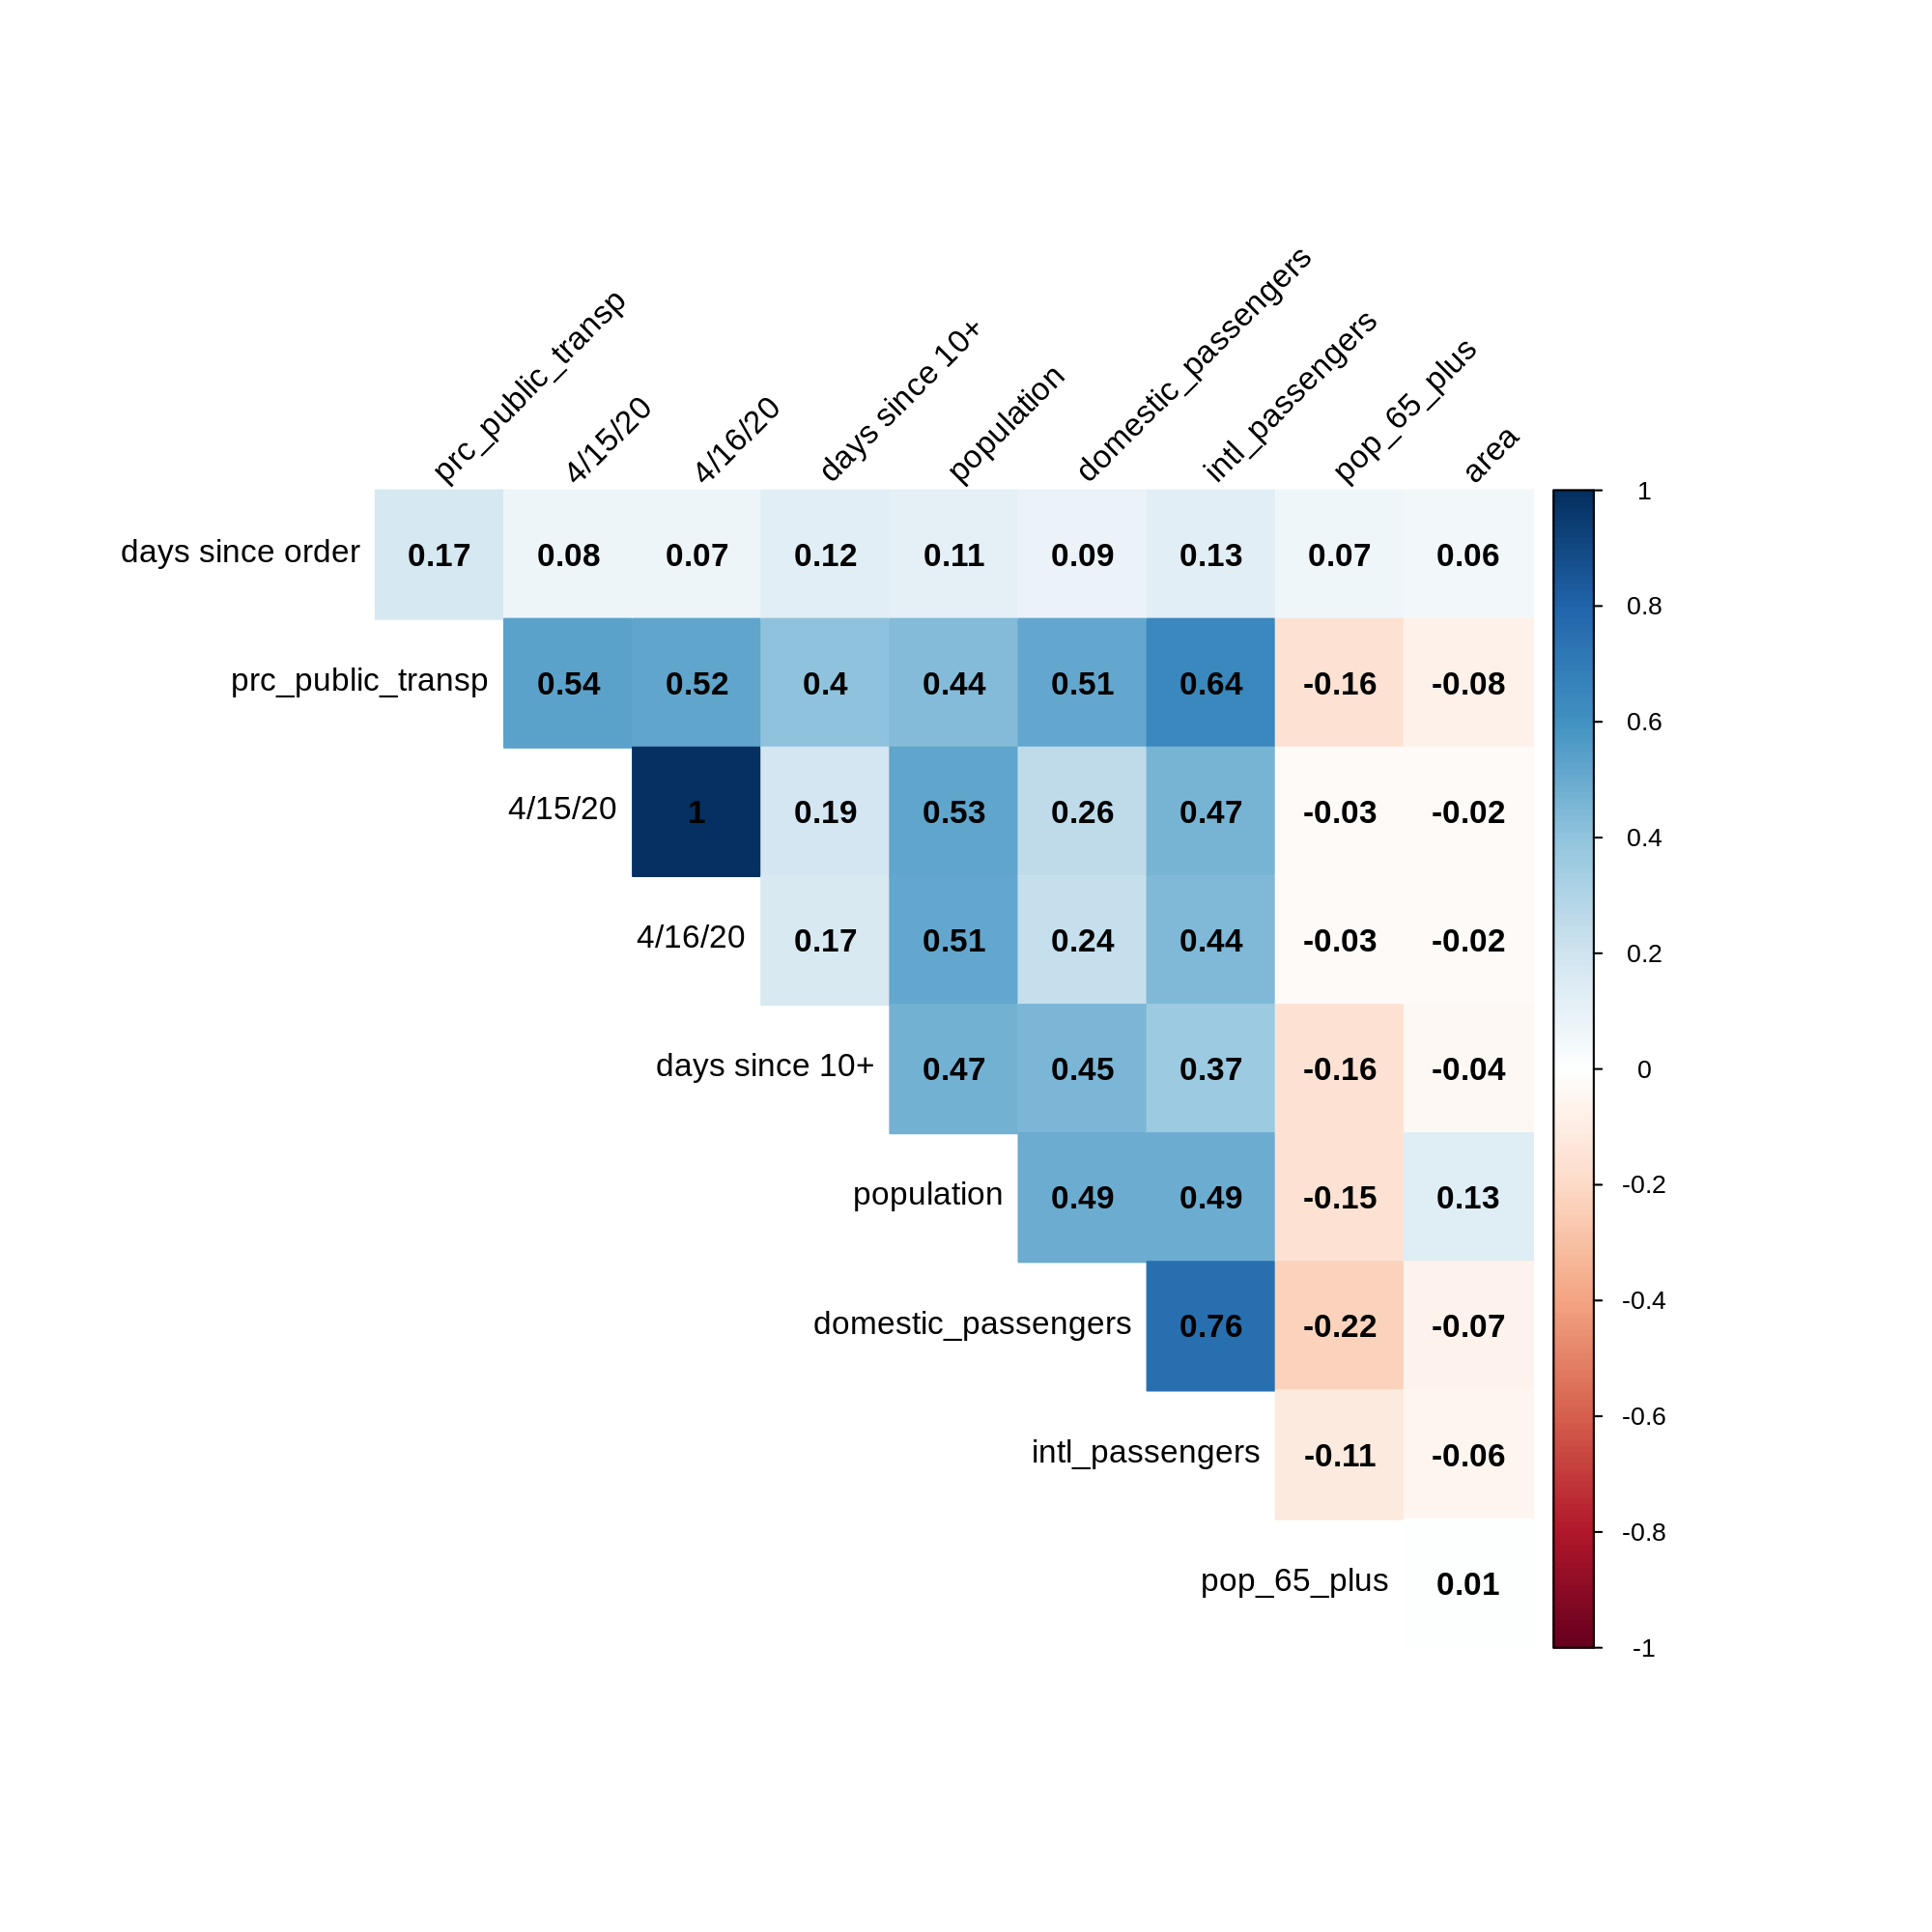

In [22]:
%%R -i data -w 10 -h 10 --units in -r 200

library(corrplot)
corr = cor(data[c("days since 10+", "days since order", "population", "pop_65_plus", "domestic_passengers", "intl_passengers", "prc_public_transp", "4/15/20", "4/16/20", "area")])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

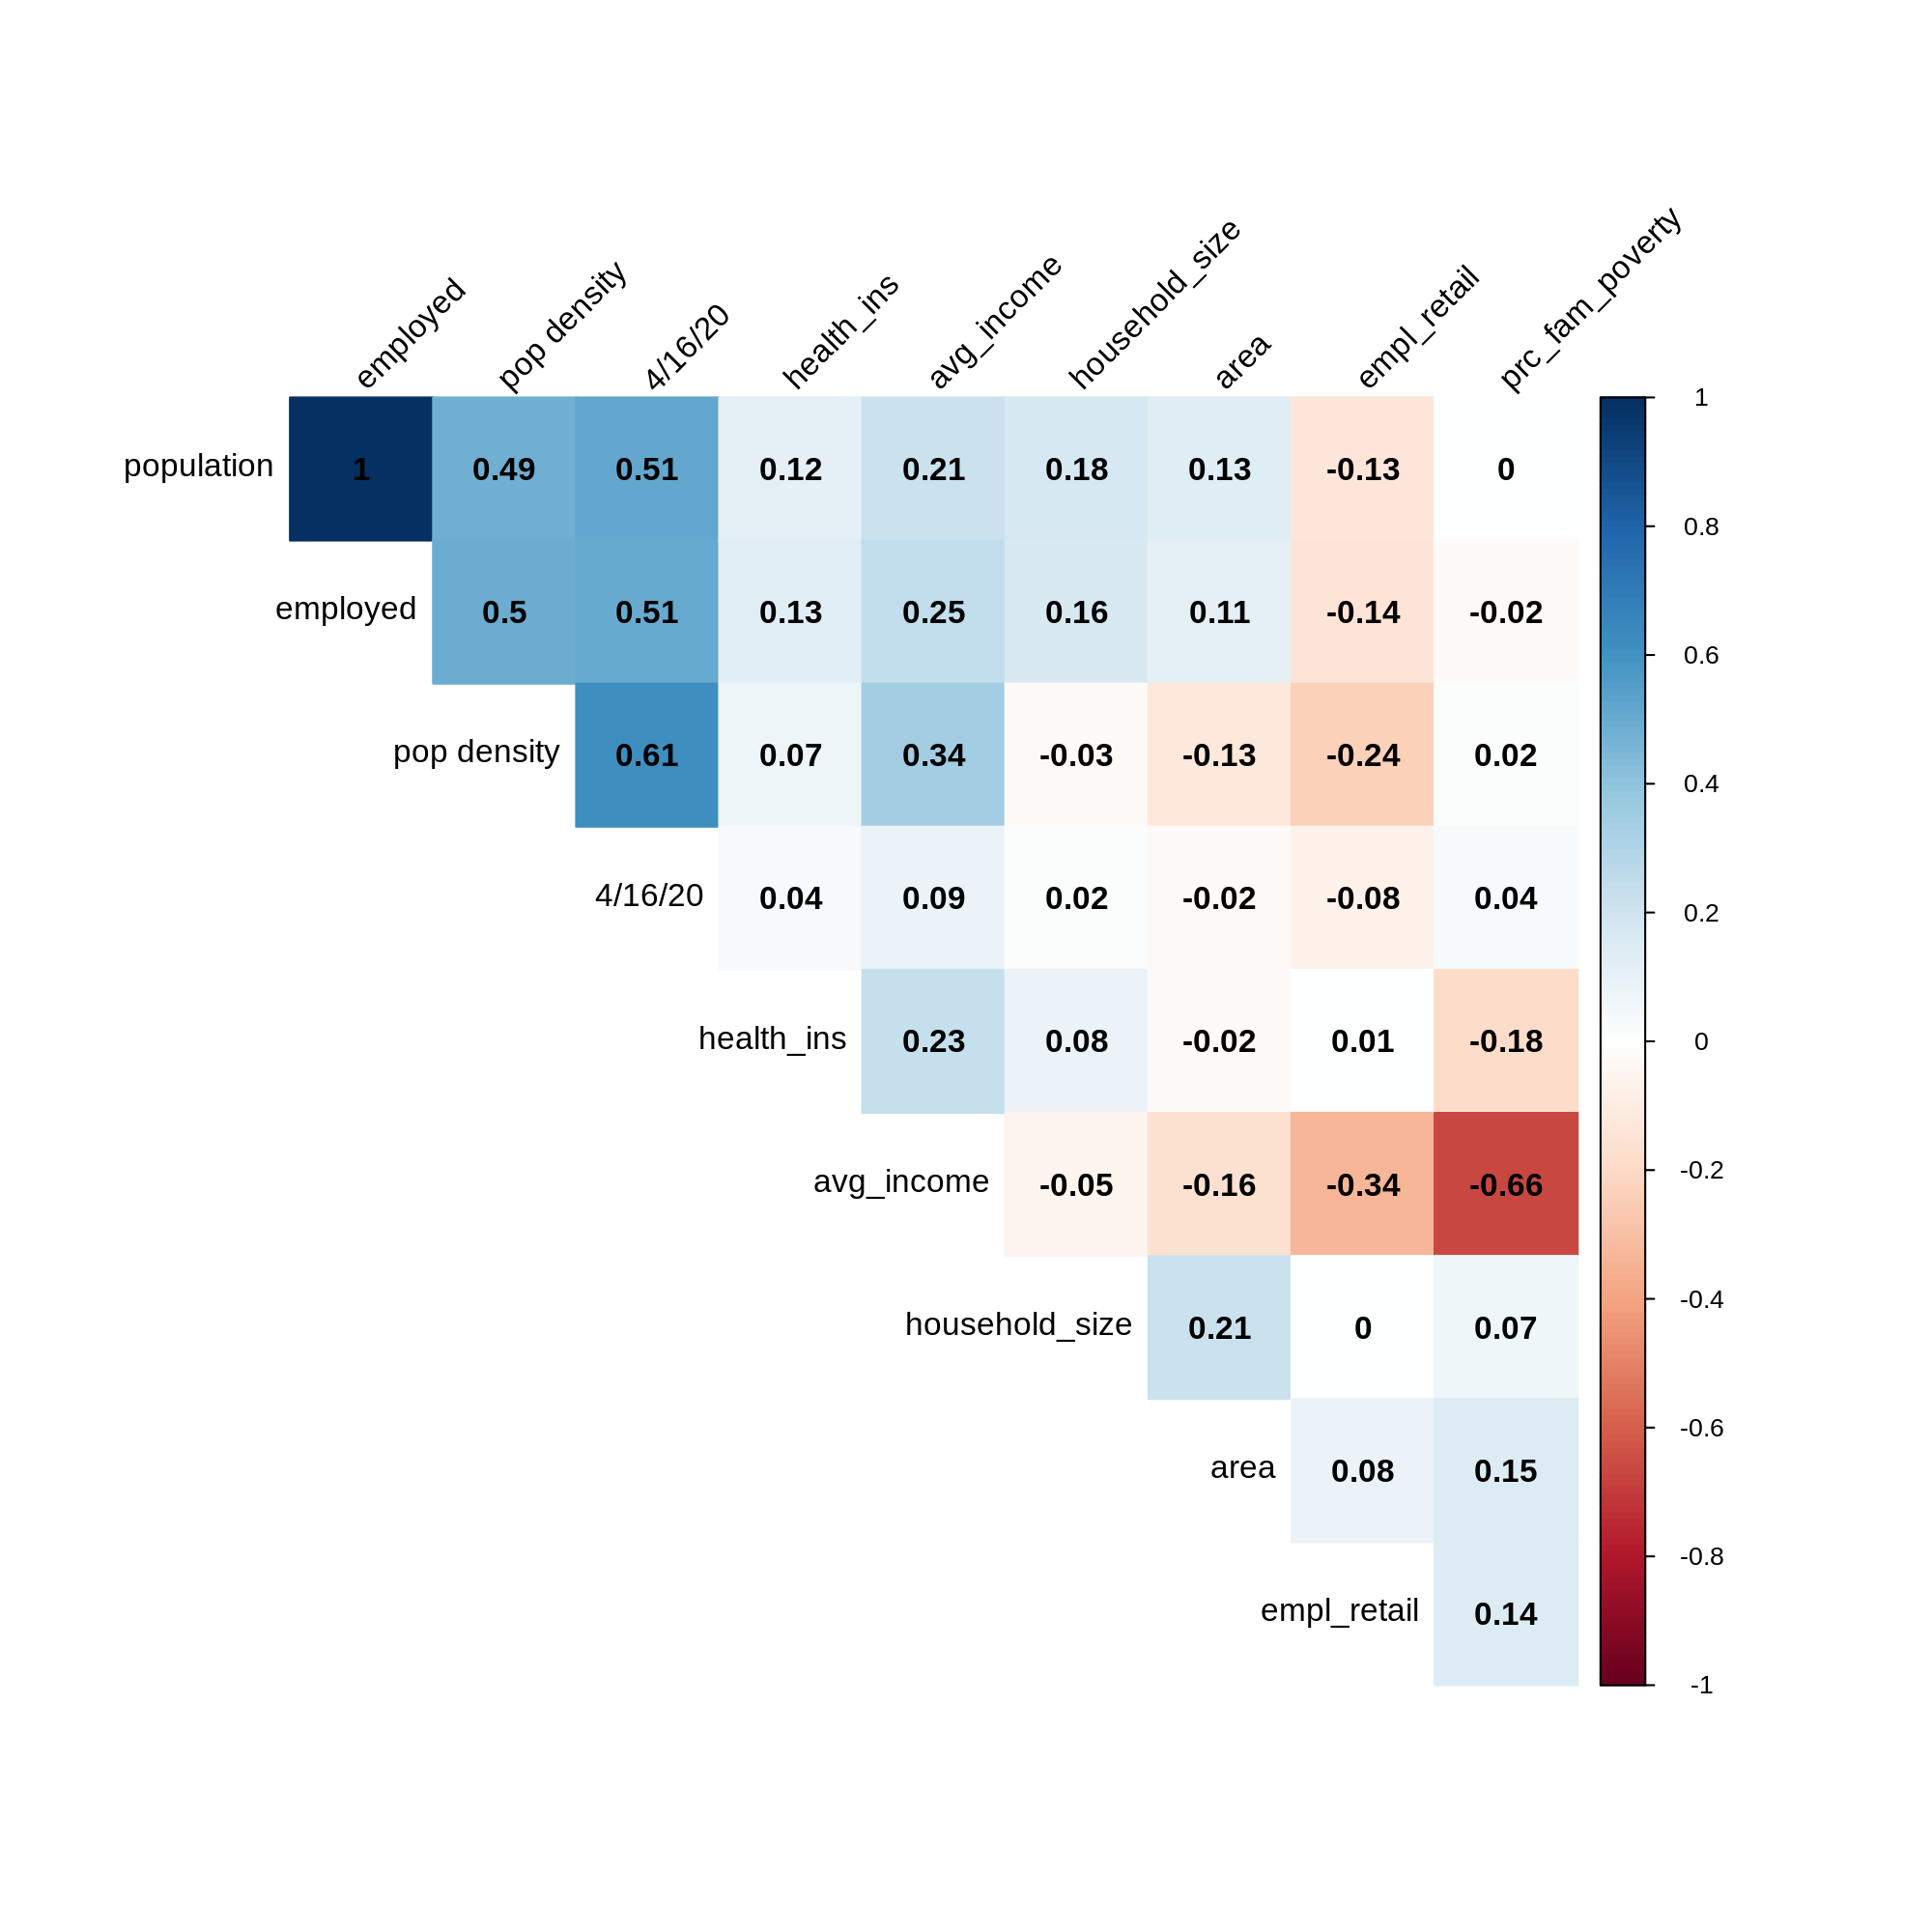

In [23]:
%%R -w 10 -h 10 --units in -r 200
# c("days since 10+", "days since order", "population", "pop_65_plus", 
# "domestic_passengers", "intl_passengers", "prc_public_transp", "4/16/20", "area")
library(corrplot)
corr = cor(data[c('household_size', "pop density", "area", "population", "health_ins",
       'empl_retail', 'employed', 'prc_fam_poverty', 'avg_income', "4/16/20")])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

# populations denisty correlates very much (positively) with # deaths

In [24]:
%%R
# load the ggplot2 library
library(ggplot2)

In [25]:
data.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'employed', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'FIPS', 'area', 'domestic_passengers',
       'intl_passengers', '1/22/20', '1/23/20', '1/24/20', '1/25/20',
       '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20',
       '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20',
       '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20',
       '3/14/20', '3/15/20', '3/16

In [26]:
abbrev = data.drop(['1/22/20', '1/23/20', '1/24/20', '1/25/20',
       '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20',
       '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20',
       '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20',
       '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20',
       '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20',
       '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20',
       '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4/9/20', '4/10/20', '4/11/20', '4/12/20',
       '4/13/20', '4/14/20', '4/15/20', "employed", "FIPS"], axis=1)

In [27]:
print(data.shape)
print(abbrev.shape)

(823, 109)
(823, 22)


In [28]:
abbrev.head()

household_size  empl_agriculture  empl_professional  empl_social  \
0             2.6               1.1               11.2         19.4   
1             3.1              14.8                7.4         21.6   
2             3.3              16.0               10.1         19.7   
3             2.4               1.3               16.4         20.7   
4             2.6               1.1                9.4         25.5   

   empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
0            8.3                22.2         10.2              9.9   
1            8.9                 7.1          9.3             15.6   
2           10.9                 6.5          9.0             10.5   
3           11.5                 3.5         10.6              5.1   
4           11.5                 4.4         12.9              9.5   

   avg_income  prc_public_transp  ...  health_ins           county  state  \
0     27742.0                0.4  ...        98.8    Morgan County     AL   
1     22628.0                0.5  ...        90.1     Kings County     CA   
2     30674.0                1.3  ...        96.3  Monterey County     CA   
3     37645.0                0.1  ...        98.8    Nevada County     CA   
4     28144.0                0.8  ...        99.2    Shasta County     CA   

     area domestic_passengers  intl_passengers  4/16/20  days since 10+  \
0   579.3              580000                0        0              19   
1  1389.4                   0                0        1               4   
2  3280.6              186000                0        3              26   
3   957.8                   0                0        1              19   
4  3775.4                   0                0        3              13   

   days since order  pop density  
0                15        205.6  
1                31        108.9  
2                31        132.8  
3                31        104.1  
4                31         47.7  

[5 rows x 22 columns]

In [29]:
abbrev.describe()

household_size  empl_agriculture  empl_professional  empl_social  \
count           823.0             823.0              823.0        823.0   
mean              2.6               1.9               10.1         23.9   
std               0.2               2.7                3.6          4.8   
min               1.9               0.0                0.0          0.0   
25%               2.4               0.5                7.7         20.9   
50%               2.5               1.0                9.6         23.2   
75%               2.7               2.3               11.9         26.4   
max               4.1              25.7               30.1         46.2   

       empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
count          823.0               823.0        823.0            823.0   
mean             9.7                11.1         11.5              9.0   
std              2.8                 5.8          2.0              4.2   
min              0.0                 0.0          0.0              1.3   
25%              8.0                 6.8         10.3              5.9   
50%              9.3                10.1         11.4              8.4   
75%             10.9                14.3         12.6             11.4   
max             32.0                43.9         21.3             29.4   

       avg_income  prc_public_transp  population  pop_65_plus  health_ins  \
count       823.0              823.0     8.2e+02        823.0       823.0   
mean      31988.1                1.9     3.4e+05         16.7        98.2   
std        7742.2                4.3     6.4e+05          4.2         2.1   
min       14605.0                0.0     6.3e+04          7.7        77.5   
25%       26839.5                0.3     9.6e+04         14.0        98.1   
50%       30605.0                0.7     1.6e+05         16.3        98.9   
75%       35698.0                1.8     3.3e+05         18.6        99.2   
max       71606.0               55.9     1.0e+07         56.8        99.8   

          area  domestic_passengers  intl_passengers  4/16/20  days since 10+  \
count    823.0              8.2e+02          8.2e+02    823.0           823.0   
mean    1072.1              4.0e+06          6.4e+05     38.1            20.7   
std     1819.3              8.9e+06          2.4e+06    408.4             7.9   
min       15.0              0.0e+00          0.0e+00      0.0             0.0   
25%      439.1              0.0e+00          0.0e+00      1.0            16.0   
50%      631.5              3.0e+05          0.0e+00      3.0            21.0   
75%      911.8              2.2e+06          0.0e+00     13.0            26.0   
max    24607.9              4.6e+07          2.4e+07  11477.0            45.0   

       days since order  pop density  
count             823.0        823.0  
mean               21.0        680.4  
std                 7.2       1702.4  
min                 0.0          4.4  
25%                17.0        140.2  
50%                20.0        271.5  
75%                27.0        557.8  
max                33.0      27750.7

### Plots

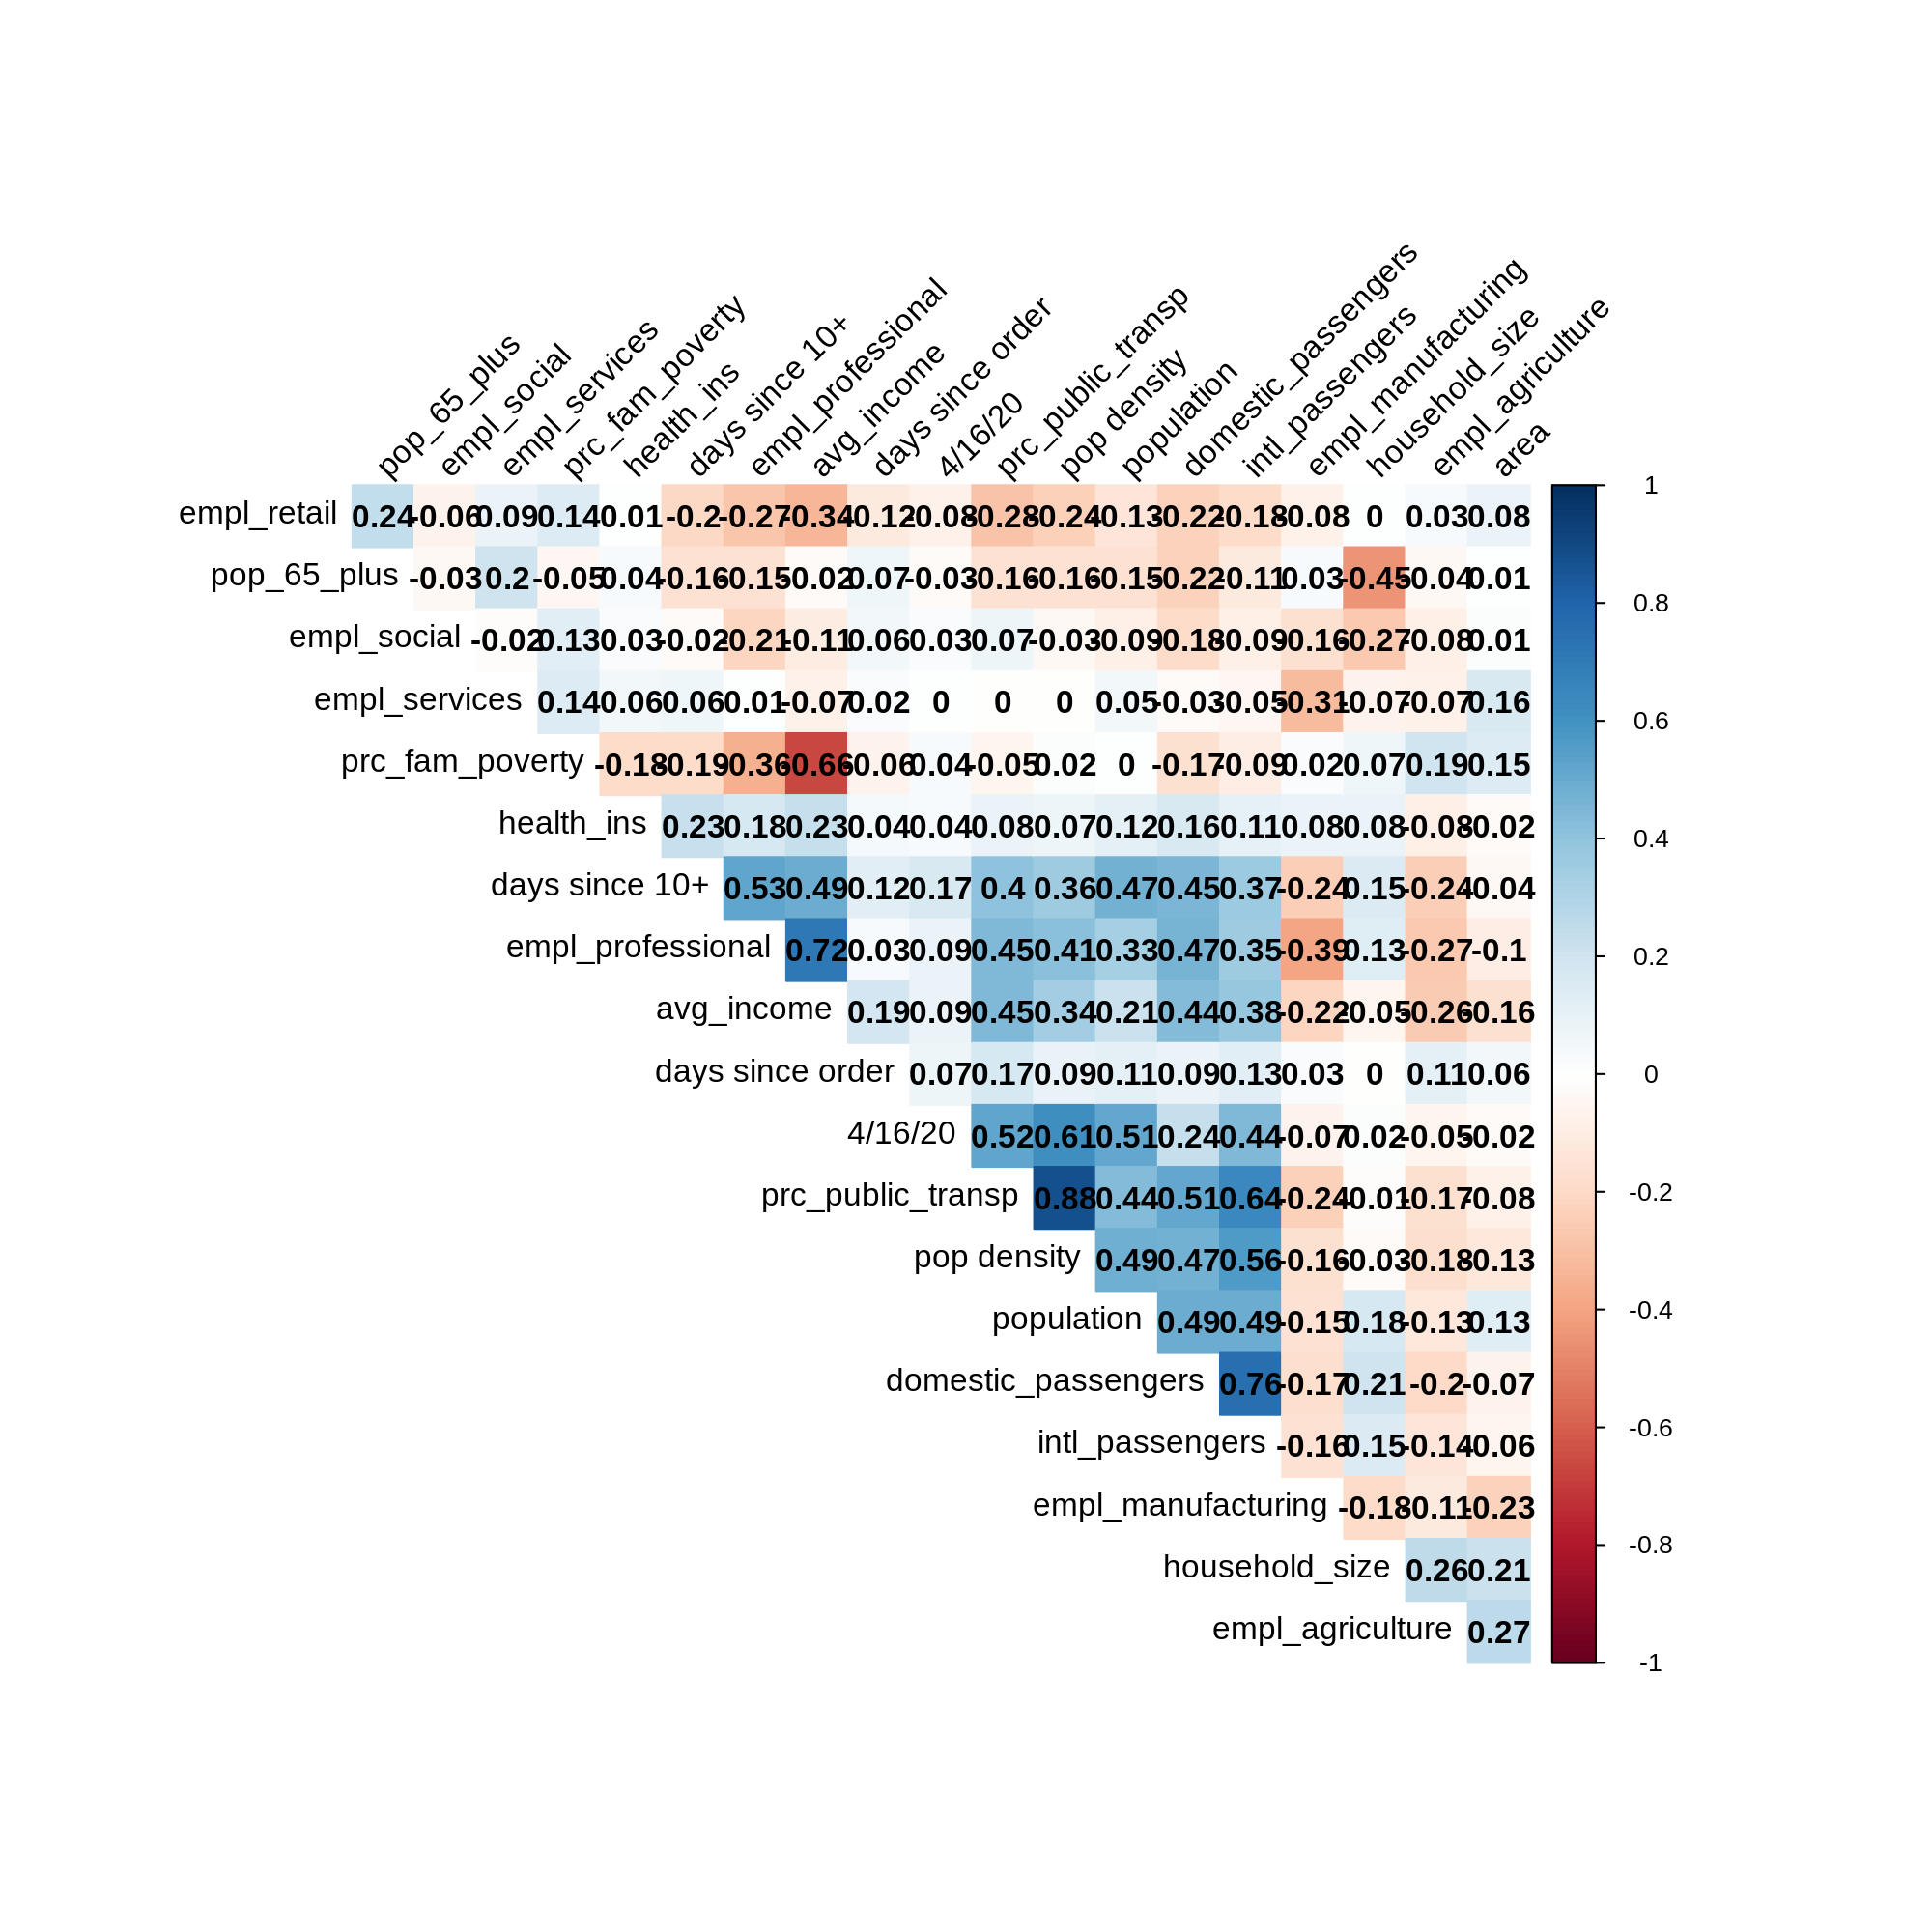

In [30]:
%%R -i abbrev -w 10 -h 10 --units in -r 200
library(corrplot)
corr = cor(abbrev[ c('household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'area',
       'domestic_passengers', 'intl_passengers', '4/16/20', 'days since 10+',
       'days since order', 'pop density')])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

# looks like greatest correlation between # deaths on 4/16/20 is pop density, avg_income, days since 10+, population, domestic_passengers, and intl_passengers

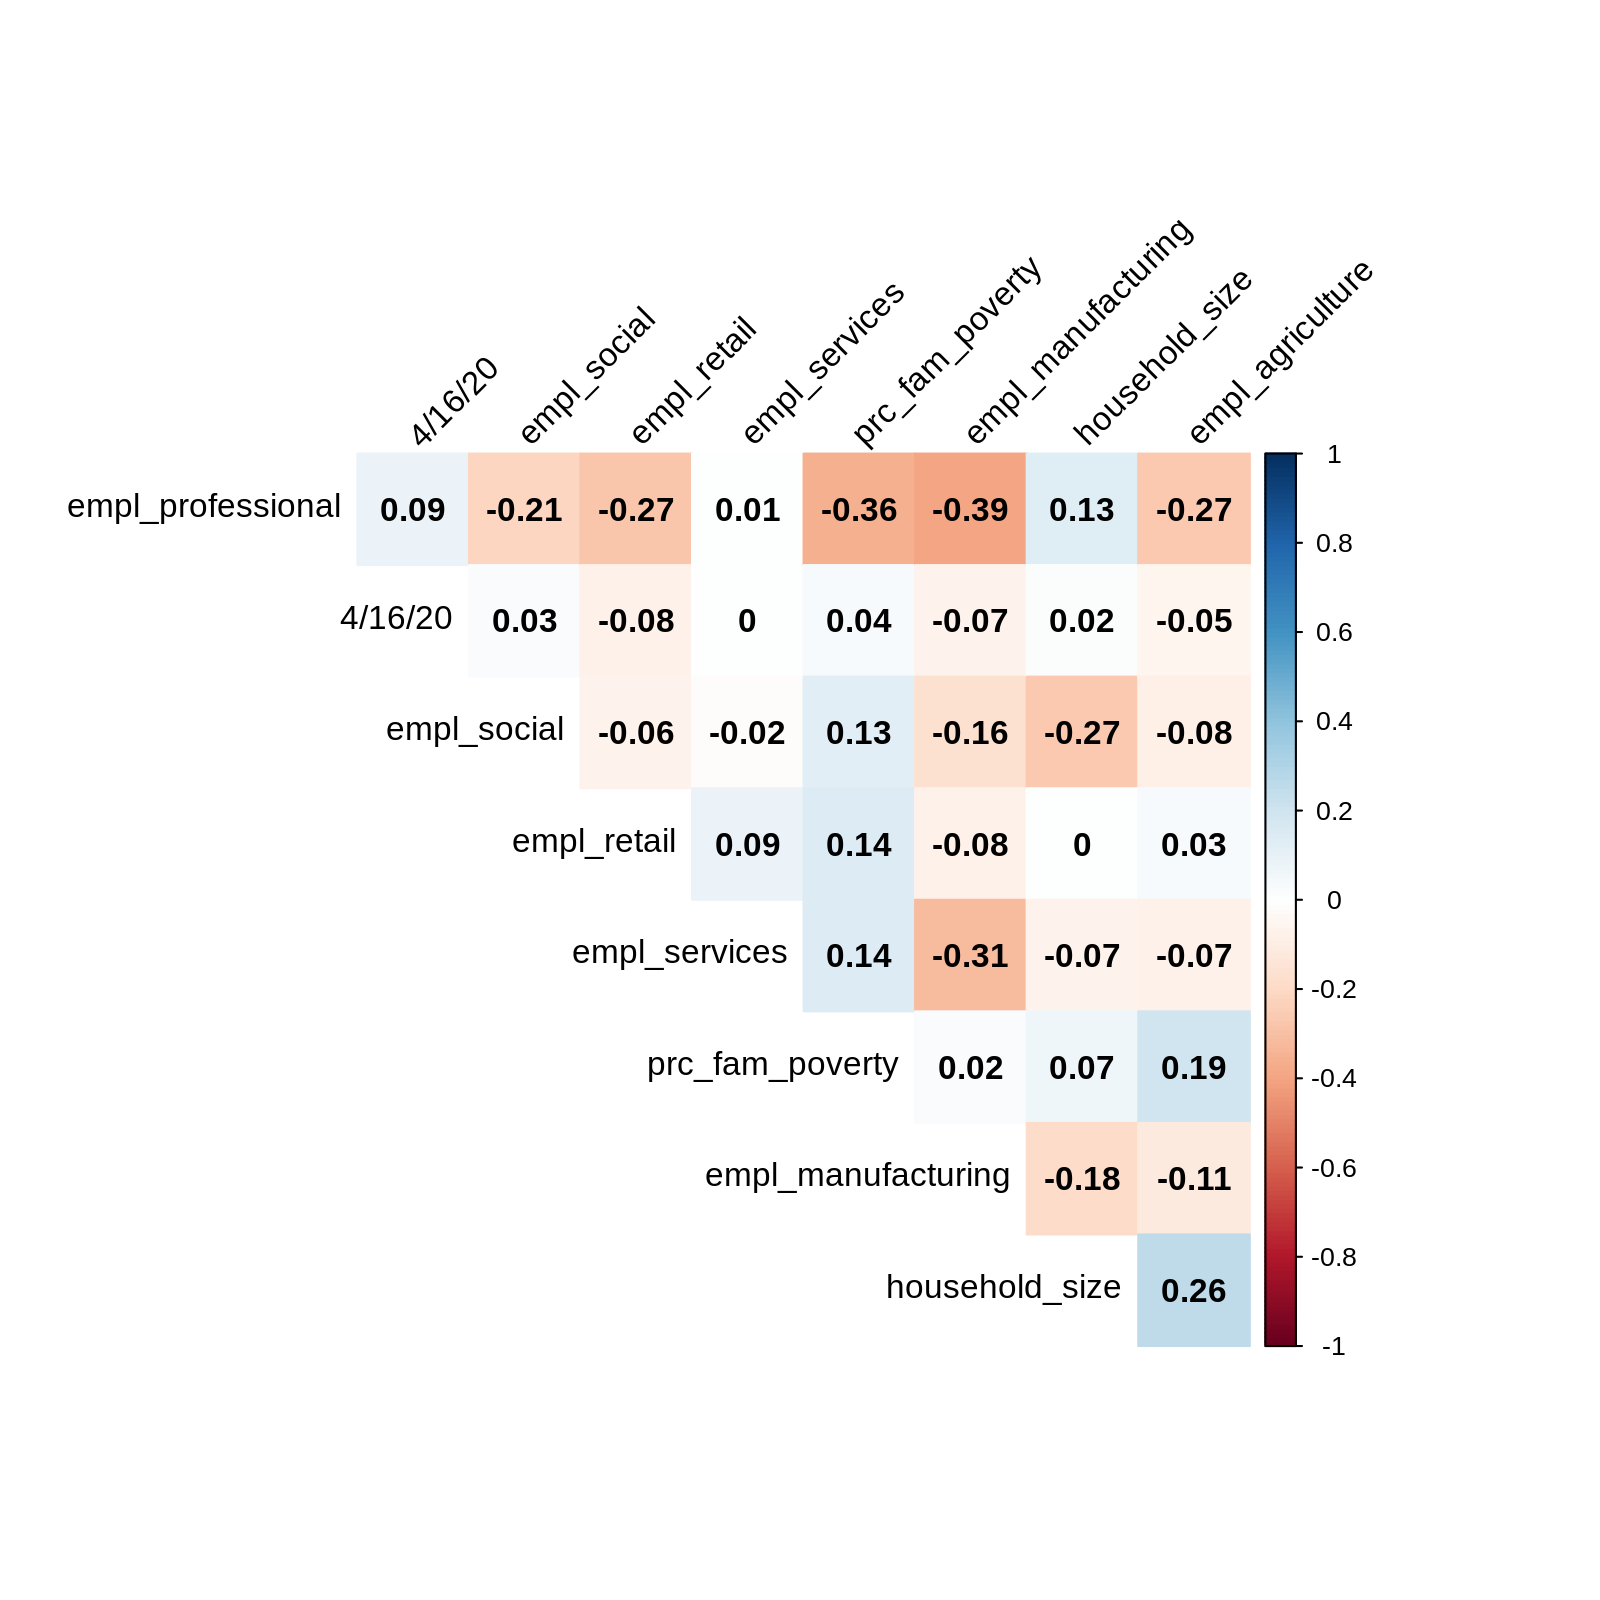

In [31]:
%%R -i abbrev -w 8 -h 8 --units in -r 200

corr = cor(abbrev[ c('household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', '4/16/20')])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", tl.col="black", tl.srt=45,diag=FALSE )

# of these, only household_size seems to have a positive correlational value with number of deaths
# surprised that empl in social services, retail, agriculture, etc. negative correlational value...

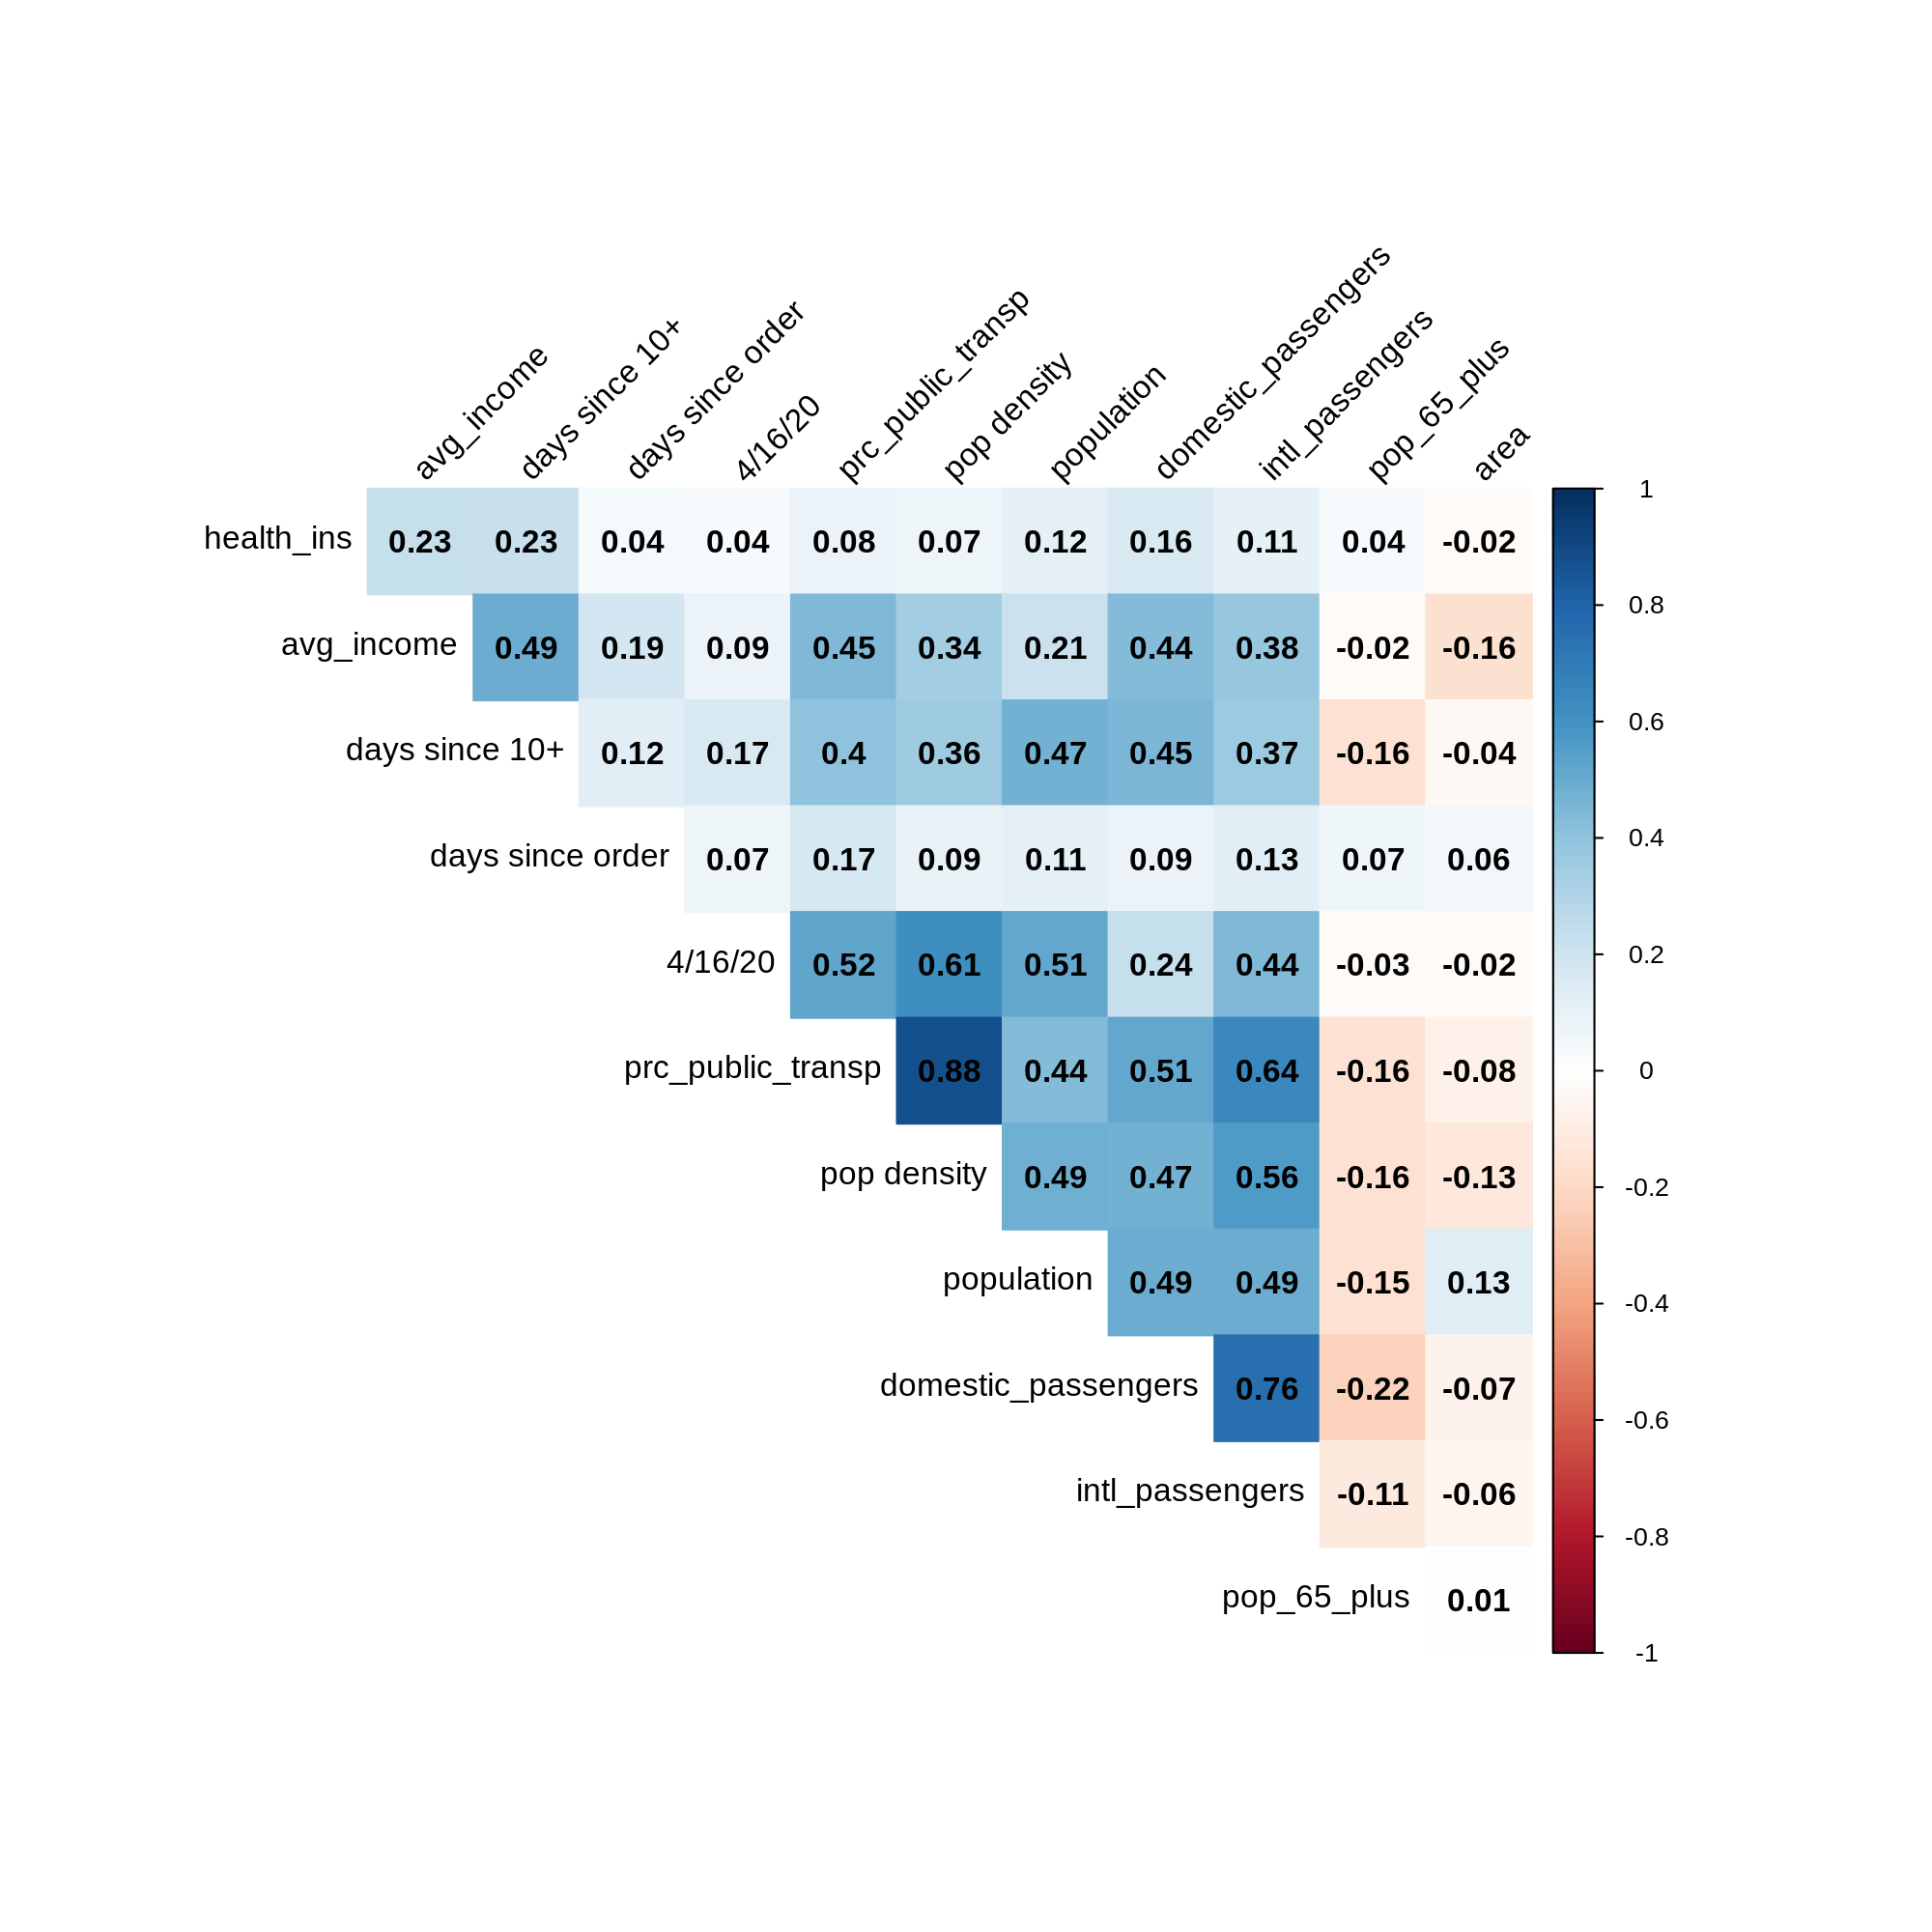

In [32]:
%%R -i abbrev -w 10 -h 10 --units in -r 200

corr = cor(abbrev[ c('avg_income', 'prc_public_transp', 'population','pop_65_plus', 'health_ins', 'area',
       'domestic_passengers', 'intl_passengers', '4/16/20', 'days since 10+','days since order', 'pop density')])
corrplot(corr, method="color", type="upper", order="hclust", 
         addCoef.col = "black", tl.col="black", tl.srt=45,diag=FALSE )

# most of these have some degree of correlation with deaths

In [33]:
# rename columns in abbrev
abbrev.columns = ['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area',
       'domestic_passengers', 'intl_passengers', "deaths", "ten_plus", "order", "density"]

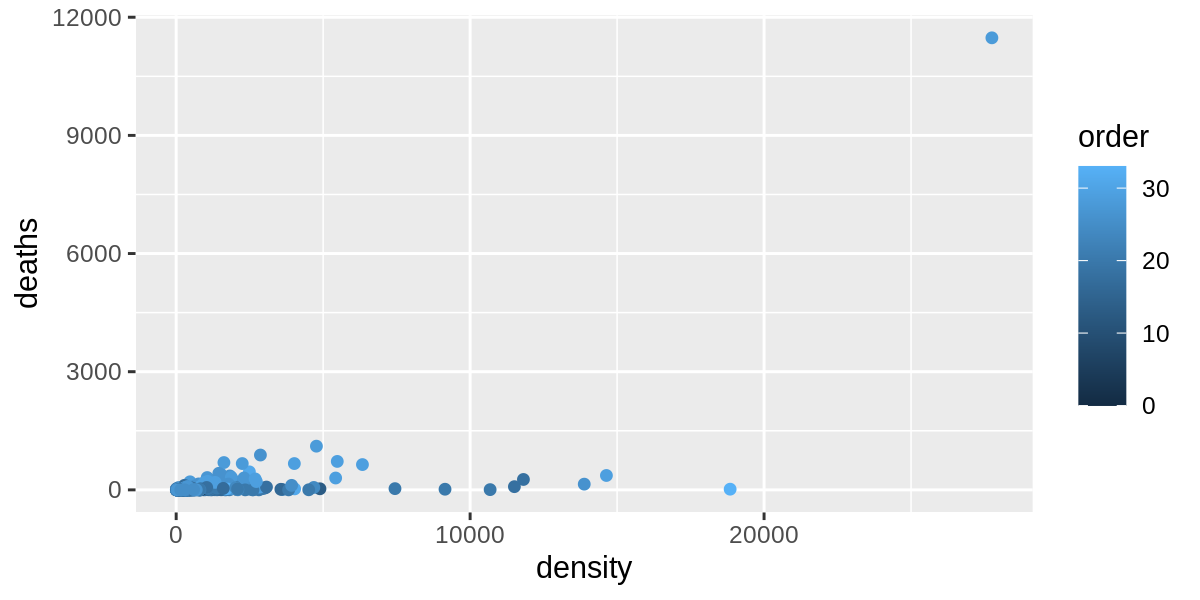

In [34]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(density, deaths, color=order))

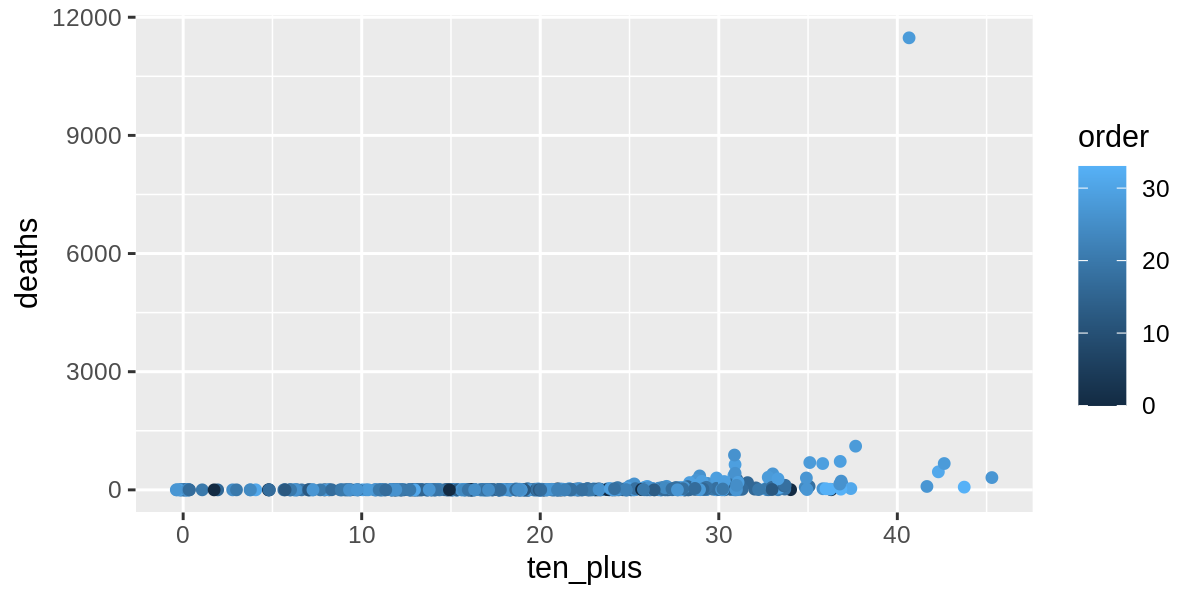

In [35]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(ten_plus, deaths, color=order))

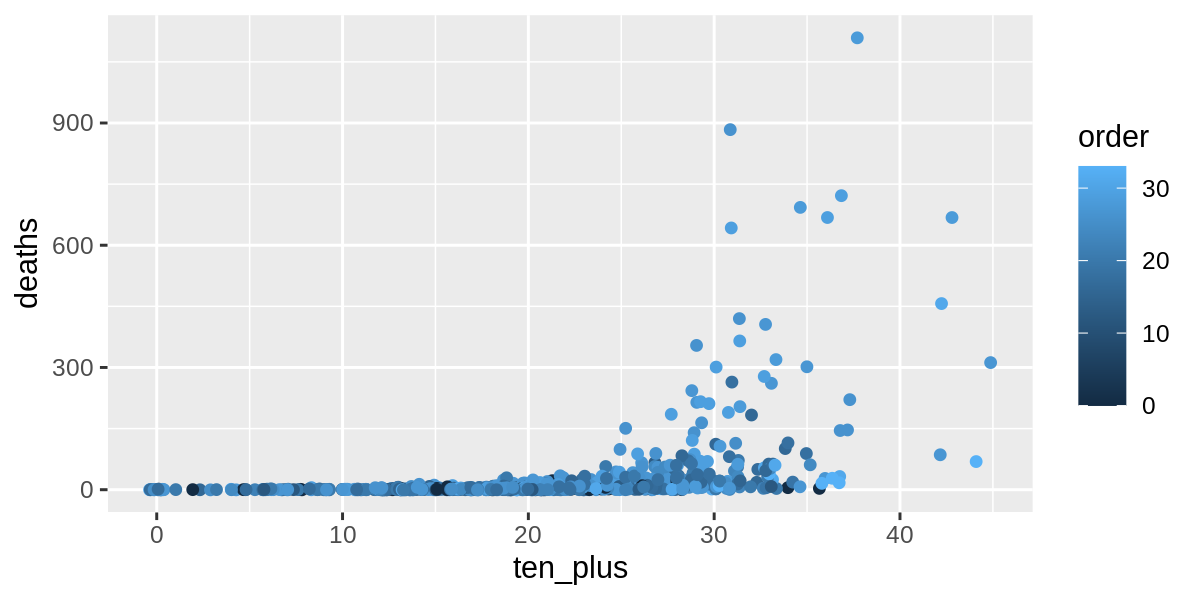

In [36]:
%%R -w 6 -h 3 --units in -r 200

# without NYC
ggplot(abbrev[which(abbrev$deaths < 9000), ]) + geom_jitter(aes(ten_plus, deaths, color=order))

# looking more closely at data points that aren't NYC, it looks like 
# deaths really start to vary/increase at 20 days or so after 10+ cases detected

In [37]:
abbrev[abbrev["deaths"] >= 9000]

household_size  empl_agriculture  empl_professional  empl_social  \
822             2.6           8.6e-02               14.1         26.9   

     empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
822           10.7                 3.0          8.9             14.2   

     avg_income  prc_public_transp  ...  health_ins           county  state  \
822     39588.7               55.9  ...        99.2  New York County     NY   

      area domestic_passengers  intl_passengers  deaths  ten_plus  order  \
822  302.6            44647000         24424000   11477        41     28   

     density  
822  27750.7  

[1 rows x 22 columns]

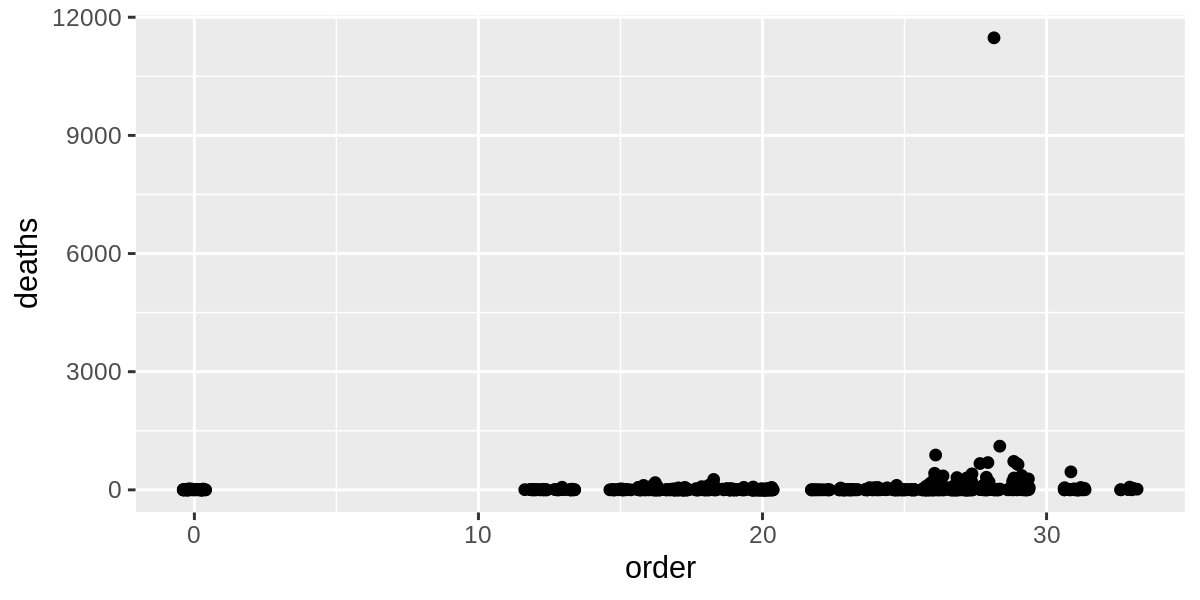

In [38]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, deaths))

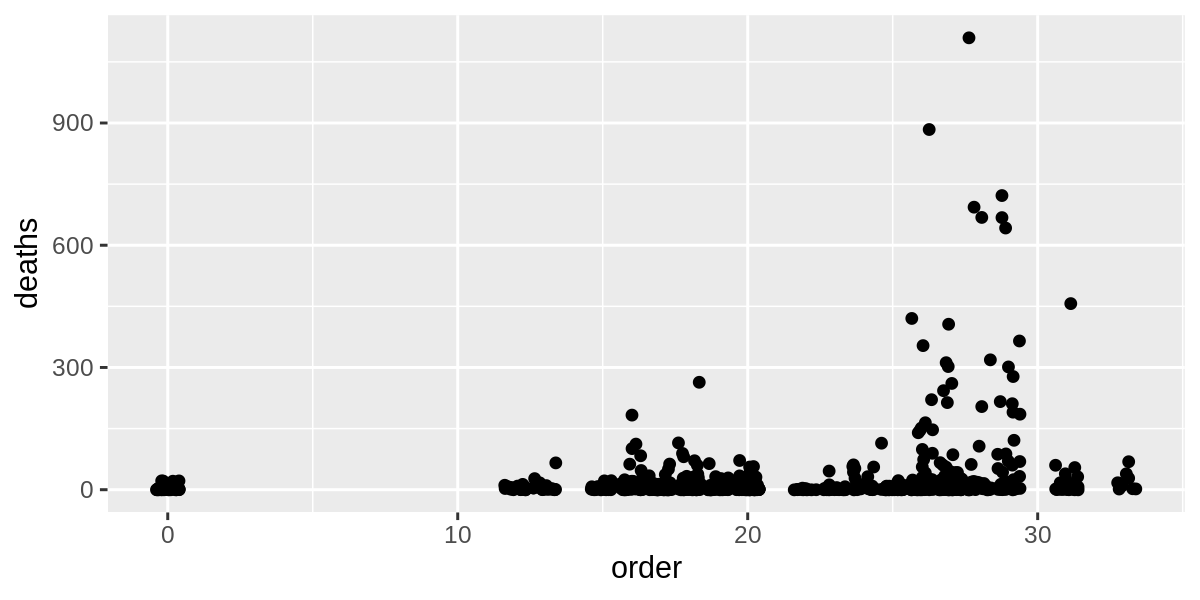

In [39]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(order, deaths))

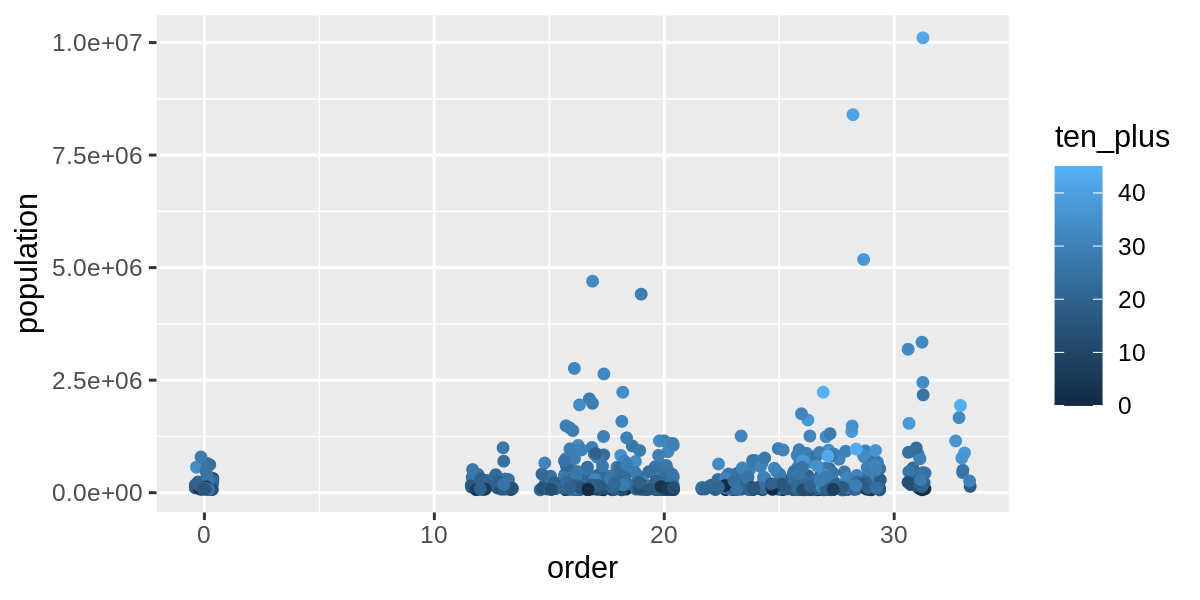

In [40]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, population, color=ten_plus))
# did more populous places enact shelter in place sooner?  did those with earlier 10+ confirmed cases?

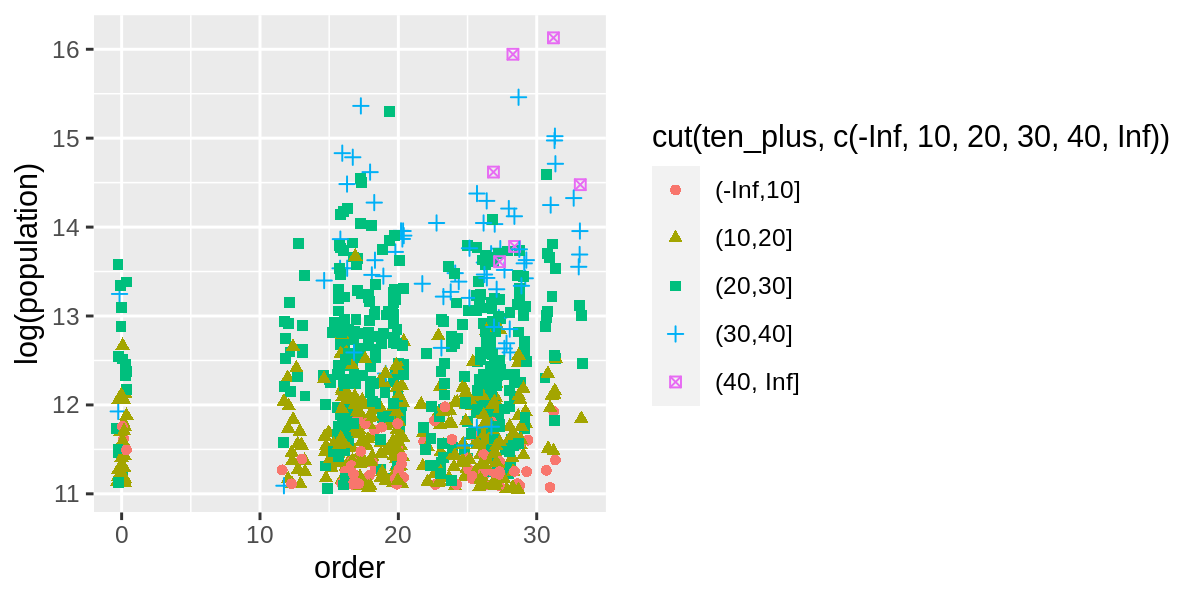

In [41]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, log(population), shape=cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), 
                                color=cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf))))
# did more populous places enact shelter in place sooner?  did those with earlier 10+ confirmed cases?

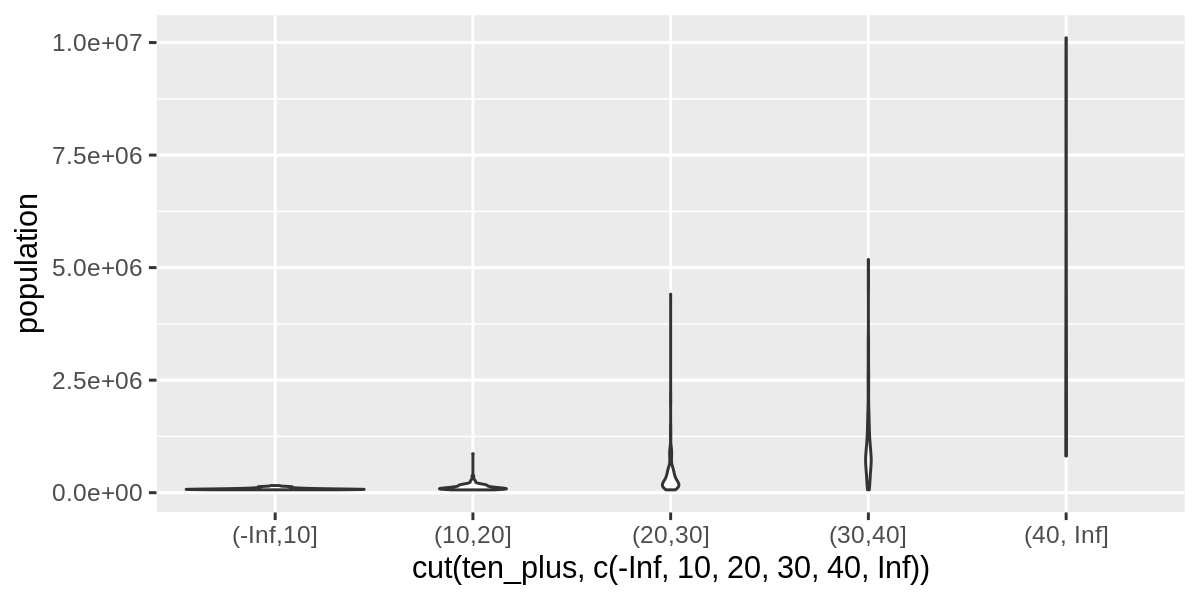

In [42]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) +  geom_violin(aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), population))

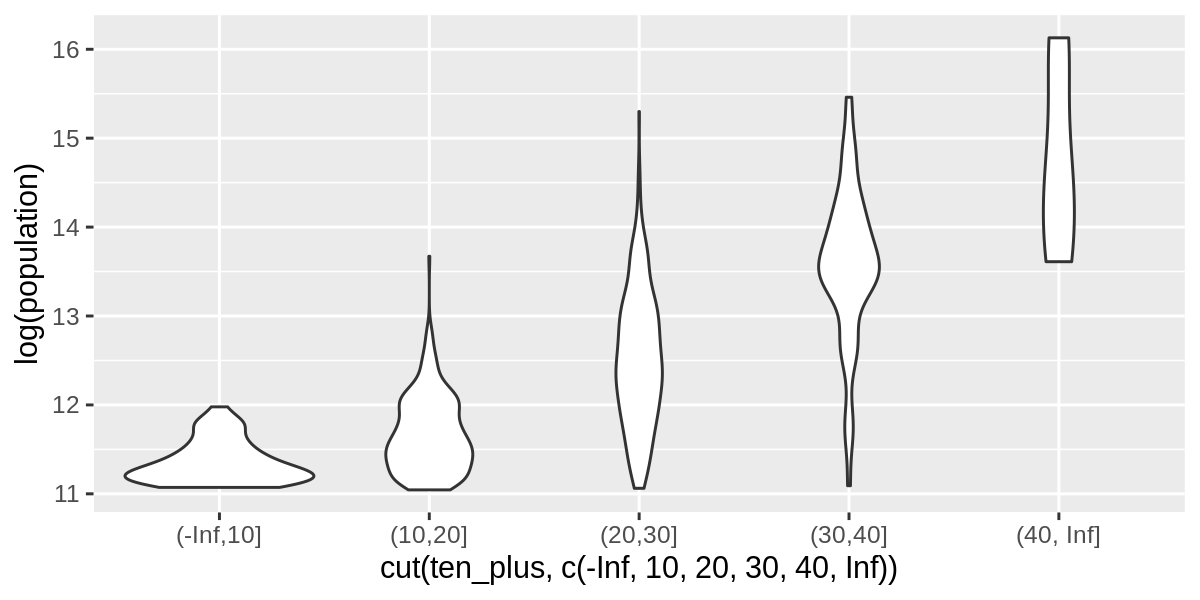

In [43]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) +  geom_violin(aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(population)))
# there is some variation within groups, but in general it seems like larger populations saw their
# first 10+ confirmed cases longer (more days) ago

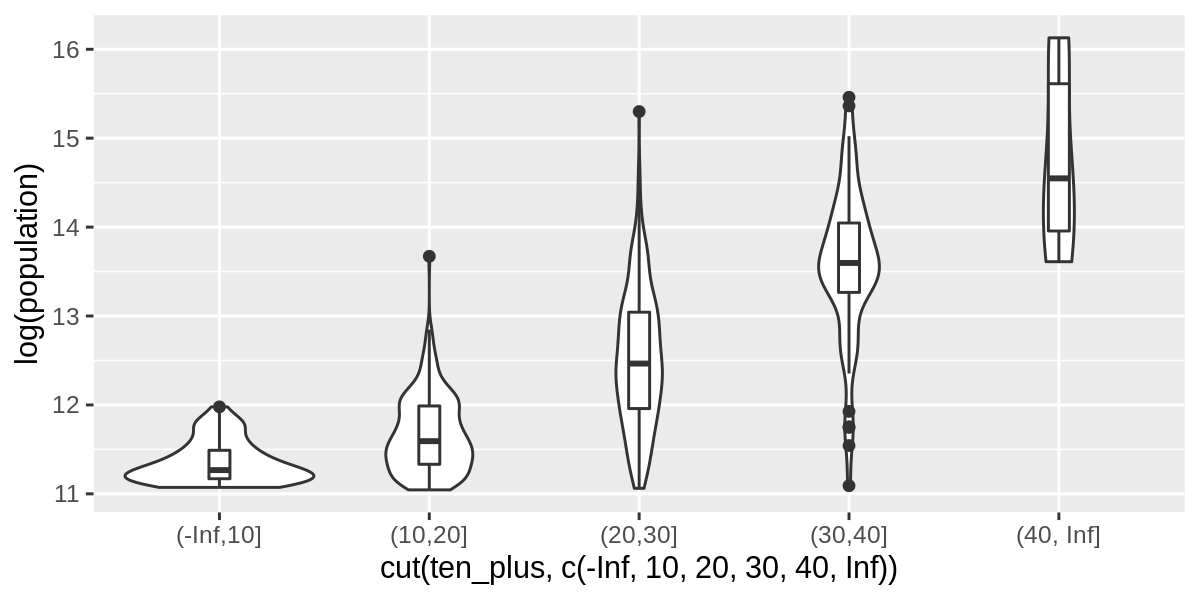

In [44]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(population))) +  
geom_violin() + 
geom_boxplot(width=0.1)

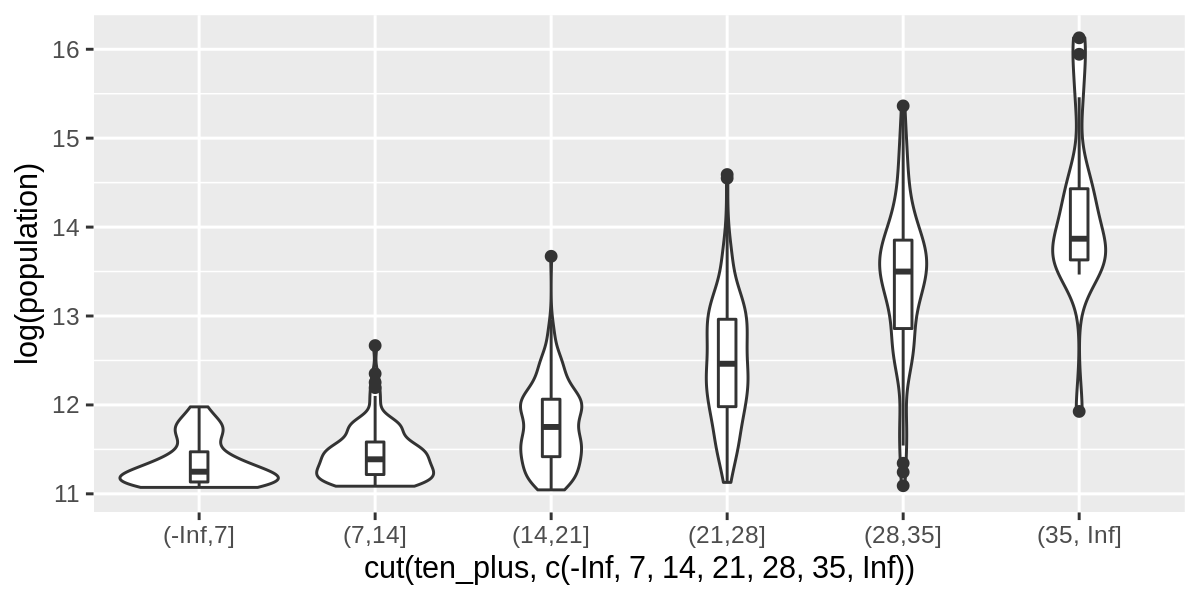

In [45]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(population))) +  
geom_violin() + 
geom_boxplot(width=0.1)

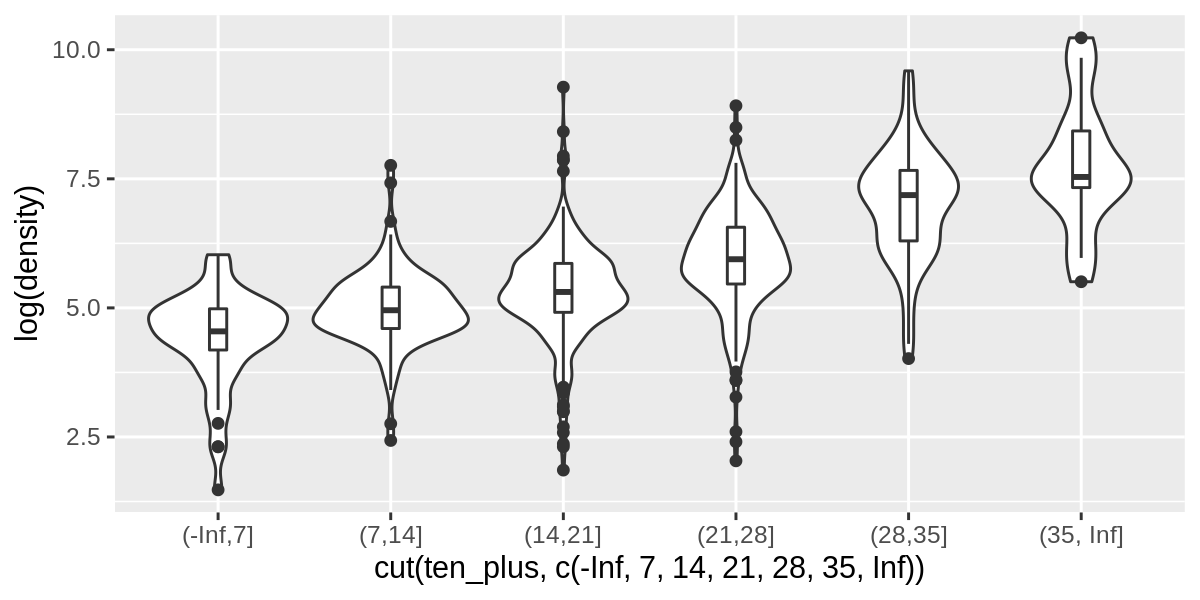

In [46]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(density))) +  
geom_violin() + 
geom_boxplot(width=0.1)

In [47]:
abbrev["domestic_passengers"].describe()

count    8.2e+02
mean     4.0e+06
std      8.9e+06
min      0.0e+00
25%      0.0e+00
50%      3.0e+05
75%      2.2e+06
max      4.6e+07
Name: domestic_passengers, dtype: float64

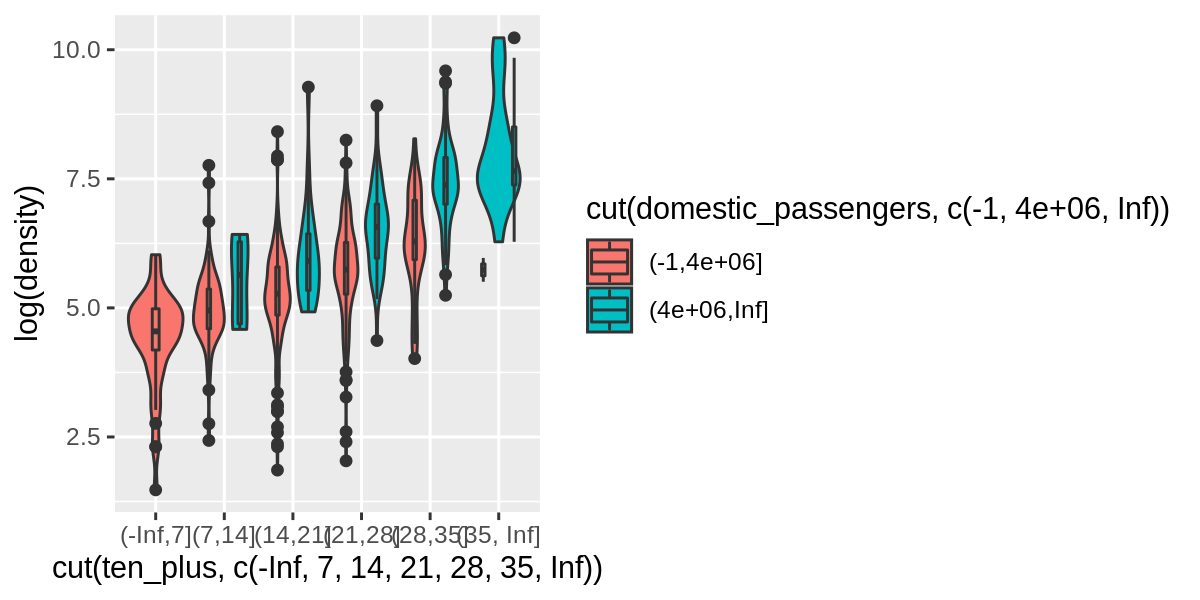

In [48]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(density), fill=cut(domestic_passengers, c(-1, 4000000, Inf)))) +  
geom_violin() + geom_boxplot(width=0.1, position=position_dodge(0.9))

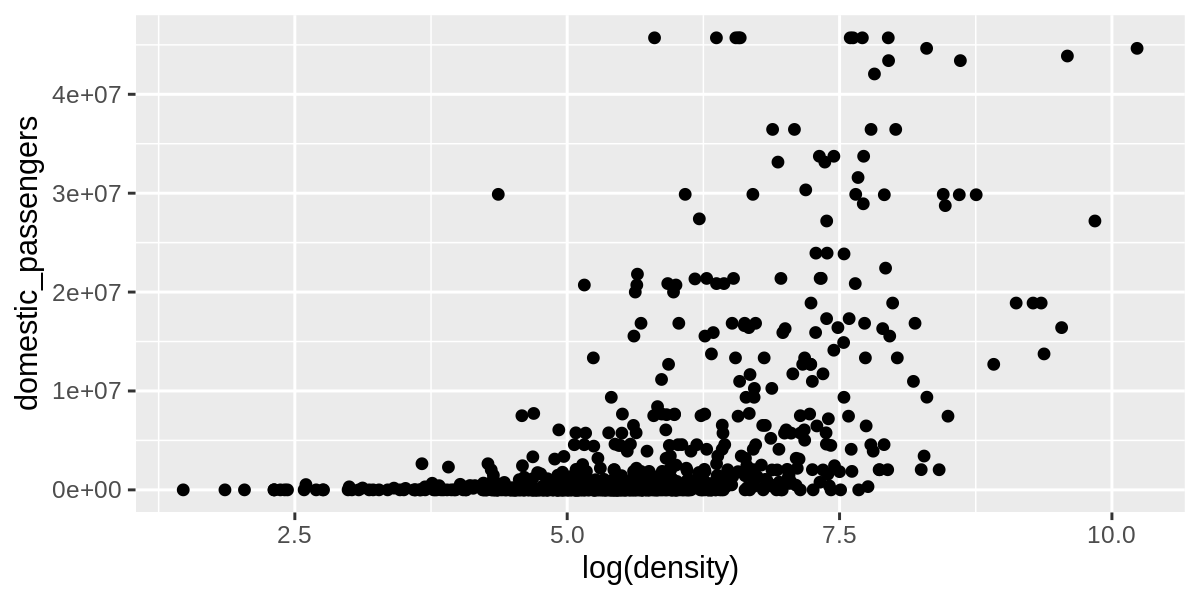

In [49]:
%%R -w 6 -h 3 --units in -r 200
# above is not very surprising if counties with larger population density also get larger number of domestic airplane passengers?

ggplot(abbrev, aes(log(density), domestic_passengers)) +  geom_jitter() 

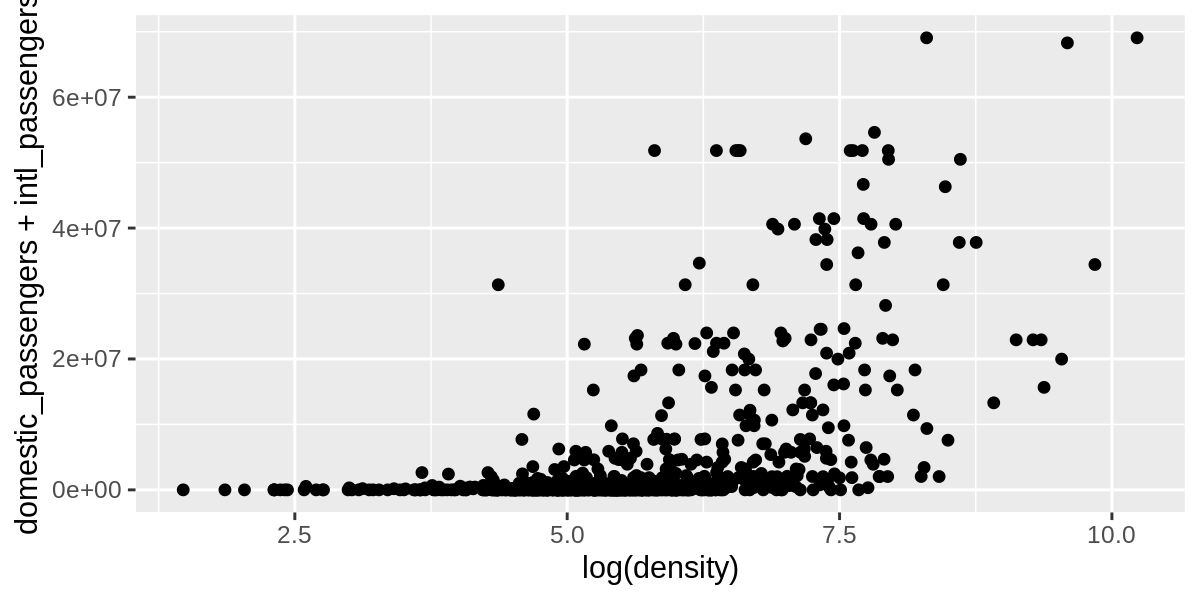

In [50]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(density), domestic_passengers + intl_passengers)) +  geom_jitter() 

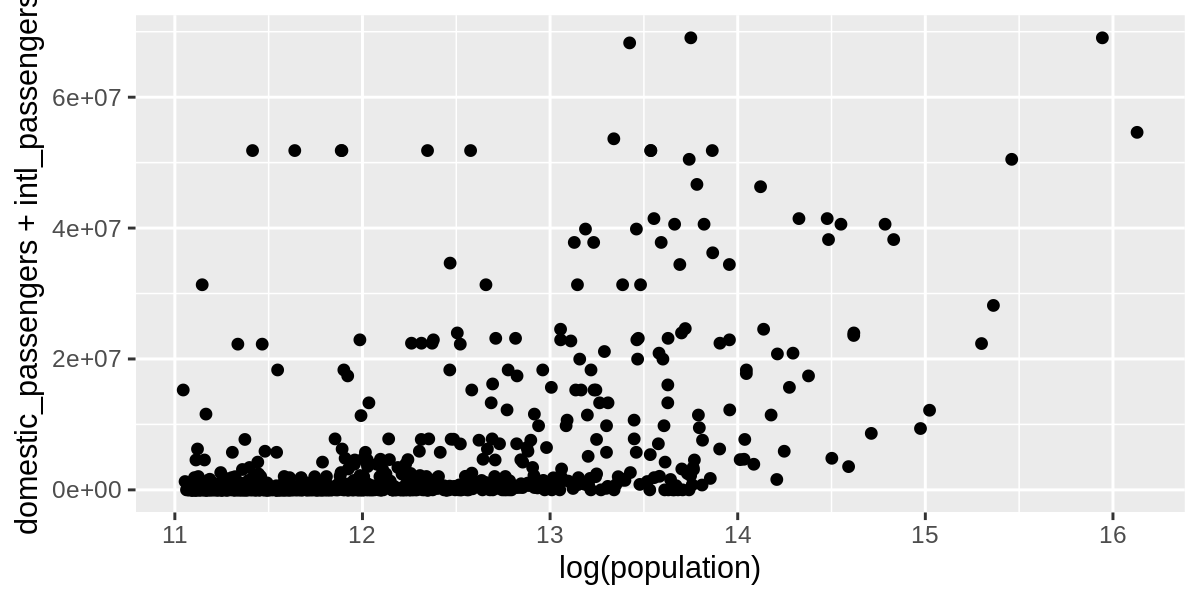

In [51]:
%%R -w 6 -h 3 --units in -r 200
# even less clear for population that it is for population density

ggplot(abbrev, aes(log(population), domestic_passengers + intl_passengers)) +  geom_jitter() 

In [52]:
abbrev.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'prc_fam_poverty', 'avg_income',
       'prc_public_transp', 'population', 'pop_65_plus', 'health_ins',
       'county', 'state', 'area', 'domestic_passengers',
       'intl_passengers', 'deaths', 'ten_plus', 'order', 'density'],
      dtype=object)

In [53]:
abbrev.prc_fam_poverty.mean()

9.007533050891846

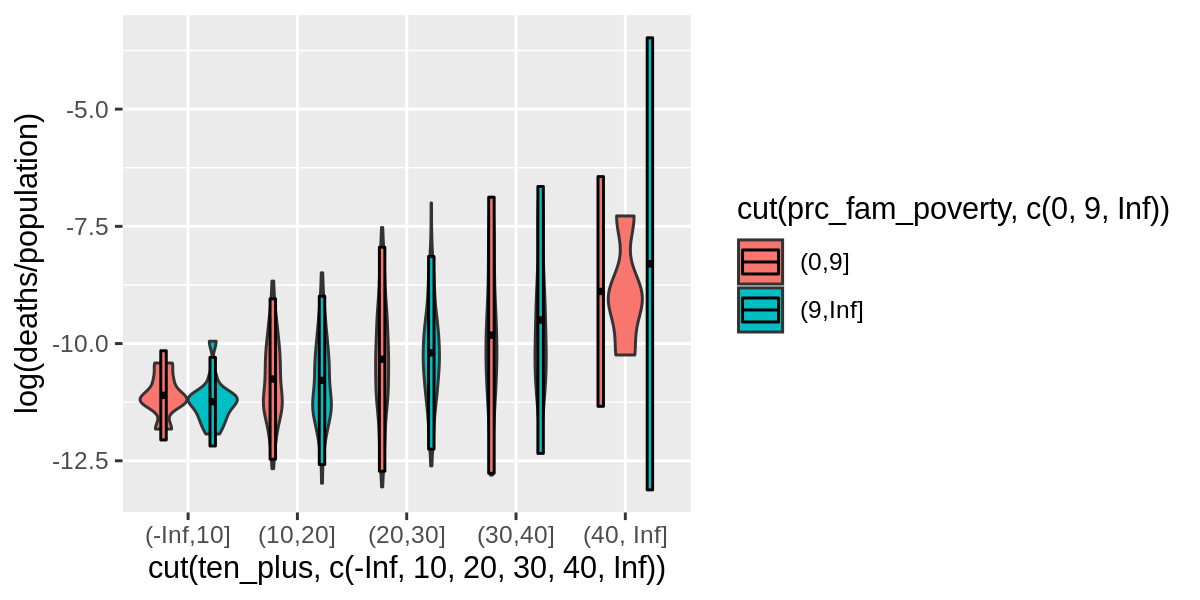

In [54]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(deaths/population), fill=cut(prc_fam_poverty, c(0, 9, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))
# looks like not a big difference in the first 2 weeks after 10+ cases detected, but the difference b/n means increases over time

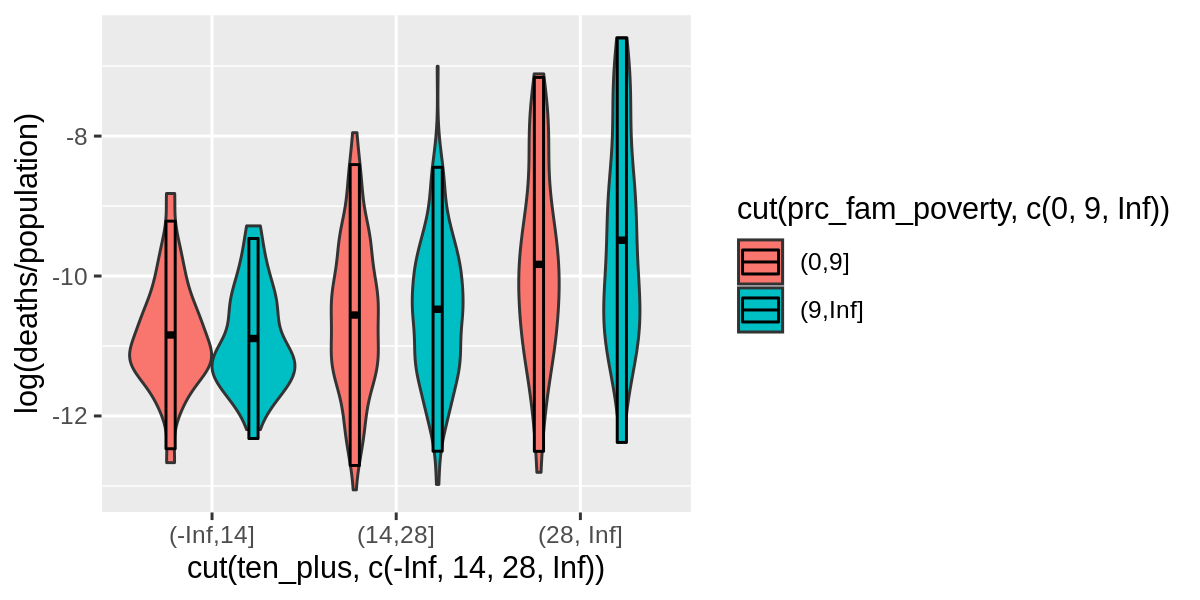

In [55]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 28, Inf)), log(deaths/population), fill=cut(prc_fam_poverty, c(0, 9, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))
# looks like not a big difference in the first 2 weeks after 10+ cases detected, but the difference b/n means increases over time

In [56]:
abbrev[["order", "ten_plus"]].describe()

order  ten_plus
count  823.0     823.0
mean    21.0      20.7
std      7.2       7.9
min      0.0       0.0
25%     17.0      16.0
50%     20.0      21.0
75%     27.0      26.0
max     33.0      45.0

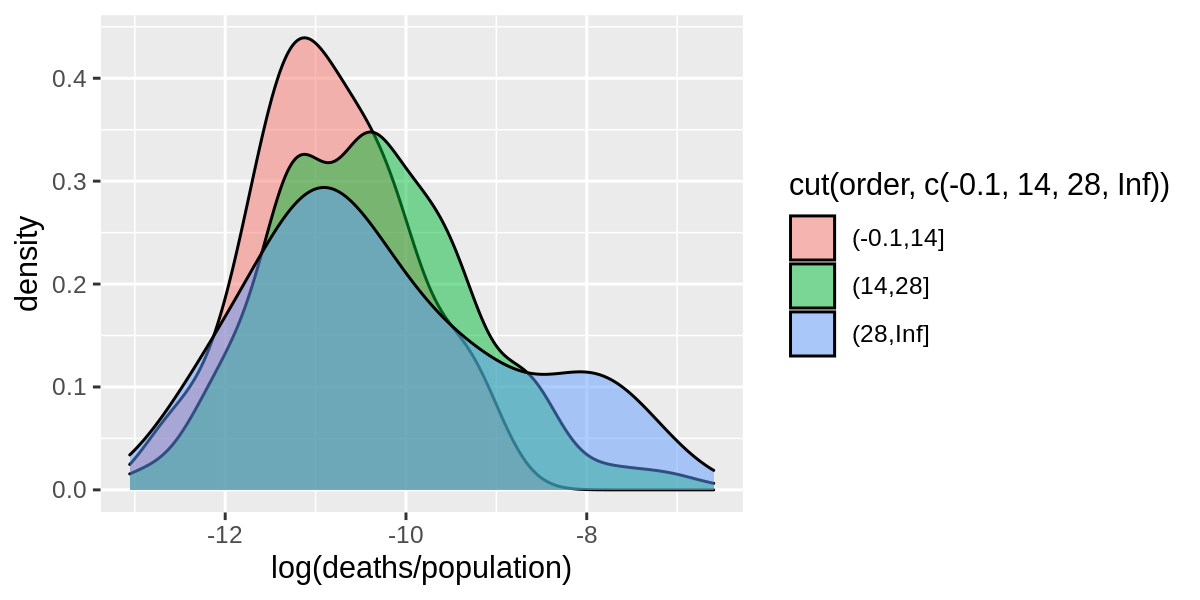

In [57]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(order, c(-0.1, 14.0, 28, Inf)))) + geom_density(alpha=.5)

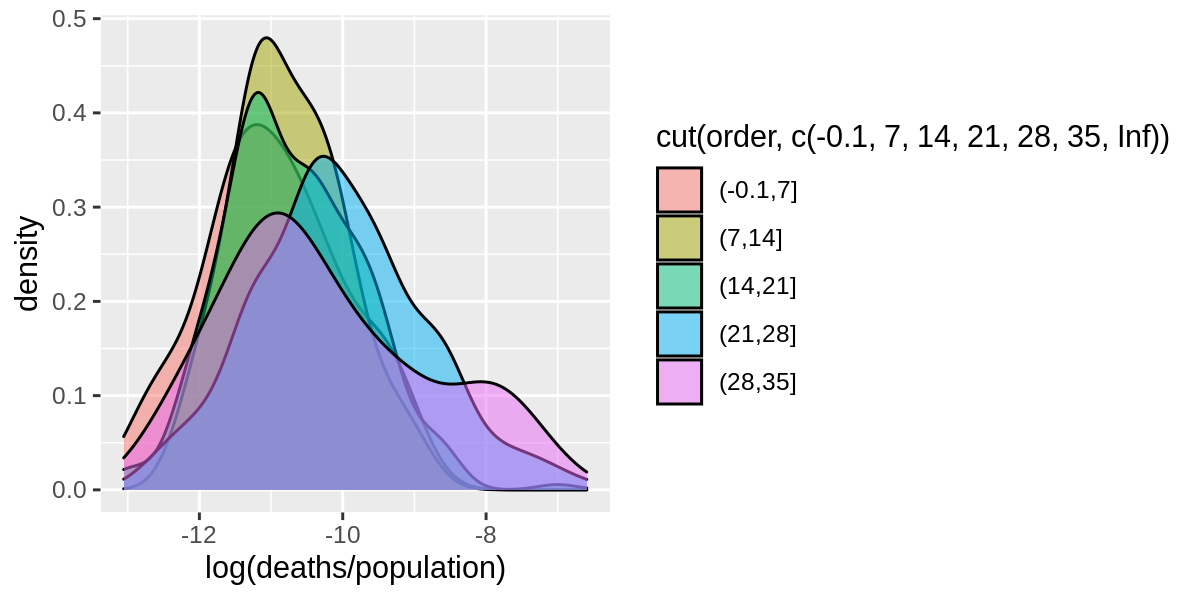

In [58]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(order, c(-0.1, 7, 14.0, 21, 28, 35, Inf)))) + geom_density(alpha=.5)

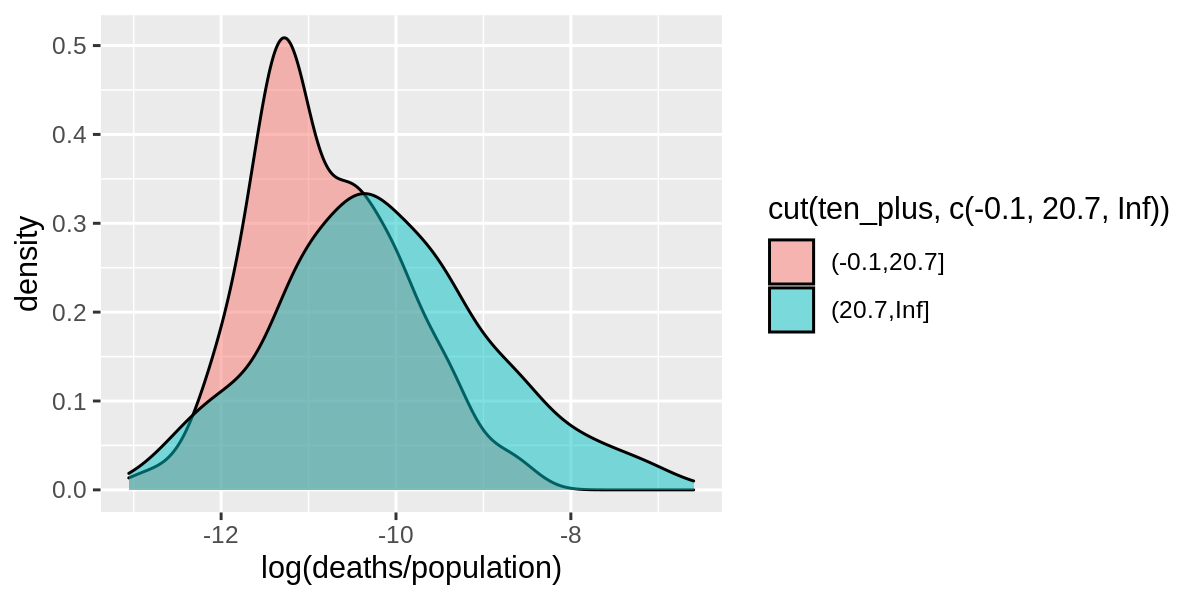

In [59]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(ten_plus, c(-0.1, 20.7, Inf)))) + geom_density(alpha=.5)
# not surprising that >avg time since 10+ cases detected on average have higher deaths/population

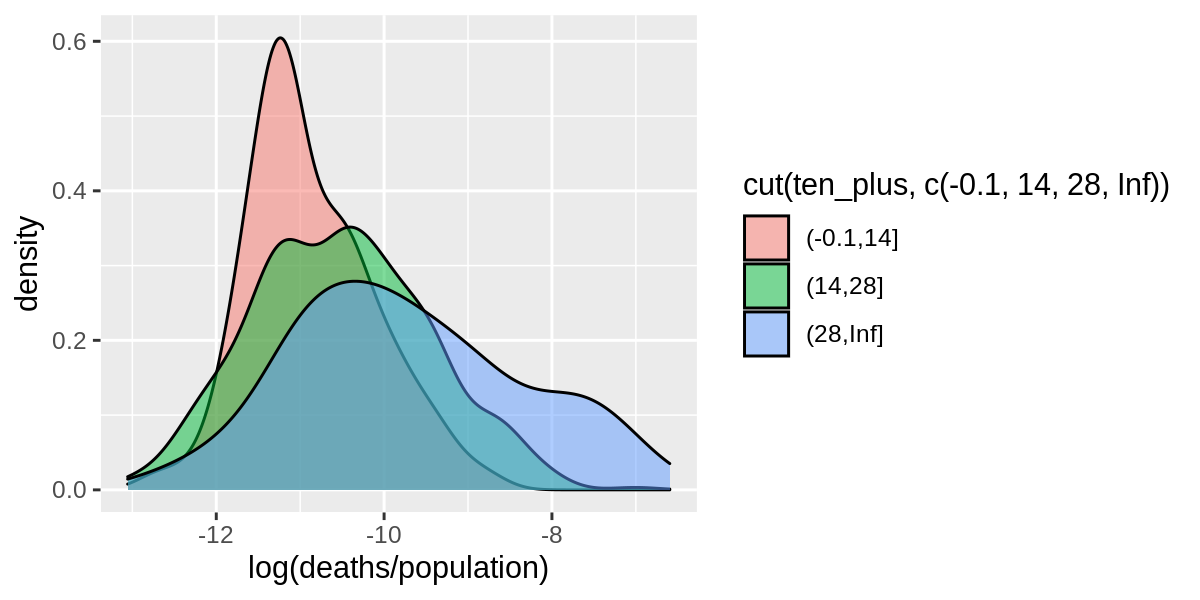

In [60]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(ten_plus, c(-0.1, 14, 28, Inf)))) + geom_density(alpha=.5)
# not surprising that >avg time since 10+ cases detected on average have higher deaths/population

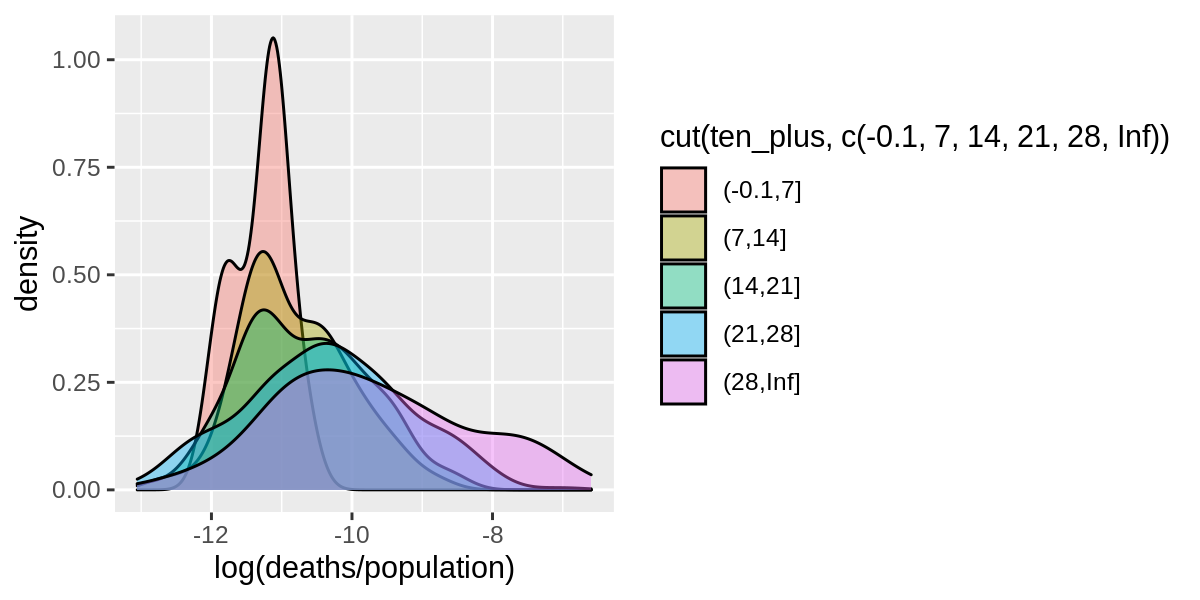

In [61]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(ten_plus, c(-0.1, 7, 14, 21, 28, Inf)))) + geom_density(alpha=.4)
# not surprising that >avg time since 10+ cases detected on average have higher deaths/population

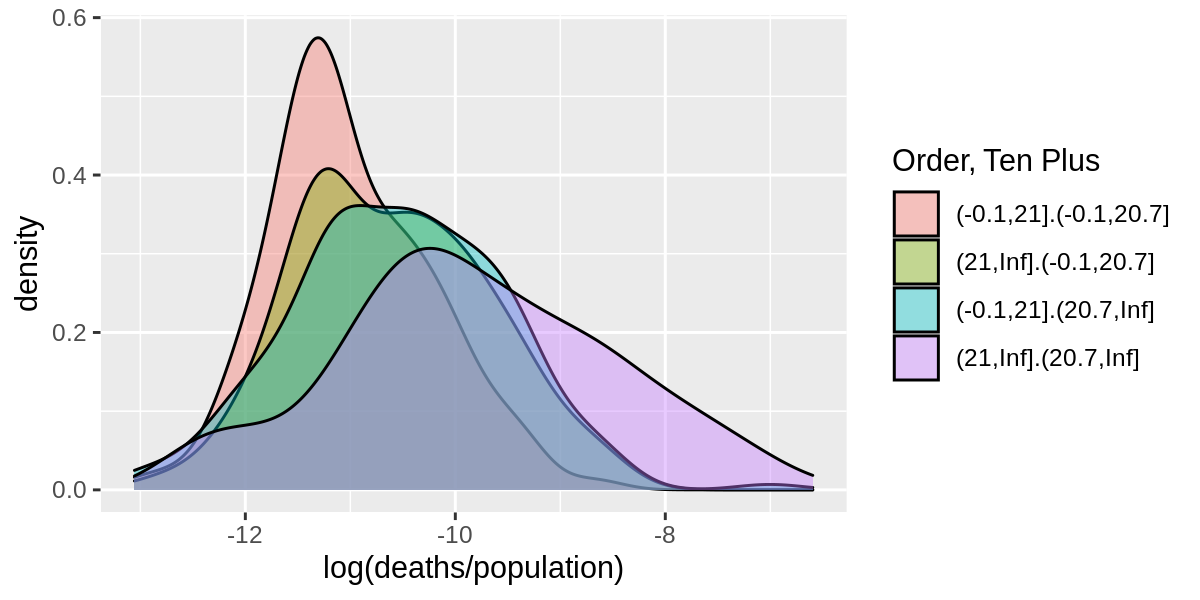

In [62]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=interaction(cut(order, c(-0.1, 21.0, Inf)), 
                                                              cut(ten_plus, c(-0.1, 20.7, Inf))))) + geom_density(alpha=.4) +
scale_fill_discrete(name  ="Order, Ten Plus")

In [63]:
abbrev.empl_retail.describe()

count    823.0
mean      11.5
std        2.0
min        0.0
25%       10.3
50%       11.4
75%       12.6
max       21.3
Name: empl_retail, dtype: float64

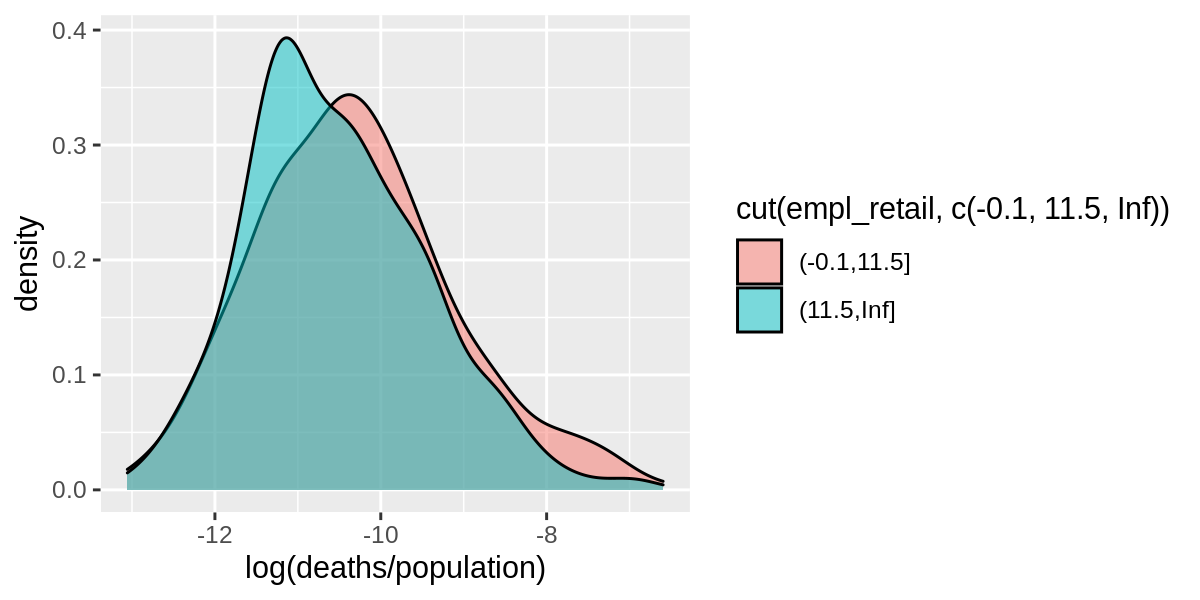

In [64]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(empl_retail, c(-0.1, 11.5, Inf)))) + geom_density(alpha=.5)
# opposite of what I had expected

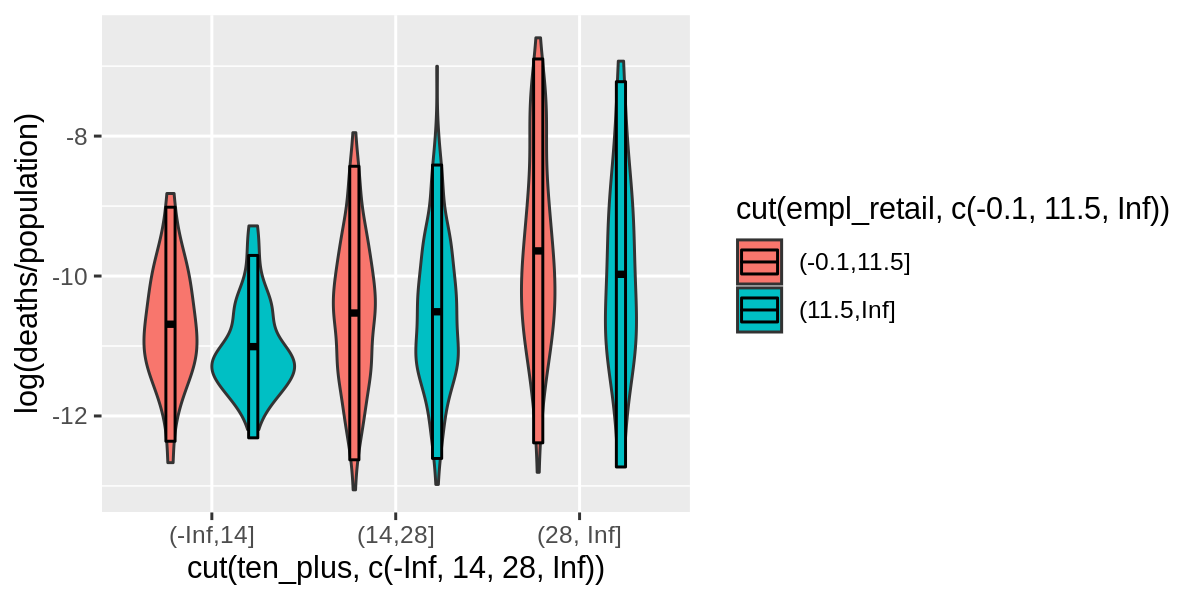

In [65]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 28, Inf)), log(deaths/population), fill=cut(empl_retail, c(-0.1, 11.5, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))

In [66]:
abbrev.prc_public_transp.describe()

count    823.0
mean       1.9
std        4.3
min        0.0
25%        0.3
50%        0.7
75%        1.8
max       55.9
Name: prc_public_transp, dtype: float64

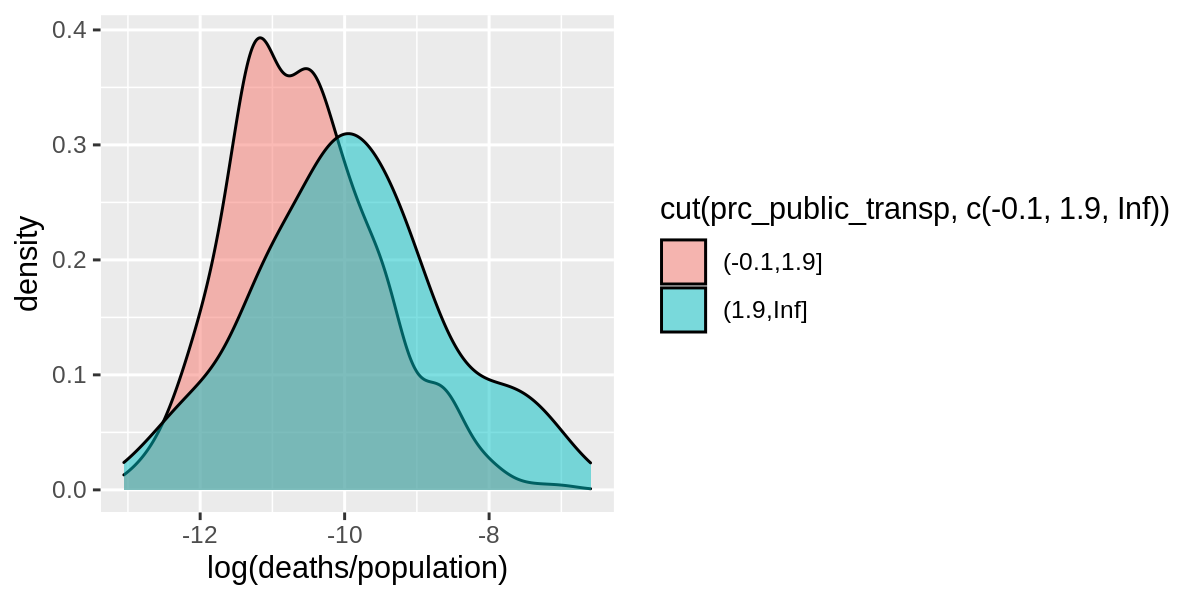

In [67]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9, Inf)))) + geom_density(alpha=.5)
# does look like a higher mean deaths/population for counties with higher than average % of population commuting via public transportation

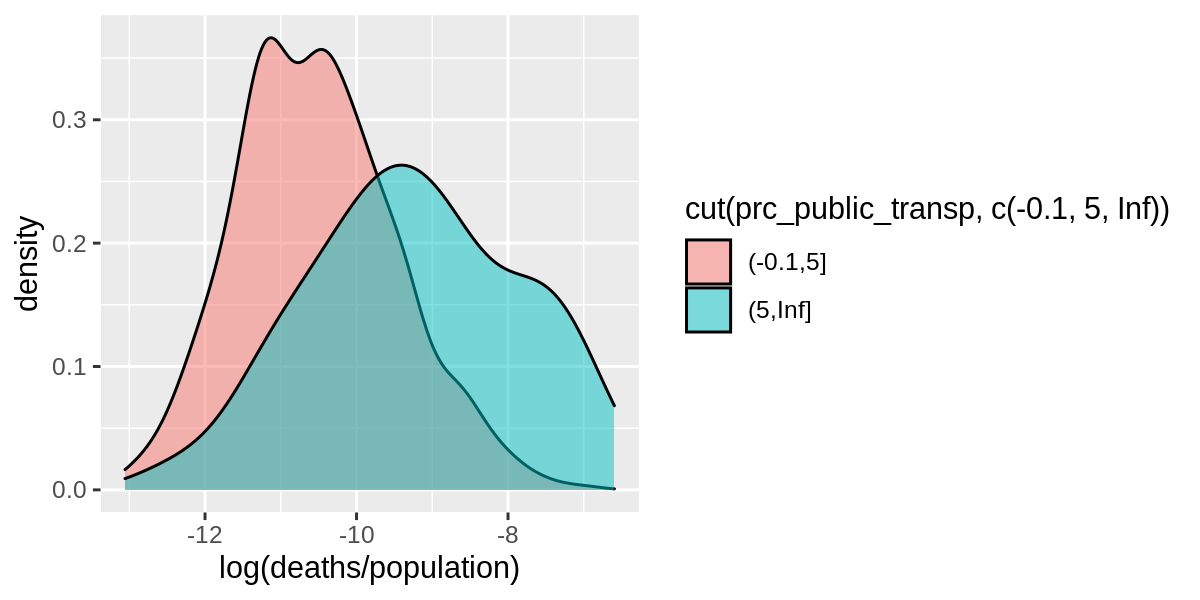

In [68]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 5, Inf)))) + geom_density(alpha=.5)

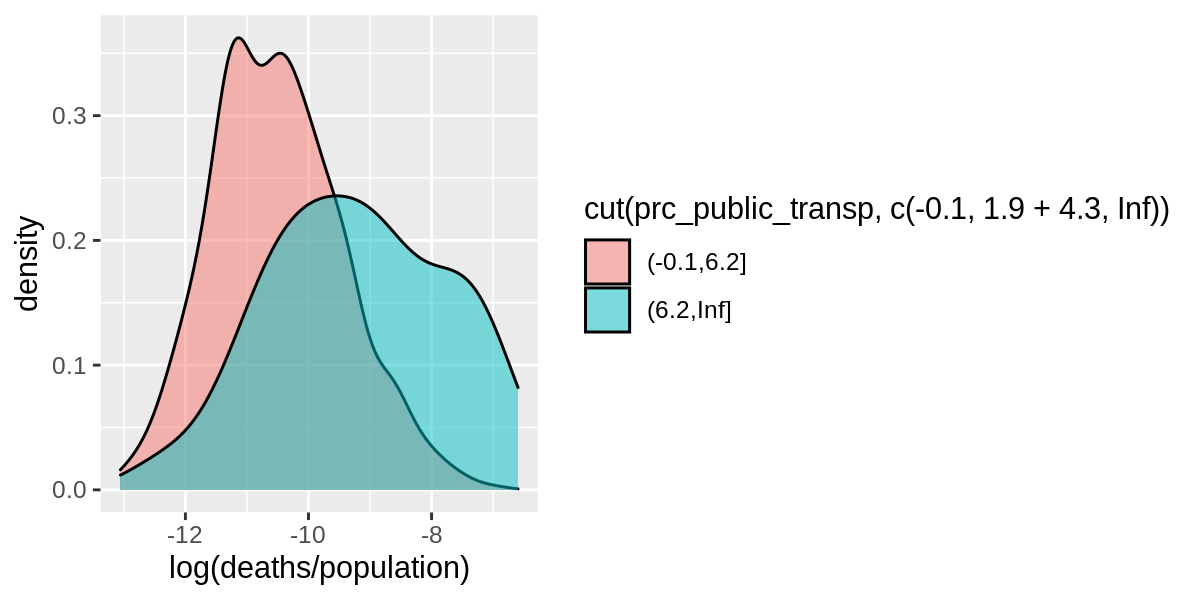

In [69]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9+4.3, Inf)))) + geom_density(alpha=.5)

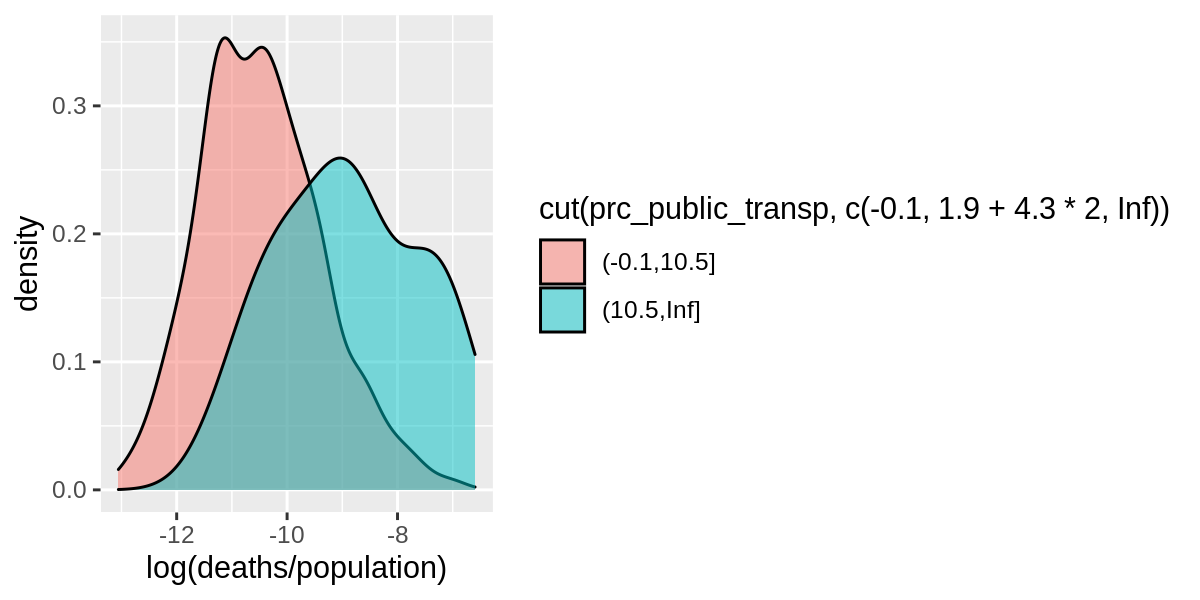

In [70]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(x=log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9+4.3*2, Inf)))) + geom_density(alpha=.5)

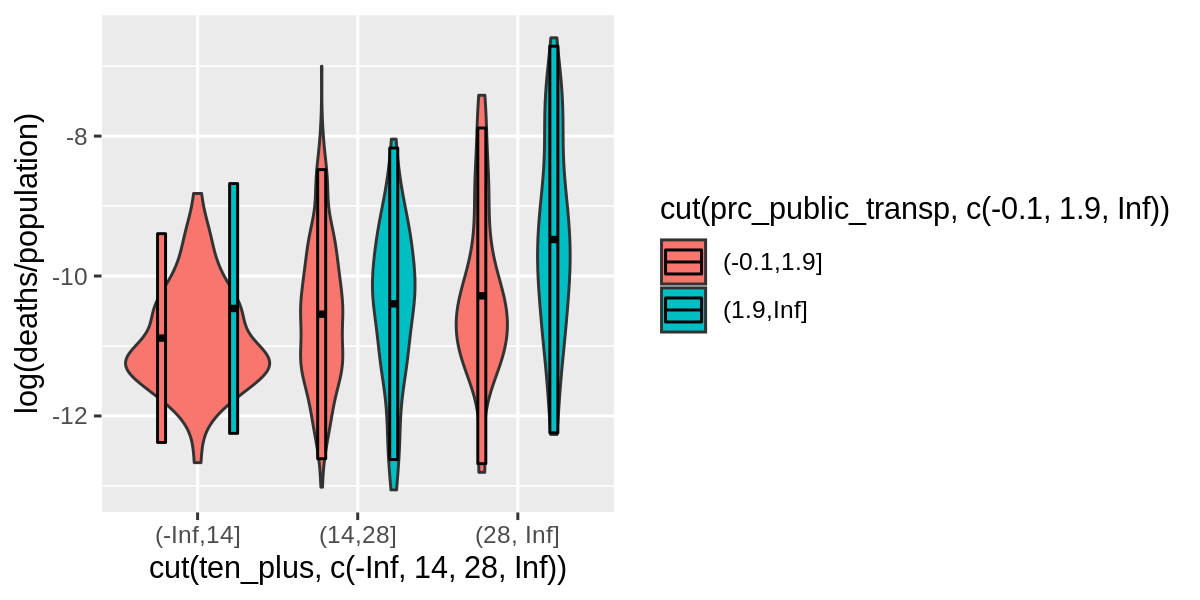

In [71]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 28, Inf)), log(deaths/population), fill=cut(prc_public_transp, c(-0.1, 1.9, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))
# for each group of time since 10+ cases detected, looks like mean number of deaths/population higher for group with higher % using public transportation 

In [72]:
abbrev.pop_65_plus.mean()

16.681072606125227

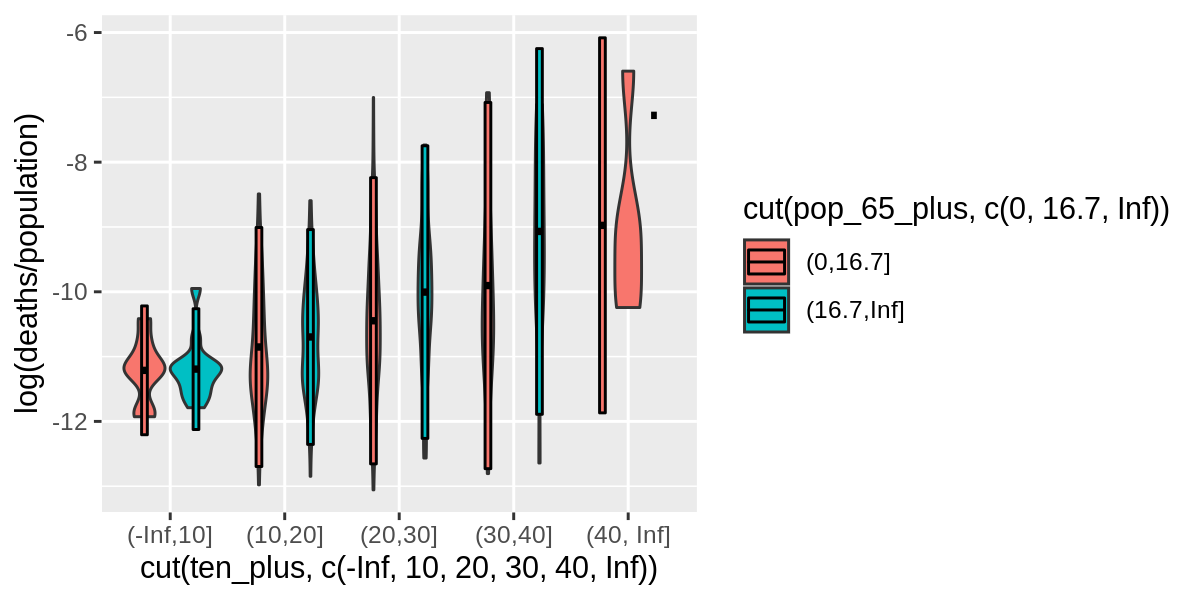

In [73]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(deaths/population), fill=cut(pop_65_plus, c(0, 16.7, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))
#geom_boxplot(width=0.1, position=position_dodge(0.9))

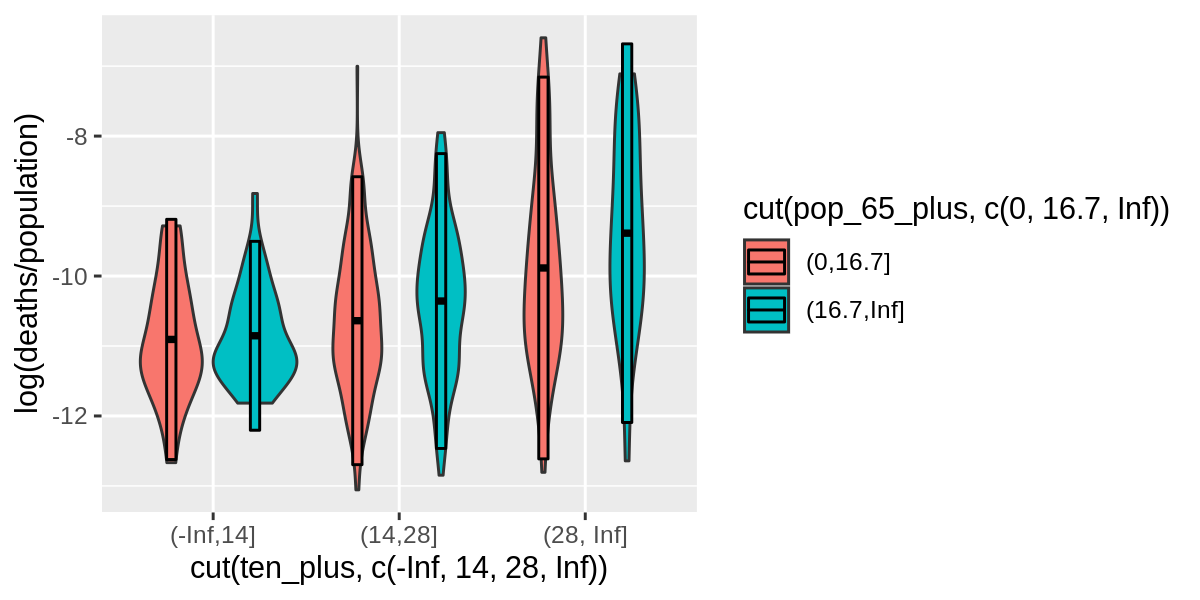

In [74]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 28, Inf)), log(deaths/population), fill=cut(pop_65_plus, c(0, 16.7, Inf)))) +  
geom_violin() +  #stat_summary(fun.y=mean, geom="point", shape=23, size=2, position = position_dodge(0.9))
stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))

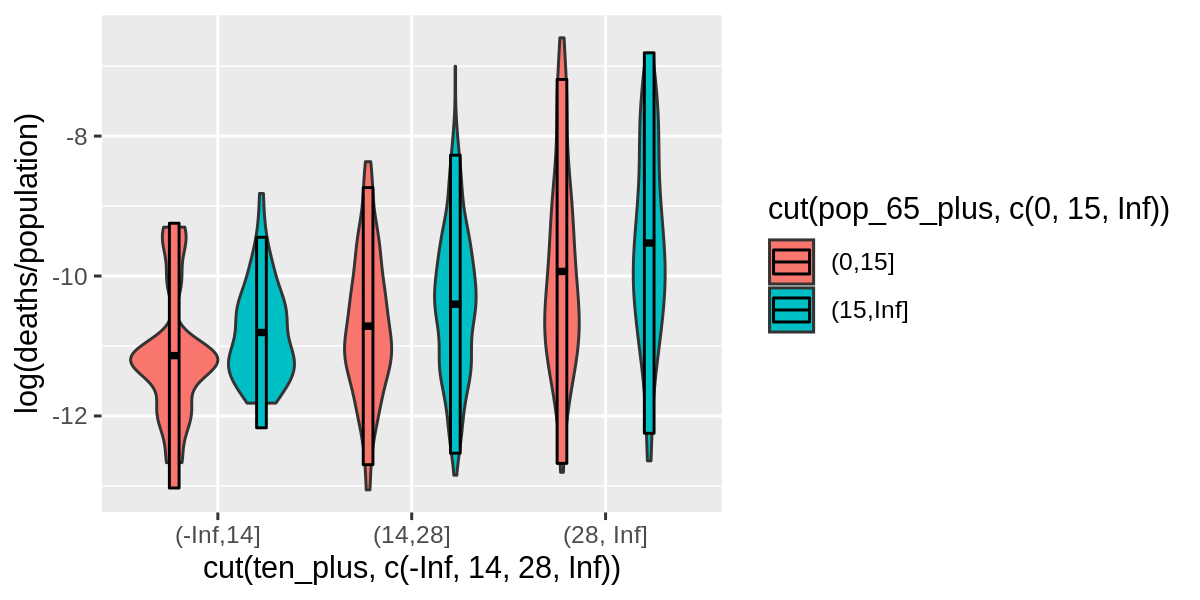

In [75]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 14, 28, Inf)), log(deaths/population), fill=cut(pop_65_plus, c(0, 15, Inf)))) +  
geom_violin() +  #stat_summary(fun.y=mean, geom="point", shape=23, size=2, position = position_dodge(0.9))
stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))

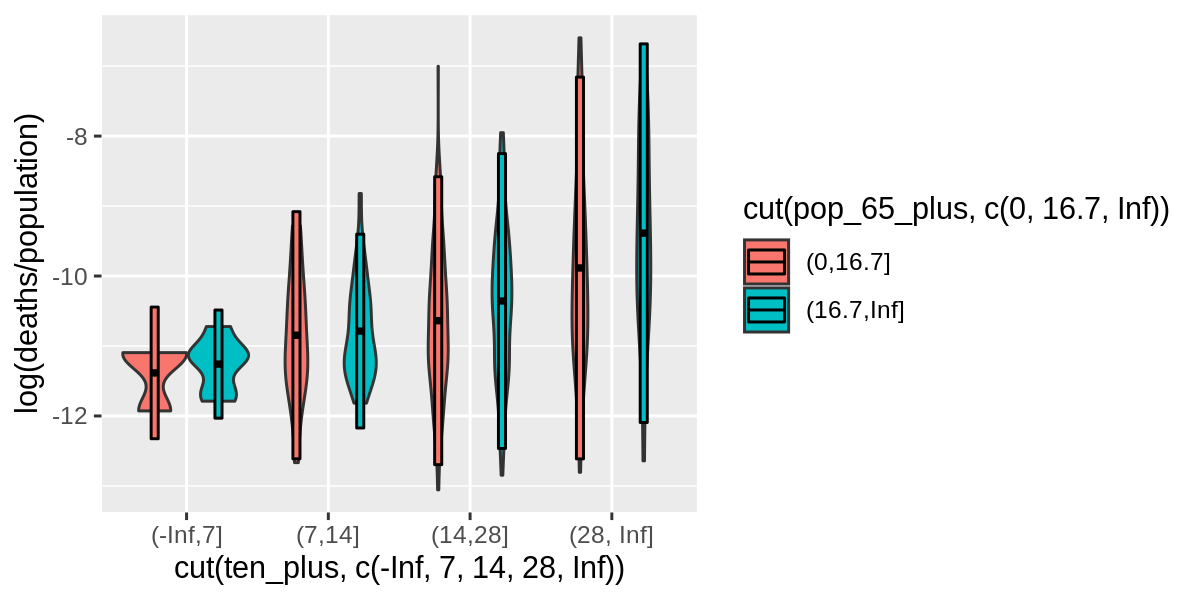

In [76]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 28, Inf)), log(deaths/population), fill=cut(pop_65_plus, c(0, 16.7, Inf)))) +  
geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, geom="crossbar", width=0.1, position = position_dodge(0.9))

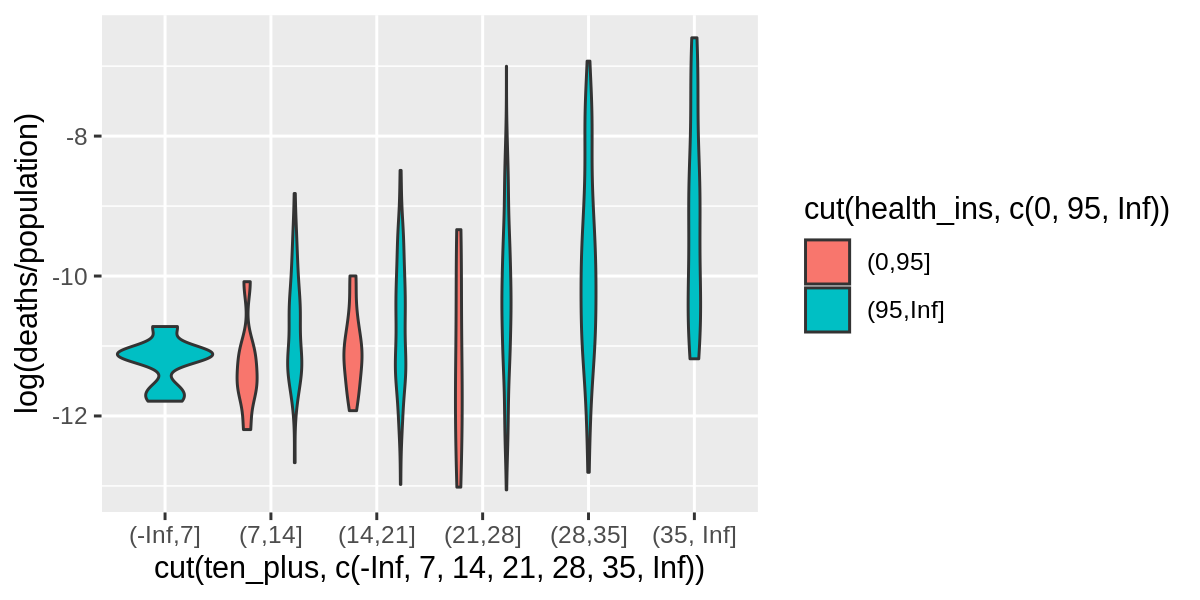

In [77]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf)), log(deaths/population), fill=cut(health_ins, c(0, 95, Inf)))) +  
geom_violin()

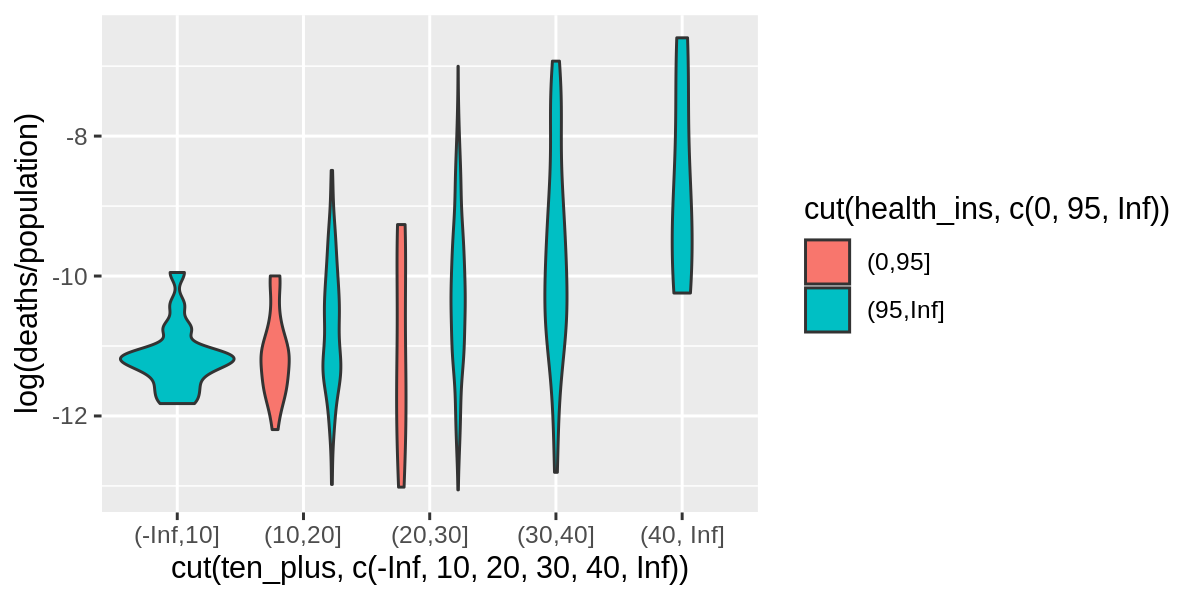

In [78]:
%%R -w 6 -h 3 --units in -r 200

# it does seem like counties with higher ratio of deaths/population -- did these counties see infections earlier, or were they better at detecting infections earlier?
ggplot(abbrev, aes(cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf)), log(deaths/population), fill=cut(health_ins, c(0, 95, Inf)))) +  
geom_violin()

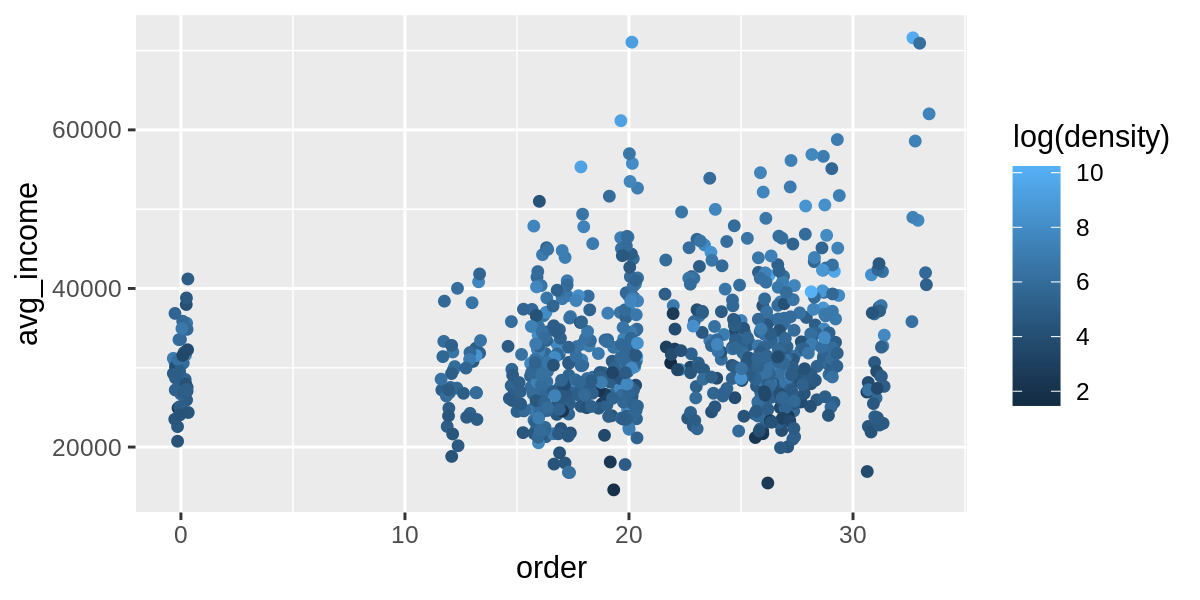

In [79]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(order, avg_income, color=log(density)))
# those counties without orders tend to have lower avg. income, though counties with a wide variety of 
# avg. income levels (probably due to statewide orders)

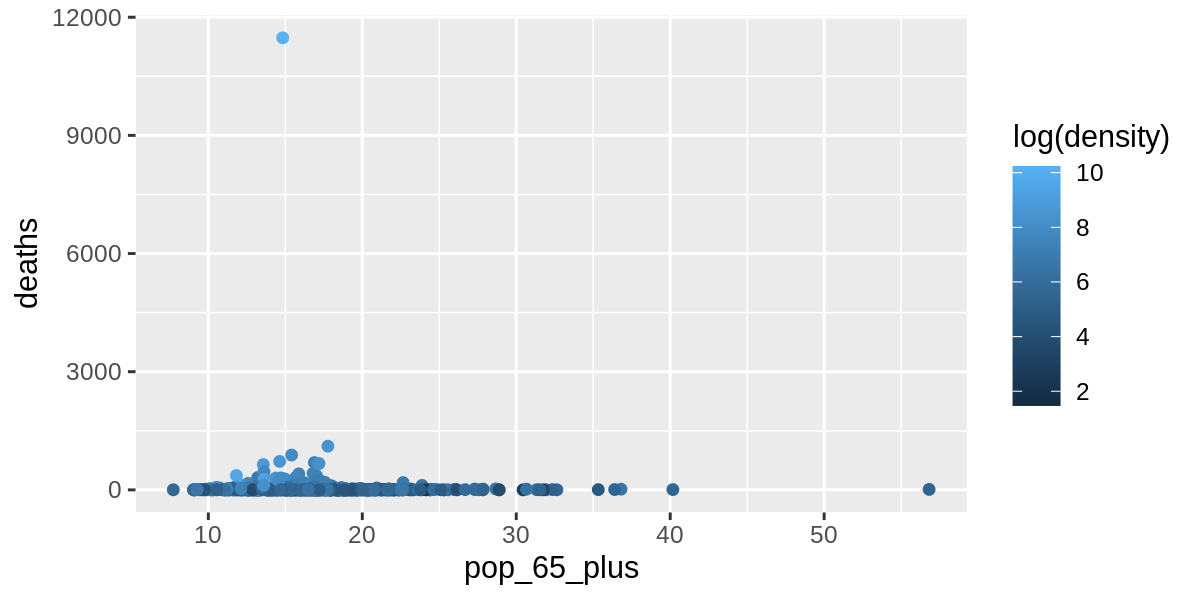

In [80]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(pop_65_plus, deaths, color=log(density)))

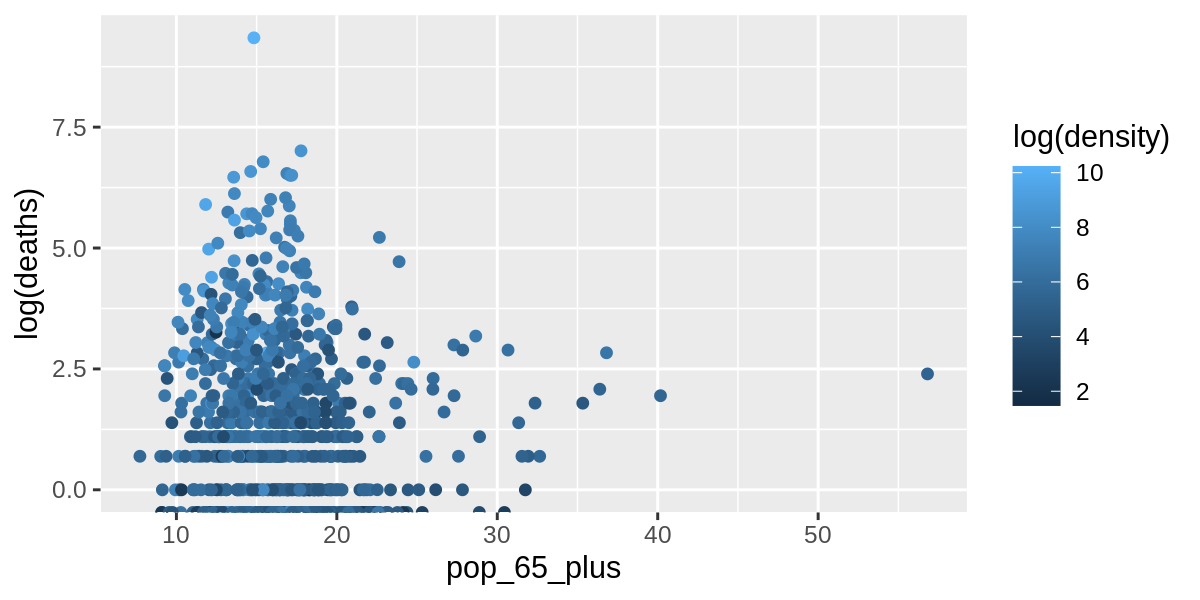

In [81]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(pop_65_plus, log(deaths), color=log(density)))

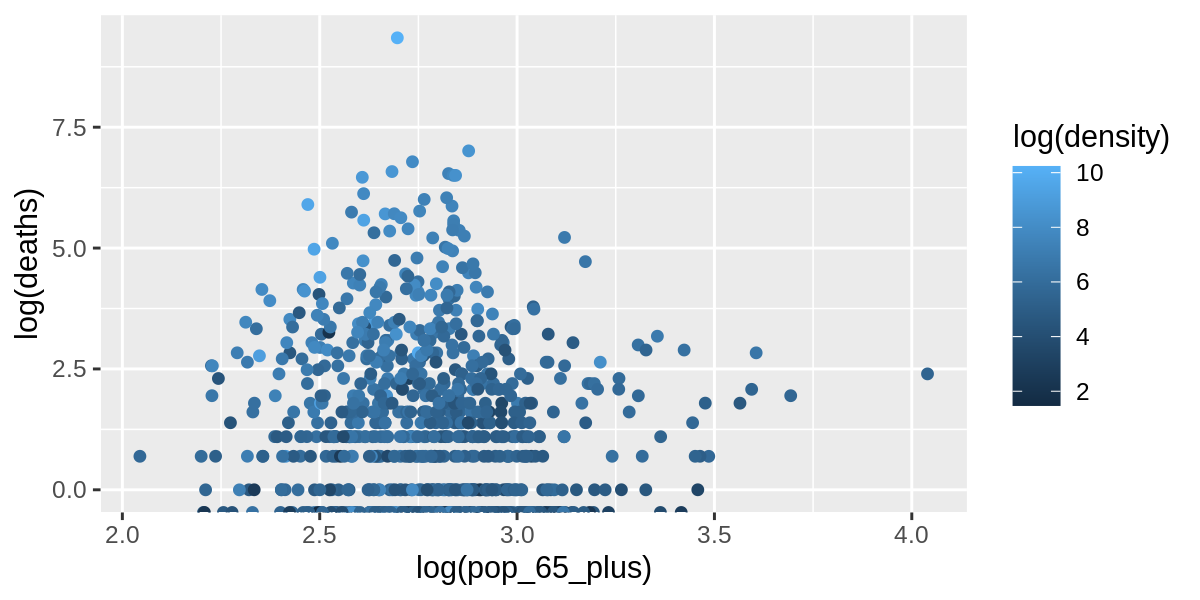

In [82]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(pop_65_plus), log(deaths), color=log(density)))

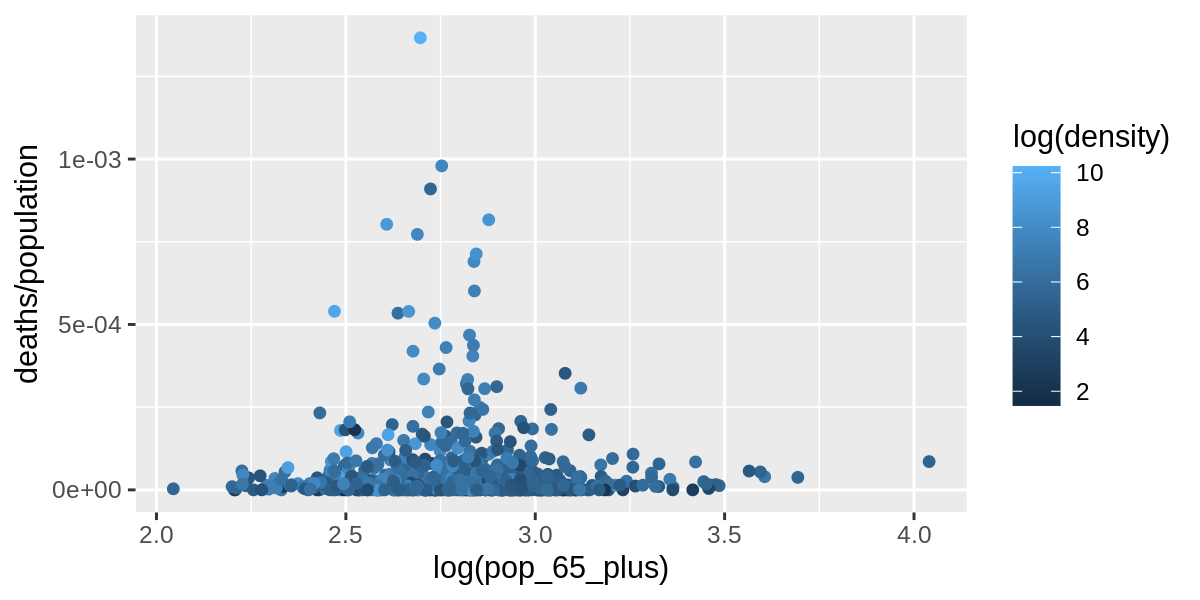

In [83]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(pop_65_plus), deaths/population, color=log(density)))

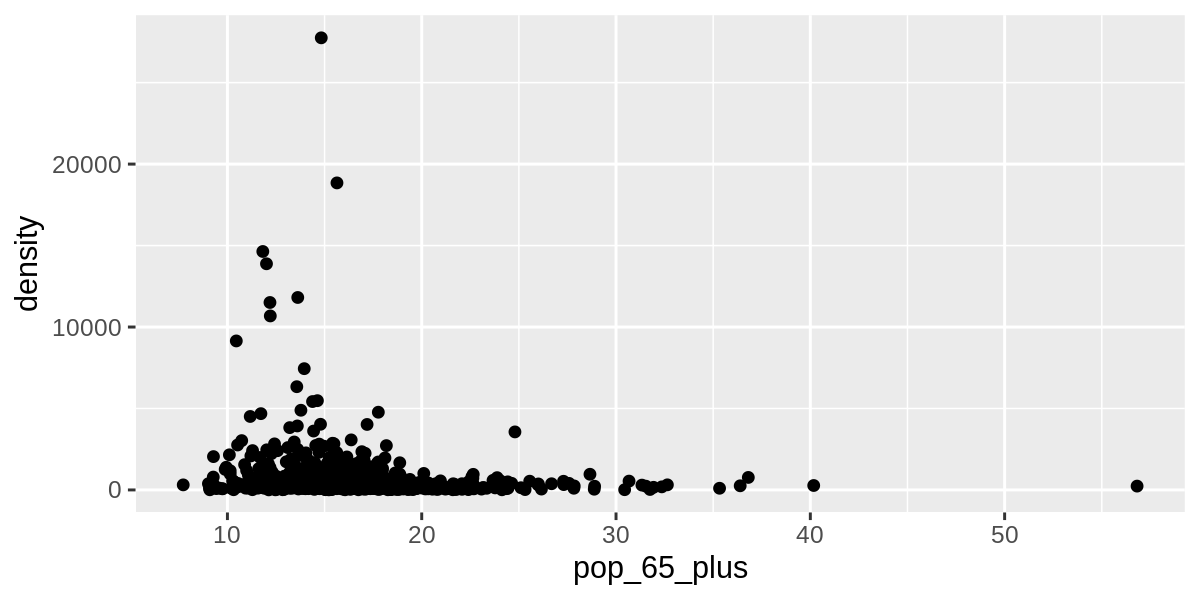

In [84]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(pop_65_plus, density))

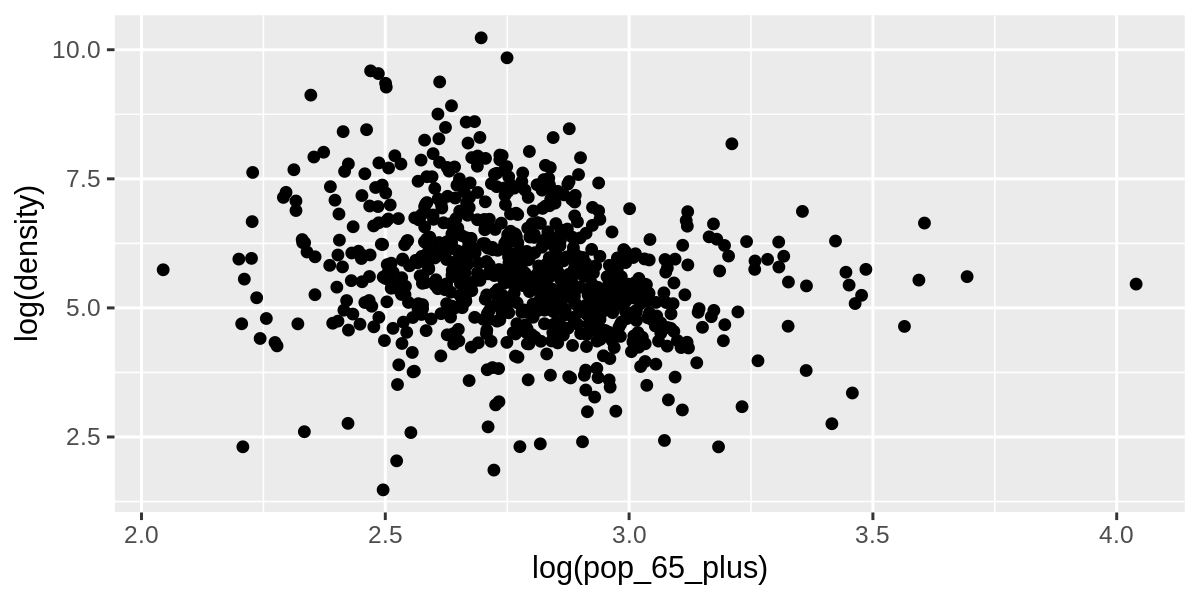

In [85]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(pop_65_plus), log(density)))
# no clear correlation b/n county density and % of population that is 65+ 

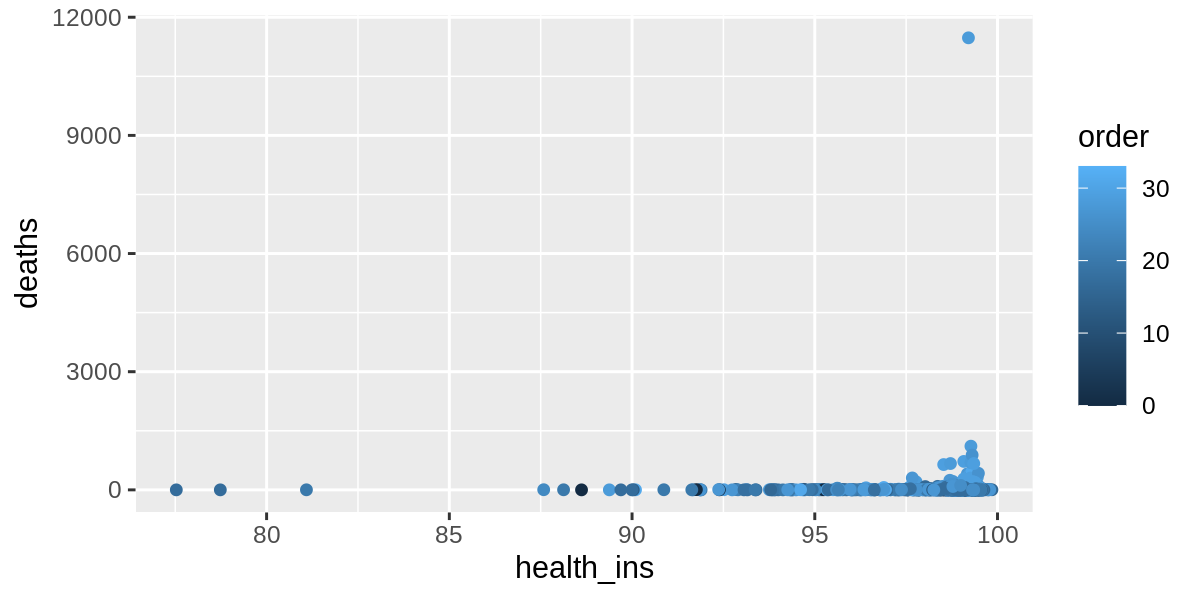

In [86]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(health_ins, deaths, color=order))

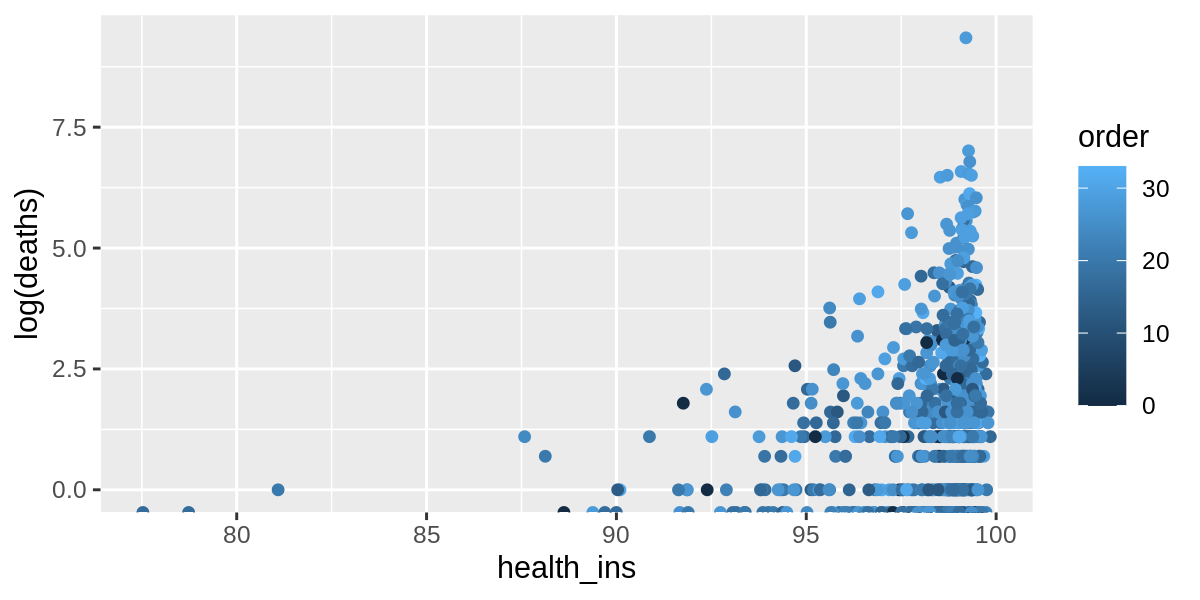

In [87]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(health_ins, log(deaths), color=order))

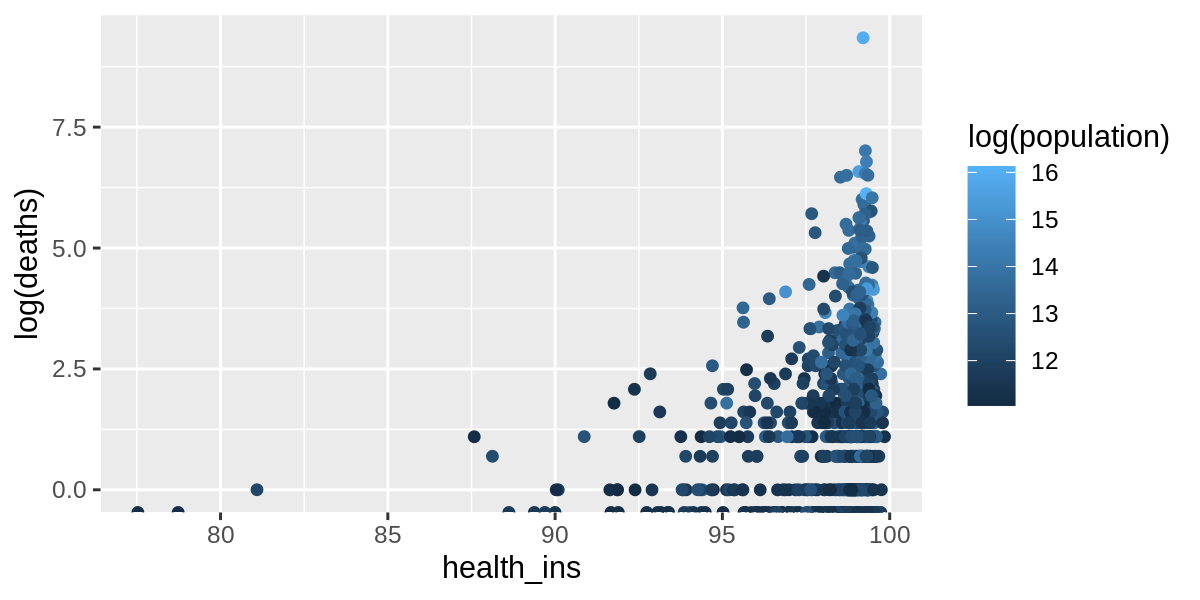

In [88]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(health_ins, log(deaths), color=log(population)))

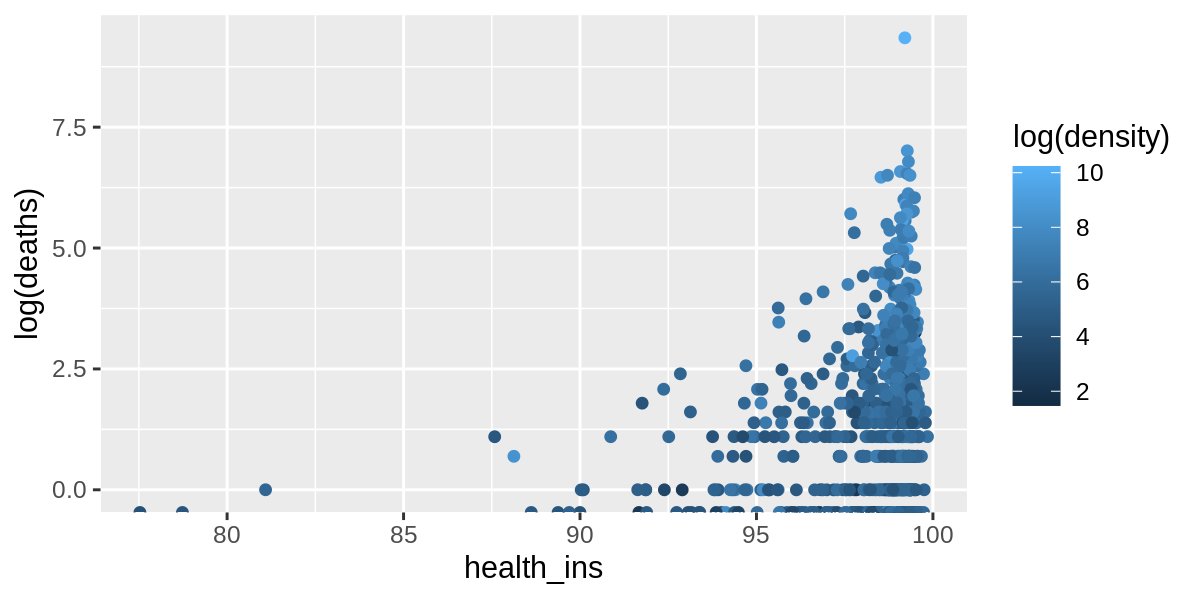

In [89]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(health_ins, log(deaths), color=log(density)))
# looks - is it that more covid19 deaths are tested when insured numbers are higher?  those with more
# insurance are probably healthier, no?

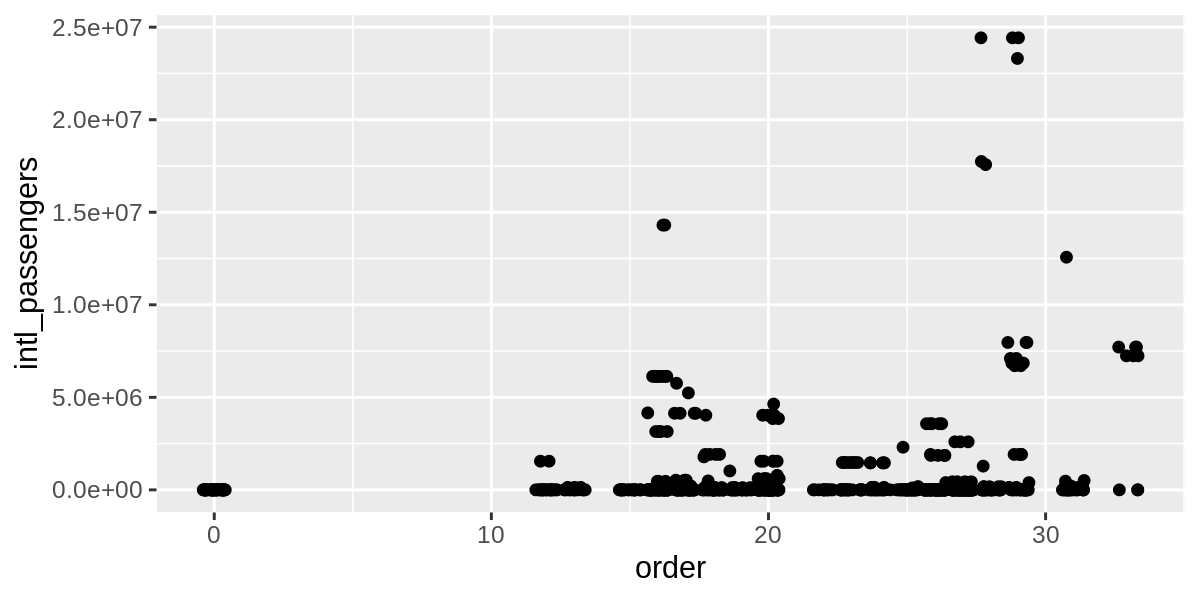

In [90]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes( order, intl_passengers)) 
# generally more international passengers had earlier orders? (sort of??)

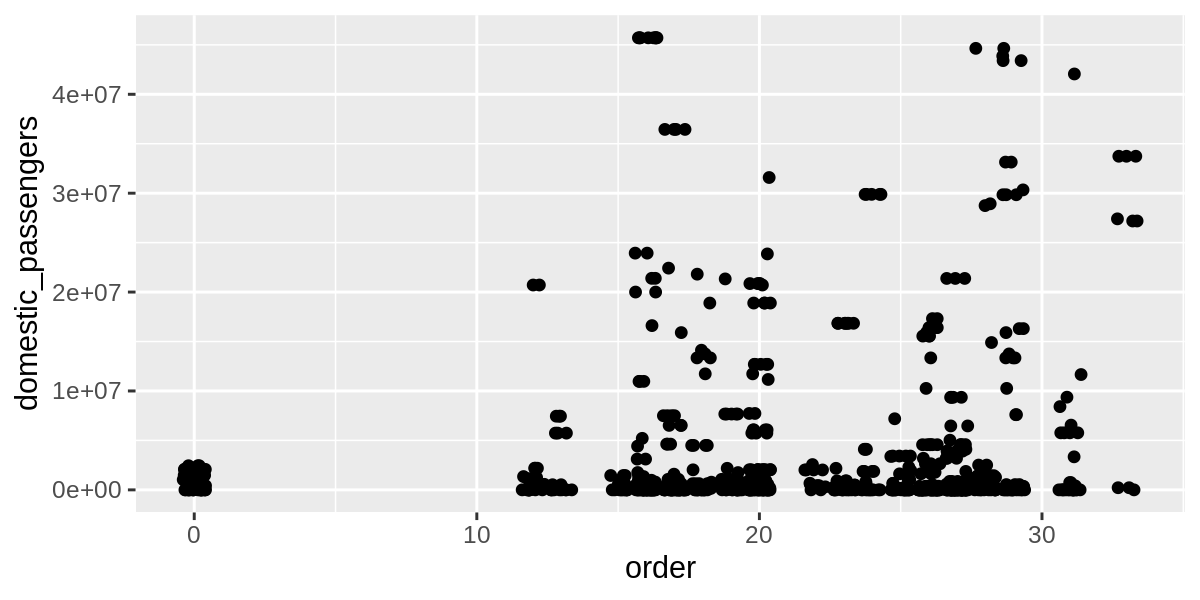

In [91]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes( order, domestic_passengers))
# kindof all over the place

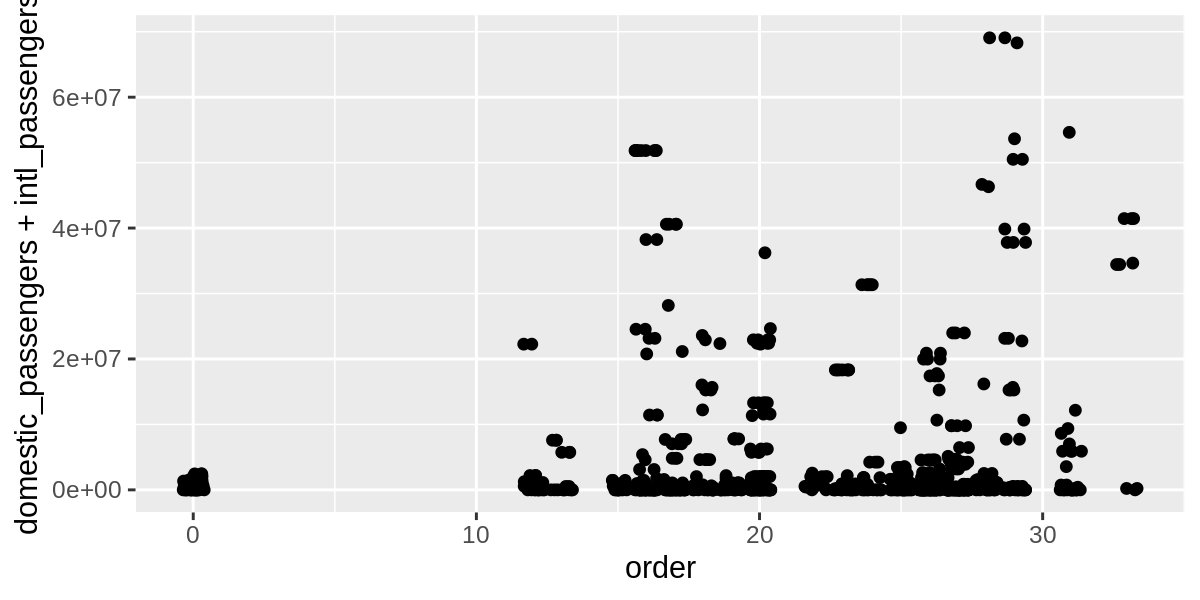

In [92]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes( order, domestic_passengers + intl_passengers))
# kindof all over the place

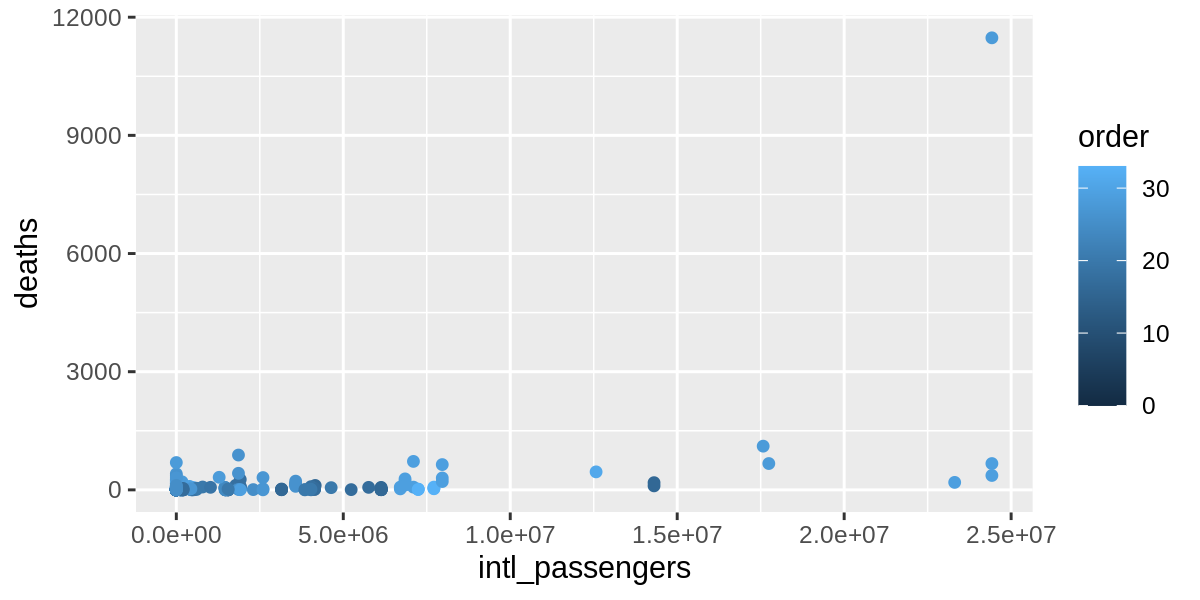

In [93]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(intl_passengers, deaths, color=order))

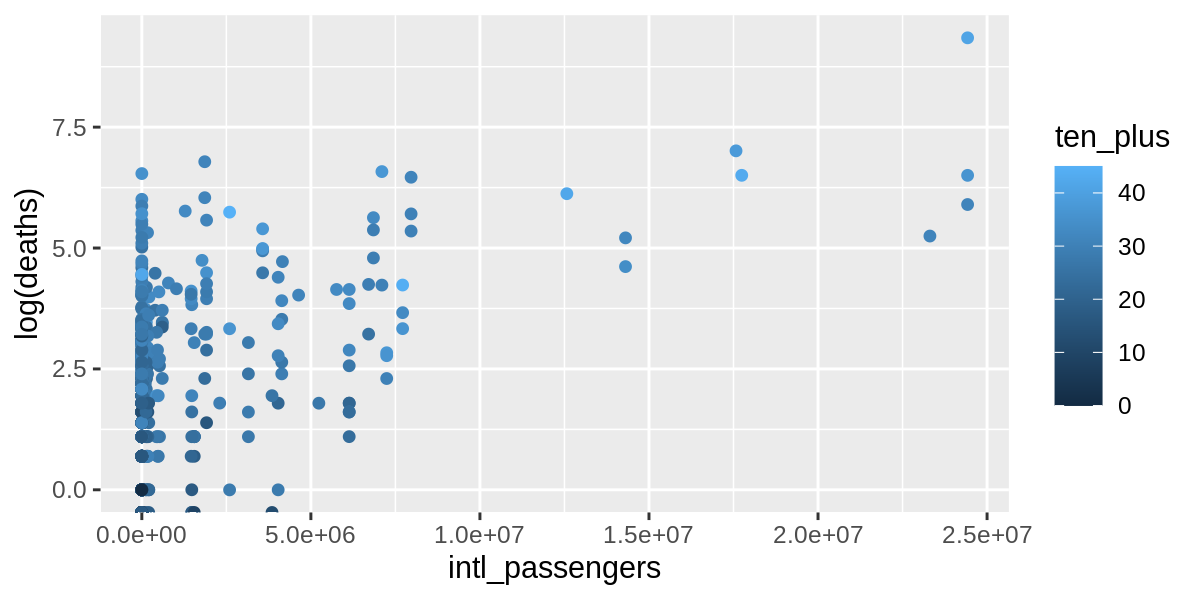

In [94]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(intl_passengers, log(deaths), color=ten_plus))

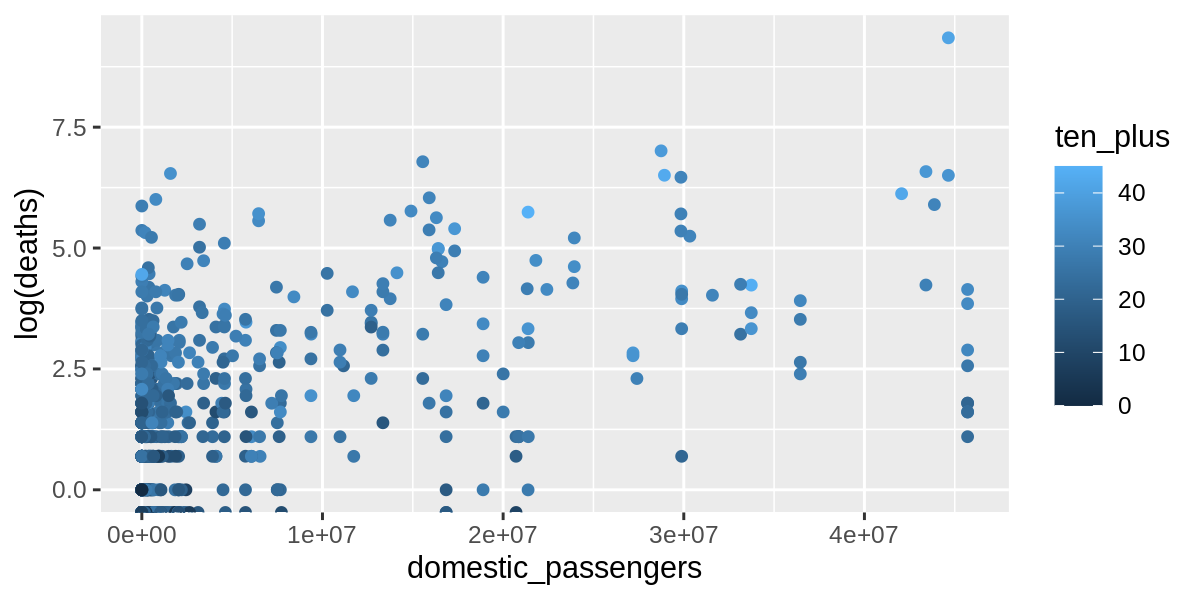

In [95]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(domestic_passengers, log(deaths), color=ten_plus))

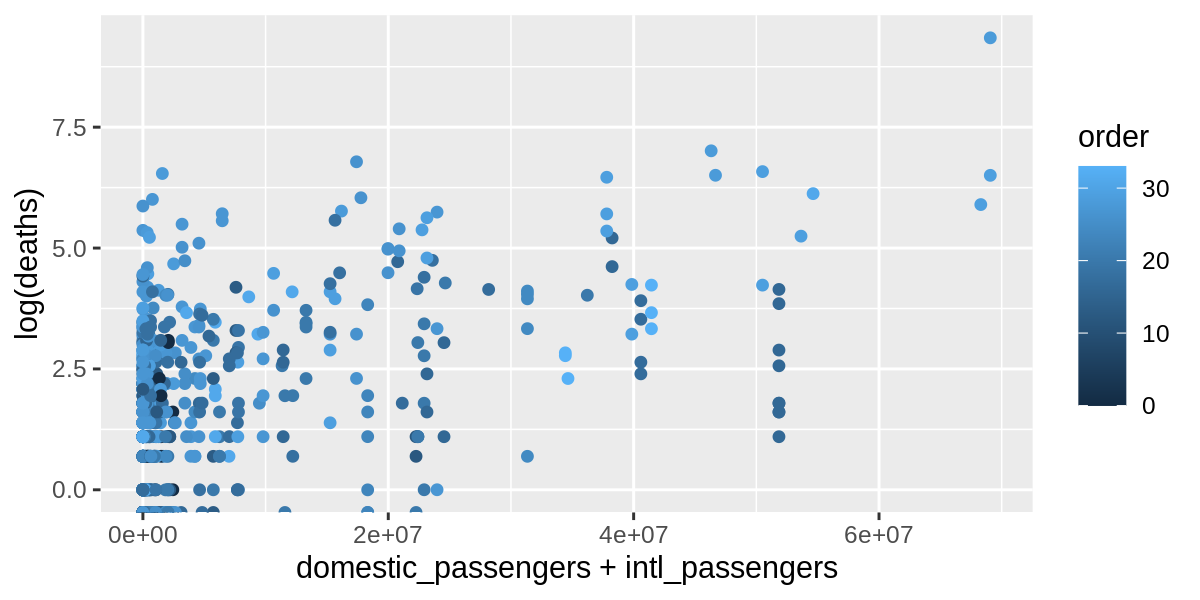

In [96]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(domestic_passengers+intl_passengers, log(deaths), color=order))

In [97]:
abbrev["death_prc"] = abbrev["deaths"]/abbrev["population"]

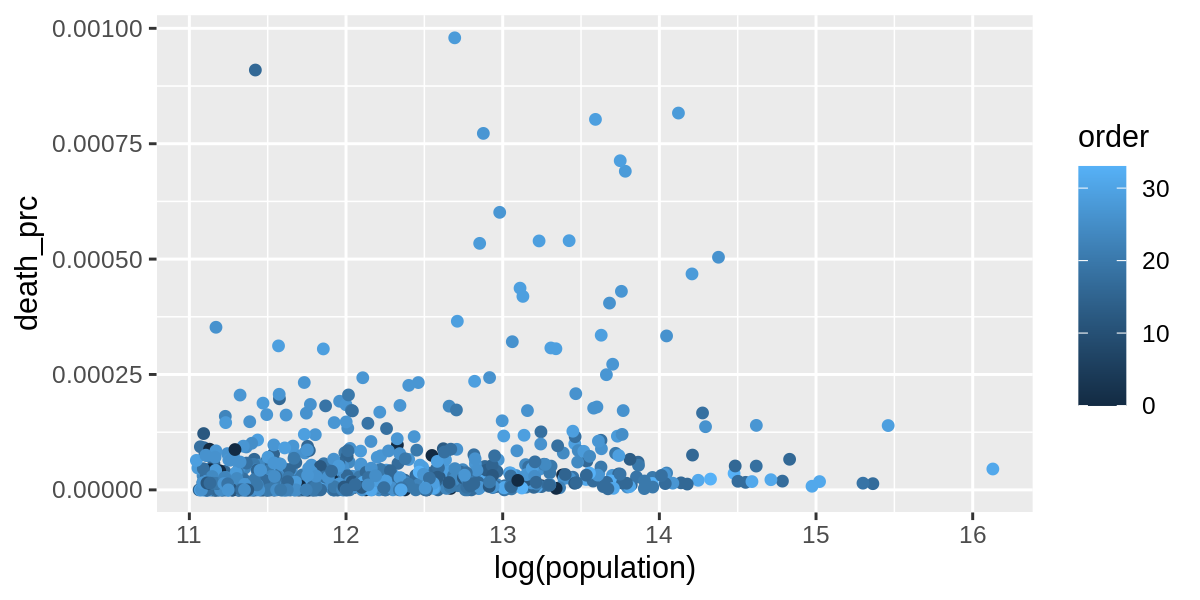

In [98]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(log(population), death_prc, color=order))

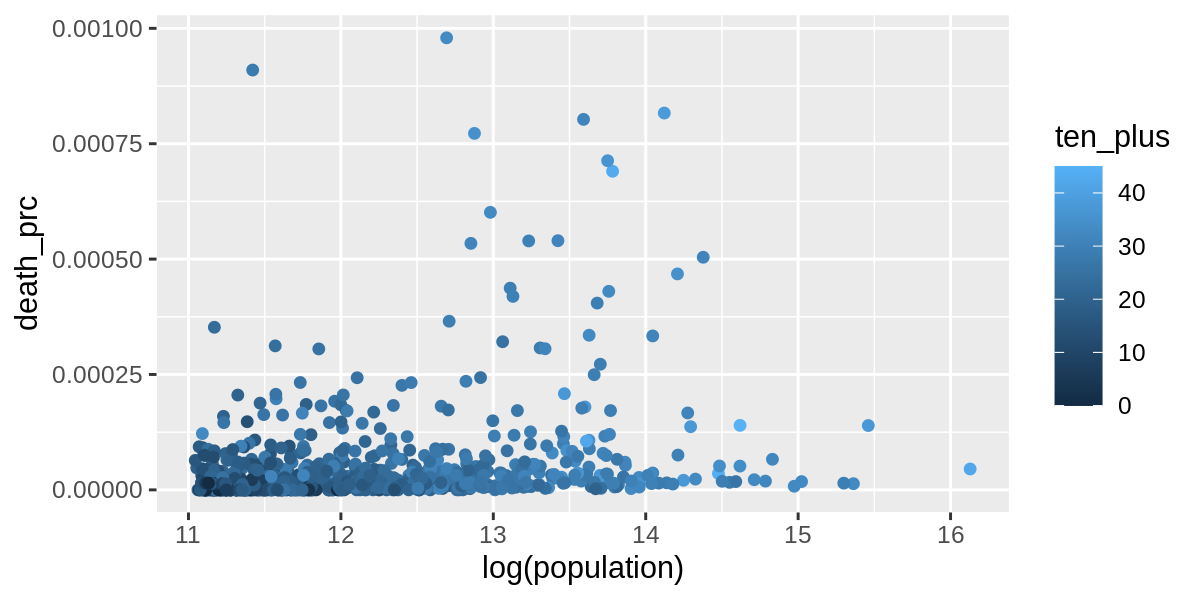

In [99]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(log(population), death_prc, color=ten_plus))

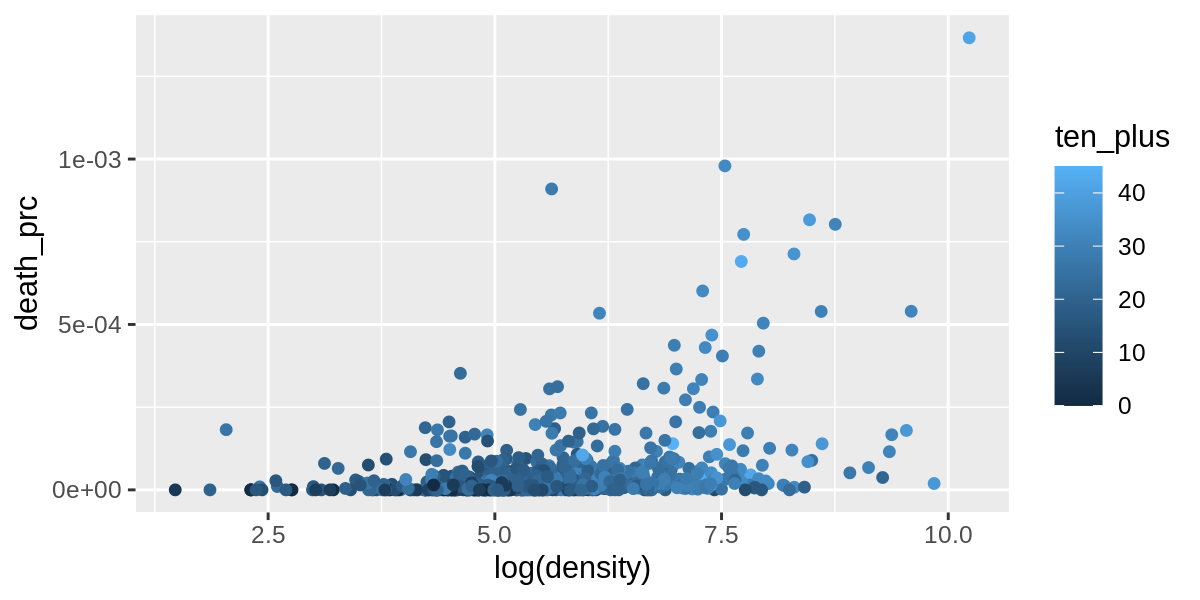

In [100]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), death_prc, color=ten_plus))

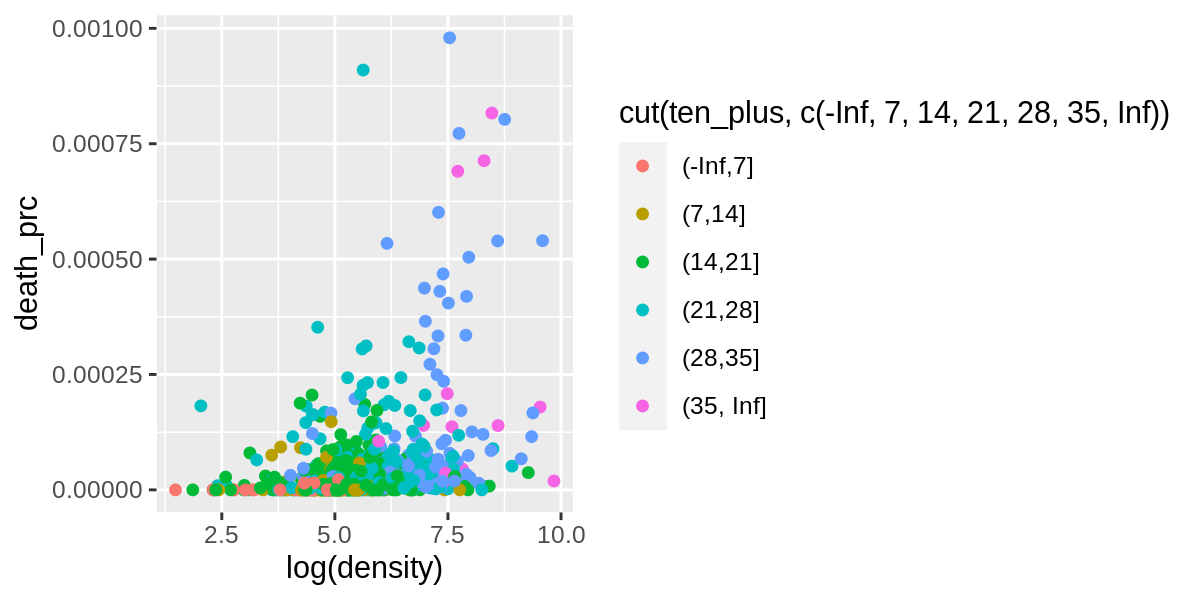

In [101]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(log(density), death_prc, 
                                                               color=cut(ten_plus, c(-Inf, 7, 14, 21, 28, 35, Inf))))

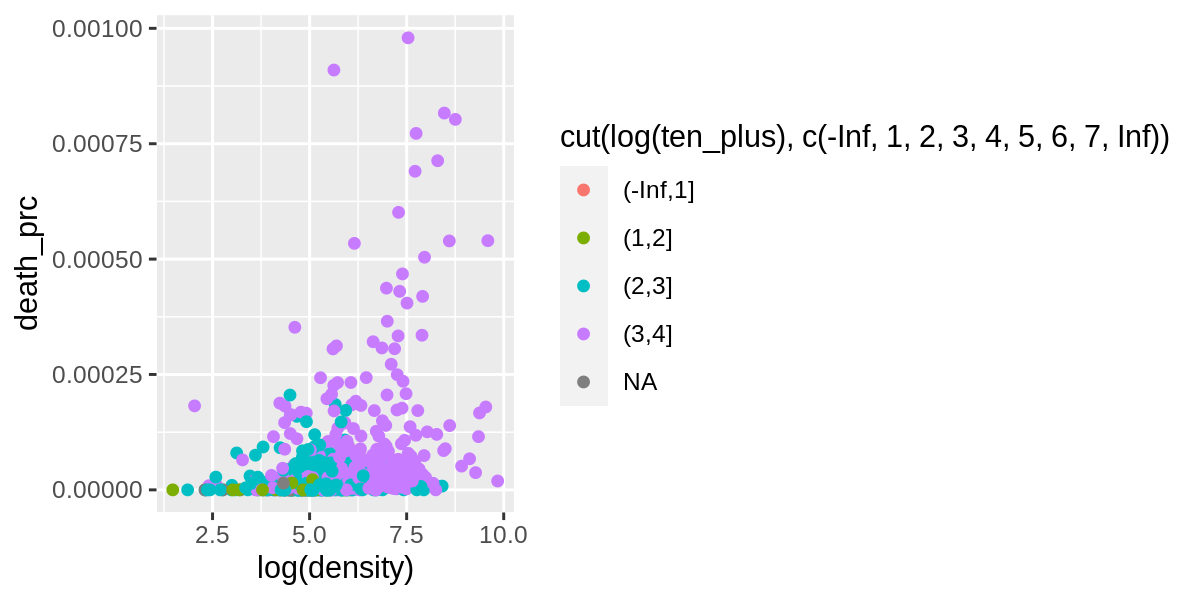

In [102]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(log(density), death_prc, 
                                                               color=cut(log(ten_plus), c(-Inf, 1, 2, 3, 4, 5, 6, 7, Inf))))

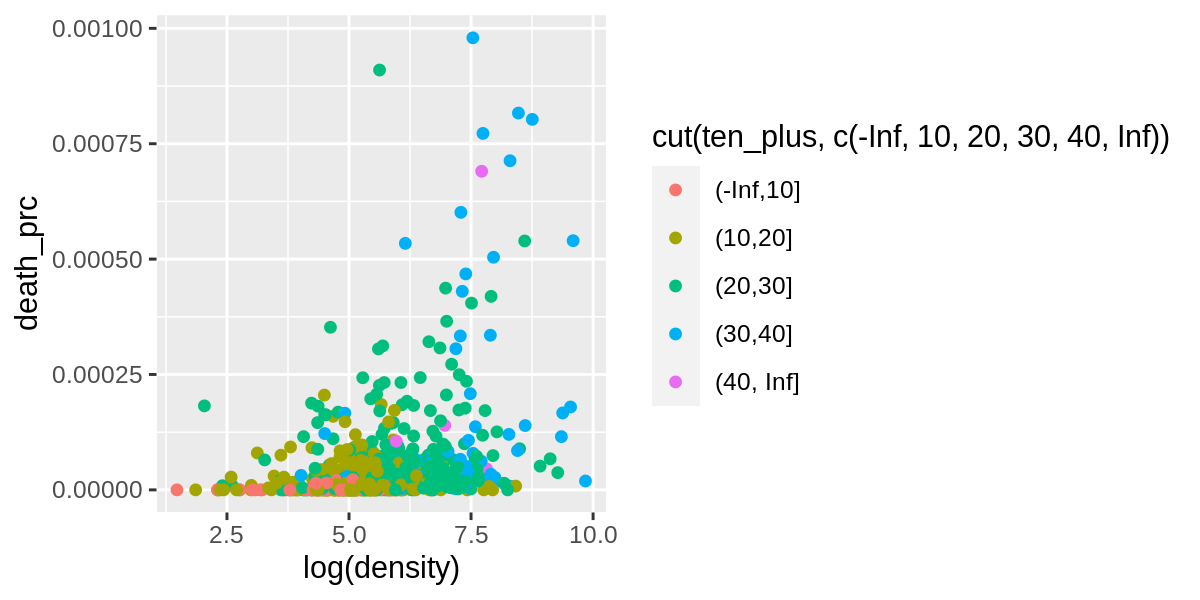

In [103]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$deaths < 9000),]) + geom_jitter(aes(log(density), death_prc, 
                                                               color=cut(ten_plus, c(-Inf, 10, 20, 30, 40, Inf))))

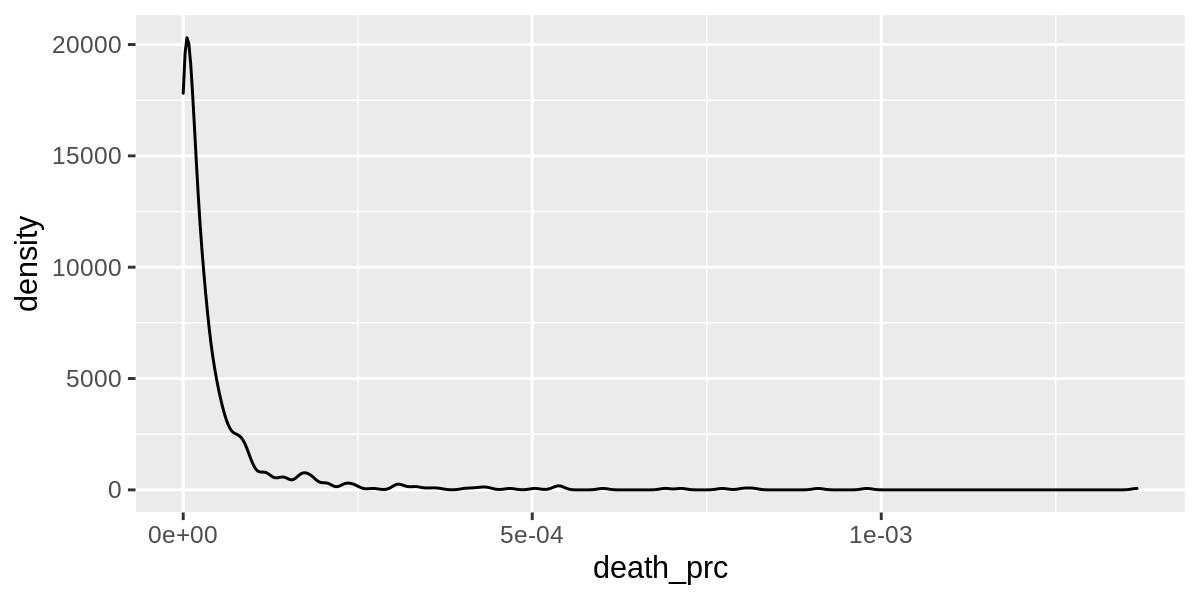

In [104]:
%%R -w 6 -h 3 --units in -r 200

# look at distribution of deaths as % of population?  
# any difference when the number of deaths (and assumption being # of infections) is lower in the population?
ggplot(abbrev, aes(death_prc)) + geom_density()

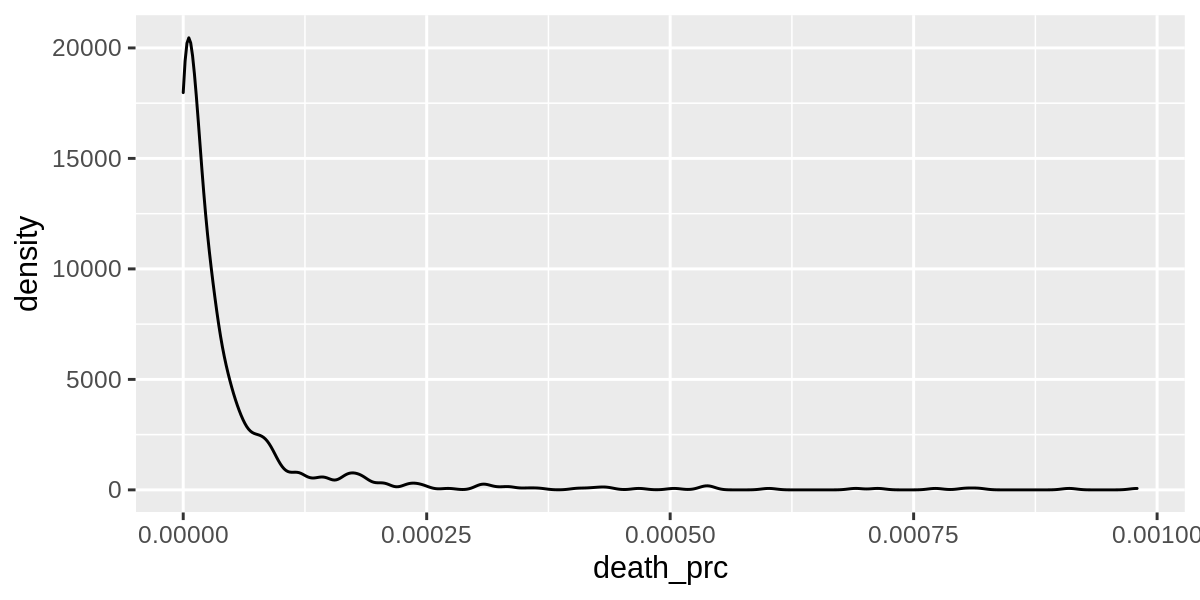

In [105]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[which(abbrev$death_prc <0.001),], aes(death_prc)) + geom_density()
# vast majority of counties have a very low rate of covid19 deaths as percentage of their population

In [106]:
abbrev[(abbrev["ten_plus"] < 20) & (np.log(abbrev["density"]) > 8)]

household_size  empl_agriculture  empl_professional  empl_social  \
428             2.4               0.1               10.5         23.9   

     empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
428           12.9                 6.4         12.6             13.7   

     avg_income  prc_public_transp  ...        county  state  area  \
428     30127.0                3.3  ...  Norfolk city     VA  54.1   

    domestic_passengers intl_passengers  deaths  ten_plus  order  density  \
428             2036000               0       2        19     20   4509.9   

     death_prc  
428    8.2e-06  

[1 rows x 23 columns]

In [107]:
abbrev[(abbrev["death_prc"] < 0.001) & (np.log(abbrev["density"]) > 8)]
# all of these have an airport within 20 miles getting at least domestic passengers (most also intl.)
# 

household_size  empl_agriculture  empl_professional  empl_social  \
37              2.4           8.1e-02               16.8         30.6   
59              2.5           1.1e-01               16.8         18.2   
91              2.8           7.2e-01               14.5         17.2   
154             2.4           3.2e-01               12.7         30.7   
165             2.0           3.2e-01               13.1         29.4   
169             2.7           3.2e-01               14.5         25.0   
215             2.2           2.9e-02               23.4         16.7   
237             3.0           6.5e-01               14.7         19.2   
273             2.6           5.0e-01               11.1         28.2   
286             3.0           9.5e-02               13.8         28.8   
338             2.4           1.1e-01               25.2         18.0   
342             2.3           1.0e+00               18.8         20.3   
346             2.3           3.1e-01               23.9         18.8   
356             2.6           2.1e-01               14.9         23.1   
428             2.4           1.3e-01               10.5         23.9   
511             2.5           1.7e-01               12.3         31.4   
527             2.1           2.9e-01               28.0         14.6   
551             2.4           2.2e-01               14.6         21.3   
582             2.9           9.9e-02               13.2         23.2   
605             2.6           2.3e-01               12.6         29.7   
715             2.4           1.9e-01               15.3         24.6   
770             2.7           1.9e-01               13.4         25.8   
819             2.4           3.2e-01               10.7         26.3   

     empl_services  empl_manufacturing  empl_retail  prc_fam_poverty  \
37            10.3                 4.9          8.7             11.8   
59             9.5                 6.3         10.4             11.6   
91             9.4                 8.4         10.6             10.8   
154            9.2                 4.5          8.8             13.9   
165           12.3                 8.2          7.9             17.0   
169            7.6                 7.0          9.1             12.2   
215            9.6                 3.3          6.2              9.9   
237           11.1                11.6         10.5              7.3   
273            9.5                11.7          9.8              9.8   
286            7.3                 4.1          9.0              4.1   
338           10.6                 5.3          9.3              5.1   
342            9.7                 5.2          9.4              8.1   
346            9.7                 1.3          4.4             11.3   
356            9.5                 9.5          9.5             10.2   
428           12.9                 6.4         12.6             13.7   
511            9.3                 6.5          9.2             19.2   
527            6.7                 2.9          4.6              4.0   
551           11.1                 7.1         12.8              8.0   
582            6.3                 8.1         11.0              5.3   
605            8.3                 7.3         10.2              5.9   
715           10.9                 6.7         10.8             14.6   
770            6.5                 7.8         10.7              5.7   
819            9.1                14.8         11.2             14.1   

     avg_income  prc_public_transp  ...                county  state   area  \
37      41657.0               31.4  ...        Suffolk County     MA   58.1   
59      42150.0               43.9  ...         Hudson County     NJ   46.2   
91      32467.0                2.5  ...         Dallas County     TX  871.3   
154     31433.0               16.2  ...        Baltimore city     MD   80.9   
165     31537.0               10.1  ...        St. Louis city     MO   61.9   
169     39708.0               21.0  ...          

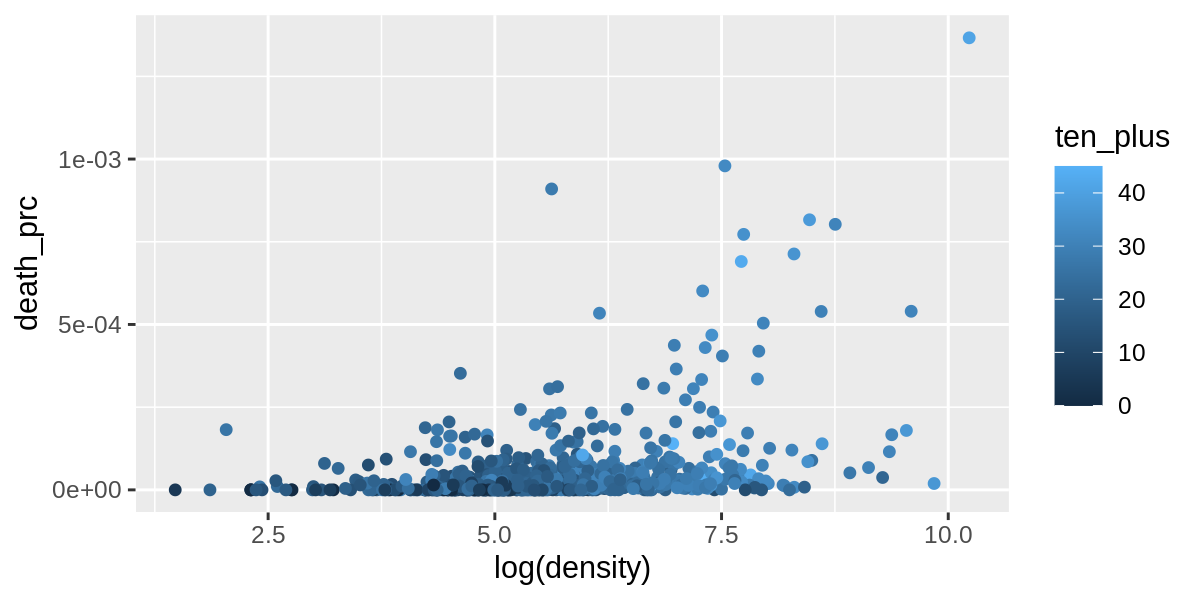

In [108]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_jitter(aes(log(density), death_prc, color=ten_plus))

In [109]:
abbrev.to_csv("data/abbrev.csv")